In [1]:
# import os
from tqdm import trange
# import wandb

# import re
import gymnasium as gym
# from llamagym import Agent
import numpy as np
import d3rlpy
import pickle
import pandas as pd

# from gymnasium_env import BlackjackWrapper
import matplotlib.pyplot as plt
from atariari.benchmark.wrapper import AtariARIWrapper
from env.atari.represented_atari_game import GymCompatWrapper2

class InputParams:
    def __init__(self):
        self.env="CartPole-v0" #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
        self.seed=1
        self.gpu=True

args=InputParams()
n_pretrain_eps = 10
n_online_eps = 108#90
n_exp = 5

# d3rlpy supports both Gym and Gymnasium
if "Represented" in args.env:
    env = GymCompatWrapper2(gym.make(args.env))
    eval_env = GymCompatWrapper2(gym.make(args.env))
else:
    env = gym.make(args.env)
    eval_env = gym.make(args.env)

# fix seed
d3rlpy.seed(args.seed)
d3rlpy.envs.seed_env(env, args.seed)
d3rlpy.envs.seed_env(eval_env, args.seed)

2025-04-06 22:20.43 [info     ] Register Shimmy environments. 


/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


## Offline pretraining

In [2]:
# # setup algorithm
# llama_dqn = d3rlpy.algos.DQNConfig(
#     batch_size=32,
#     learning_rate=6.25e-5,
#     ).create(device=args.gpu)

# with open('data/random_eps_5000.pkl', 'rb') as file:
# # with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
# # with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
#     dataset = pickle.load(file)

# # start offline training
# llama_dqn.fit(dataset, n_steps=1300) #Around 500 eps here

# with open('models/dqn_random_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_Qwen2.5-0.5B_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_llama_eps_500.pkl', 'wb') as file:
#         pickle.dump(llama_dqn, file)

## Load pretrained model and online training

In [3]:
# def online_training(
#     env,
#     eval_env,
#     explorer=None,
#     model_path=None,
#     model=None,
#     data_path=None,
#     n_pretrain_eps=125,
#     limit=1000000,
#     n_steps=1050,
#     n_steps_per_epoch=300,
#     # update_interval=1,
#     cut_off_threshold=None,
#     gpu=True
# ):
#     # Load model with proper validation
#     if model_path:
#         with open(model_path, 'rb') as file:
#             dqn = pickle.load(file)
#     elif model:
#         dqn = model
#     else:
#         dqn = d3rlpy.algos.DQNConfig(
#             batch_size=32,
#             learning_rate=6.25e-5,
#             ).create(device=gpu)

#     # Initialize empty FIFO buffer
#     buffer = d3rlpy.dataset.ReplayBuffer(
#         buffer=d3rlpy.dataset.FIFOBuffer(limit=limit),
#         env=env,
#     )
    
#     # Load and merge offline data with type-checking
#     if data_path:
#         try:
#             # Load dataset with proper validation
#             with open(data_path, 'rb') as f:
#                 dataset = pickle.load(f)
            
#             # Verify dataset structure
#             if hasattr(dataset, 'episodes'):
#                 # Calculate safe episode count to load
#                 valid_episodes = min(n_pretrain_eps, len(dataset.episodes))
                
#                 # Append episodes with transition validation
#                 for episode in dataset.episodes[:valid_episodes]:
#                     if len(episode) > 0 and hasattr(episode, 'rewards'):
#                         buffer.append_episode(episode)
#                     else:
#                         print(f"Skipping invalid episode: {episode}")
#         except Exception as e:
#             print(f"Error loading dataset: {str(e)}")

#     # Configure training with safety checks
#     if buffer.transition_count == 0:
#         print("Empty buffer (just Online training)!")
#     dqn.fit_online(
#         env=env,
#         buffer=buffer,
#         explorer=explorer,
#         eval_env=eval_env,
#         n_steps=n_steps,
#         n_steps_per_epoch=n_steps_per_epoch,
#         # update_interval=update_interval,
#         # experiment_name="online_training",
#     )

#     # Extract rewards safely
#     rewards = []
#     for episode in buffer.episodes: # Only collect the online data
#         rewards.extend(episode.compute_return())
    
#     if cut_off_threshold:
#         start, end = cut_off_threshold
#         rewards = rewards[start:end]
#     return rewards

## Data collection

### Static/pretrain data

In [3]:
with open('data/CartPole_Qwen2.5-32B-Instruct_Neps_10_20250406061858.pkl', 'rb') as file:
    Qwen_32B_dataset = pickle.load(file)
    
with open('data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl', 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(n_pretrain_eps):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(n_pretrain_eps):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_32B_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_32B_rewards)
Qwen_7B_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_7B_rewards)

In [ ]:
# hyperparams = {
#         "env": "CartPole-v0", #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
#         "seed": 42069,
#         "n_episodes": 200,#5000,
#         "max_episode_len": 50, # Around 10h per 100k steps in Leviathan server
#         "eps": 0.1,  # epsilon for exploration
#         "n_exp": 5,
#         "n_pretrain_eps": 10,
#         "n_online_eps": 90,
#         "gpu": True, # True if use GPU to train with d3rlpy
#         "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
#         "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
#         "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
#         "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
#         "learning_rate":5e-5,
#         "gamma":0.99,
#         "target_update_interval":1000, #Test with 1k, 2k, 5k
#         "n_steps_per_epoch": 200,
#         "n_pretrain_steps": 3000
#     }
# pretrain_7b_dqn = d3rlpy.algos.DoubleDQNConfig(
#     batch_size=hyperparams['batch_size'], #Test smaller batch size: 32, 64. May be noisier
#     learning_rate=hyperparams['learning_rate'],
#     gamma=hyperparams['gamma'],
#     target_update_interval=hyperparams['target_update_interval'] #Test with 1k, 2k, 5k
#     ).create(device=hyperparams['gpu'])
# pretrain_32b_dqn = d3rlpy.algos.DoubleDQNConfig(
#     batch_size=hyperparams['batch_size'], #Test smaller batch size: 32, 64. May be noisier
#     learning_rate=hyperparams['learning_rate'],
#     gamma=hyperparams['gamma'],
#     target_update_interval=hyperparams['target_update_interval'] #Test with 1k, 2k, 5k
#     ).create(device=hyperparams['gpu'])

# hyperparams["target_update_interval"] = 200
# hyperparams['n_steps_per_epoch'] = 200
# # start offline training
# pretrain_7b_dqn.fit(Qwen_7B_dataset, n_steps=hyperparams["n_pretrain_steps"], n_steps_per_epoch=hyperparams['n_steps_per_epoch'])
# with open(f'models/{hyperparams["env"].split('-')[0]}_ddqn_pretrain_7b_{hyperparams["n_pretrain_steps"]}_steps.pkl', 'wb') as file:
#     pickle.dump(pretrain_7b_dqn, file)

# pretrain_32b_dqn.fit(Qwen_32B_dataset, n_steps=hyperparams["n_pretrain_steps"], n_steps_per_epoch=hyperparams['n_steps_per_epoch'])
# with open(f'models/{hyperparams["env"].split('-')[0]}_ddqn_pretrain_32b_{hyperparams["n_pretrain_steps"]}_steps.pkl', 'wb') as file:
#     pickle.dump(pretrain_32b_dqn, file)

2025-04-06 22:57.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-06 22:57.49 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_20250406225749
2025-04-06 22:57.49 [debug    ] Building models...            
2025-04-06 22:57.49 [debug    ] Models have been built.       
2025-04-06 22:57.49 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.

Epoch 1/15: 100%|██████████| 200/200 [00:01<00:00, 145.03it/s, loss=0.173]

2025-04-06 22:57.51 [info     ] DoubleDQN_20250406225749: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.002281625270843506, 'time_algorithm_update': 0.004472776651382447, 'loss': 0.1659179294621572, 'time_step': 0.006848318576812744} step=200
2025-04-06 22:57.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_200.d3



Epoch 2/15: 100%|██████████| 200/200 [00:01<00:00, 189.12it/s, loss=0.00319]

2025-04-06 22:57.52 [info     ] DoubleDQN_20250406225749: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.00211076021194458, 'time_algorithm_update': 0.003047610521316528, 'loss': 0.003109935213578865, 'time_step': 0.005246938467025757} step=400
2025-04-06 22:57.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_400.d3



Epoch 3/15: 100%|██████████| 200/200 [00:01<00:00, 197.41it/s, loss=0.00129]

2025-04-06 22:57.53 [info     ] DoubleDQN_20250406225749: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.002136141061782837, 'time_algorithm_update': 0.002808772325515747, 'loss': 0.0012858499836875127, 'time_step': 0.00503061294555664} step=600
2025-04-06 22:57.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_600.d3



Epoch 4/15: 100%|██████████| 200/200 [00:00<00:00, 206.12it/s, loss=0.00107]

2025-04-06 22:57.54 [info     ] DoubleDQN_20250406225749: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.0020639359951019286, 'time_algorithm_update': 0.0026725780963897704, 'loss': 0.0010708787094336003, 'time_step': 0.004816817045211792} step=800
2025-04-06 22:57.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_800.d3



Epoch 5/15: 100%|██████████| 200/200 [00:01<00:00, 196.68it/s, loss=0.000905]

2025-04-06 22:57.55 [info     ] DoubleDQN_20250406225749: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.002080485820770264, 'time_algorithm_update': 0.002885037660598755, 'loss': 0.0009028540522558614, 'time_step': 0.0050492632389068605} step=1000
2025-04-06 22:57.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_1000.d3



Epoch 6/15: 100%|██████████| 200/200 [00:01<00:00, 167.97it/s, loss=0.0498]

2025-04-06 22:57.56 [info     ] DoubleDQN_20250406225749: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.0021133649349212645, 'time_algorithm_update': 0.003714194297790527, 'loss': 0.048169904408568984, 'time_step': 0.005910146236419678} step=1200
2025-04-06 22:57.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_1200.d3



Epoch 7/15: 100%|██████████| 200/200 [00:01<00:00, 153.94it/s, loss=0.013] 

2025-04-06 22:57.57 [info     ] DoubleDQN_20250406225749: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.002234477996826172, 'time_algorithm_update': 0.004118548631668091, 'loss': 0.013068750113015995, 'time_step': 0.006447080373764038} step=1400
2025-04-06 22:57.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_1400.d3



Epoch 8/15: 100%|██████████| 200/200 [00:01<00:00, 159.53it/s, loss=0.0116]

2025-04-06 22:57.58 [info     ] DoubleDQN_20250406225749: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.002146519422531128, 'time_algorithm_update': 0.003984715938568115, 'loss': 0.01157268604147248, 'time_step': 0.006221524477005005} step=1600
2025-04-06 22:57.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_1600.d3



Epoch 9/15: 100%|██████████| 200/200 [00:01<00:00, 157.29it/s, loss=0.0109]

2025-04-06 22:58.00 [info     ] DoubleDQN_20250406225749: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.0022206926345825196, 'time_algorithm_update': 0.004008243083953858, 'loss': 0.010925017994595691, 'time_step': 0.006318120956420898} step=1800
2025-04-06 22:58.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_1800.d3



Epoch 10/15: 100%|██████████| 200/200 [00:01<00:00, 171.14it/s, loss=0.0106]

2025-04-06 22:58.01 [info     ] DoubleDQN_20250406225749: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.002054469585418701, 'time_algorithm_update': 0.0036675631999969482, 'loss': 0.010570831234799698, 'time_step': 0.0058021354675292965} step=2000
2025-04-06 22:58.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_2000.d3



Epoch 11/15: 100%|██████████| 200/200 [00:01<00:00, 165.51it/s, loss=0.0571]

2025-04-06 22:58.02 [info     ] DoubleDQN_20250406225749: epoch=11 step=2200 epoch=11 metrics={'time_sample_batch': 0.002056969404220581, 'time_algorithm_update': 0.0038572824001312255, 'loss': 0.05589990857057273, 'time_step': 0.005999159812927246} step=2200
2025-04-06 22:58.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_2200.d3



Epoch 12/15: 100%|██████████| 200/200 [00:01<00:00, 159.23it/s, loss=0.0311]

2025-04-06 22:58.03 [info     ] DoubleDQN_20250406225749: epoch=12 step=2400 epoch=12 metrics={'time_sample_batch': 0.0020755040645599365, 'time_algorithm_update': 0.00408044695854187, 'loss': 0.031080394638702272, 'time_step': 0.006238659620285034} step=2400
2025-04-06 22:58.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_2400.d3



Epoch 13/15: 100%|██████████| 200/200 [00:01<00:00, 159.38it/s, loss=0.0298]

2025-04-06 22:58.05 [info     ] DoubleDQN_20250406225749: epoch=13 step=2600 epoch=13 metrics={'time_sample_batch': 0.0020476770401000976, 'time_algorithm_update': 0.004102201461791992, 'loss': 0.029664429668337107, 'time_step': 0.006230431795120239} step=2600
2025-04-06 22:58.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_2600.d3



Epoch 14/15: 100%|██████████| 200/200 [00:01<00:00, 159.59it/s, loss=0.0295]

2025-04-06 22:58.06 [info     ] DoubleDQN_20250406225749: epoch=14 step=2800 epoch=14 metrics={'time_sample_batch': 0.00206707239151001, 'time_algorithm_update': 0.004077813625335693, 'loss': 0.029703937685117126, 'time_step': 0.006227471828460693} step=2800
2025-04-06 22:58.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_2800.d3



Epoch 15/15: 100%|██████████| 200/200 [00:01<00:00, 159.64it/s, loss=0.0285]

2025-04-06 22:58.07 [info     ] DoubleDQN_20250406225749: epoch=15 step=3000 epoch=15 metrics={'time_sample_batch': 0.0020981621742248535, 'time_algorithm_update': 0.004043639898300171, 'loss': 0.02852093882393092, 'time_step': 0.0062237799167633055} step=3000
2025-04-06 22:58.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225749/model_3000.d3
2025-04-06 22:58.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-06 22:58.07 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_20250406225807
2025-04-06 22:58.07 [debug    ] Building models...            
2025-04-06 22:58.07 [debug    ] Models have been built.       
2025-04-06 22:58.07 [info     ] Parameters               


Epoch 1/15: 100%|██████████| 200/200 [00:01<00:00, 161.93it/s, loss=0.174]

2025-04-06 22:58.08 [info     ] DoubleDQN_20250406225807: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.002030574083328247, 'time_algorithm_update': 0.004024358987808227, 'loss': 0.16610078753437846, 'time_step': 0.006137055158615112} step=200
2025-04-06 22:58.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_200.d3



Epoch 2/15: 100%|██████████| 200/200 [00:01<00:00, 162.75it/s, loss=0.00352]

2025-04-06 22:58.10 [info     ] DoubleDQN_20250406225807: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.0020375096797943114, 'time_algorithm_update': 0.003986687660217285, 'loss': 0.003440748987486586, 'time_step': 0.0061039566993713375} step=400
2025-04-06 22:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_400.d3



Epoch 3/15: 100%|██████████| 200/200 [00:01<00:00, 163.15it/s, loss=0.00136]

2025-04-06 22:58.11 [info     ] DoubleDQN_20250406225807: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.002062121629714966, 'time_algorithm_update': 0.003945159912109375, 'loss': 0.0013531527697341517, 'time_step': 0.006090183258056641} step=600
2025-04-06 22:58.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_600.d3



Epoch 4/15: 100%|██████████| 200/200 [00:01<00:00, 164.77it/s, loss=0.0011]

2025-04-06 22:58.12 [info     ] DoubleDQN_20250406225807: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.002027921676635742, 'time_algorithm_update': 0.003921027183532715, 'loss': 0.0011021051165880636, 'time_step': 0.0060313701629638675} step=800
2025-04-06 22:58.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_800.d3



Epoch 5/15: 100%|██████████| 200/200 [00:01<00:00, 162.23it/s, loss=0.00114]

2025-04-06 22:58.13 [info     ] DoubleDQN_20250406225807: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.0020476210117340086, 'time_algorithm_update': 0.0039984798431396485, 'loss': 0.0011494967967155389, 'time_step': 0.006126562356948853} step=1000
2025-04-06 22:58.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_1000.d3



Epoch 6/15: 100%|██████████| 200/200 [00:01<00:00, 158.59it/s, loss=0.0464]

2025-04-06 22:58.15 [info     ] DoubleDQN_20250406225807: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.0020973801612854002, 'time_algorithm_update': 0.004076054096221924, 'loss': 0.044758553887950255, 'time_step': 0.006265106201171875} step=1200
2025-04-06 22:58.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_1200.d3



Epoch 7/15: 100%|██████████| 200/200 [00:01<00:00, 161.84it/s, loss=0.0106]

2025-04-06 22:58.16 [info     ] DoubleDQN_20250406225807: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.002052640914916992, 'time_algorithm_update': 0.003999146223068237, 'loss': 0.01049234951962717, 'time_step': 0.0061373770236969} step=1400
2025-04-06 22:58.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_1400.d3



Epoch 8/15: 100%|██████████| 200/200 [00:01<00:00, 162.11it/s, loss=0.00893]

2025-04-06 22:58.17 [info     ] DoubleDQN_20250406225807: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.0020375704765319825, 'time_algorithm_update': 0.004006901979446411, 'loss': 0.009022207260713913, 'time_step': 0.006128326654434204} step=1600
2025-04-06 22:58.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_1600.d3



Epoch 9/15: 100%|██████████| 200/200 [00:01<00:00, 158.60it/s, loss=0.00911]

2025-04-06 22:58.18 [info     ] DoubleDQN_20250406225807: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.0020782291889190675, 'time_algorithm_update': 0.0040986227989196775, 'loss': 0.00901662640448194, 'time_step': 0.0062608802318573} step=1800
2025-04-06 22:58.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_1800.d3



Epoch 10/15: 100%|██████████| 200/200 [00:01<00:00, 161.62it/s, loss=0.00822]

2025-04-06 22:58.20 [info     ] DoubleDQN_20250406225807: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.0020331668853759764, 'time_algorithm_update': 0.004032610654830932, 'loss': 0.008201530995429494, 'time_step': 0.006146745681762695} step=2000
2025-04-06 22:58.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_2000.d3



Epoch 11/15: 100%|██████████| 200/200 [00:01<00:00, 144.74it/s, loss=0.0539]

2025-04-06 22:58.21 [info     ] DoubleDQN_20250406225807: epoch=11 step=2200 epoch=11 metrics={'time_sample_batch': 0.002732691764831543, 'time_algorithm_update': 0.004017218351364136, 'loss': 0.05265884493943304, 'time_step': 0.006854231357574463} step=2200
2025-04-06 22:58.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_2200.d3



Epoch 12/15: 100%|██████████| 200/200 [00:00<00:00, 202.51it/s, loss=0.0294]

2025-04-06 22:58.22 [info     ] DoubleDQN_20250406225807: epoch=12 step=2400 epoch=12 metrics={'time_sample_batch': 0.002072606086730957, 'time_algorithm_update': 0.0027548110485076903, 'loss': 0.029069299707189203, 'time_step': 0.004905329942703247} step=2400
2025-04-06 22:58.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_2400.d3



Epoch 13/15: 100%|██████████| 200/200 [00:00<00:00, 203.25it/s, loss=0.0275]

2025-04-06 22:58.23 [info     ] DoubleDQN_20250406225807: epoch=13 step=2600 epoch=13 metrics={'time_sample_batch': 0.002067145109176636, 'time_algorithm_update': 0.0027325952053070066, 'loss': 0.02755378830304835, 'time_step': 0.004884620904922485} step=2600
2025-04-06 22:58.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_2600.d3



Epoch 14/15: 100%|██████████| 200/200 [00:01<00:00, 184.77it/s, loss=0.0286]

2025-04-06 22:58.24 [info     ] DoubleDQN_20250406225807: epoch=14 step=2800 epoch=14 metrics={'time_sample_batch': 0.002074786424636841, 'time_algorithm_update': 0.0032177293300628663, 'loss': 0.02864579805638641, 'time_step': 0.005374362468719482} step=2800
2025-04-06 22:58.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_2800.d3



Epoch 15/15: 100%|██████████| 200/200 [00:01<00:00, 162.93it/s, loss=0.0275]

2025-04-06 22:58.25 [info     ] DoubleDQN_20250406225807: epoch=15 step=3000 epoch=15 metrics={'time_sample_batch': 0.0021023666858673096, 'time_algorithm_update': 0.003913736343383789, 'loss': 0.027340728680137545, 'time_step': 0.006097044944763184} step=3000
2025-04-06 22:58.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20250406225807/model_3000.d3


In [ ]:
# from online_main import online_training

# with open(f'models/{hyperparams["env"].split('-')[0]}_ddqn_pretrain_32b_{hyperparams["n_pretrain_steps"]}_steps.pkl', 'rb') as file:
#     pretrain_32b_dqn = pickle.load(file)
# with open(f'models/{hyperparams["env"].split('-')[0]}_ddqn_pretrain_7b_{hyperparams["n_pretrain_steps"]}_steps.pkl', 'rb') as file:
#     pretrain_7b_dqn = pickle.load(file)

# cache = {}

# hyperparams["target_update_interval"] = 1000
# hyperparams['n_steps'] = int(hyperparams['n_episodes']*hyperparams['max_episode_len']) # rough calculation
# hyperparams['n_steps_per_epoch'] = int(max(1, hyperparams['n_steps']//50))
# explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
#     start_epsilon=1,
#     end_epsilon=0.1,
#     duration=5000,
# )

# for i in range(hyperparams['n_exp']):
#     cache[f'7b_{i}'] = online_training(
#         env,
#         eval_env,
#         hyperparams,
#         explorer=explorer,
#         model=pretrain_7b_dqn
#     )
#     cache[f'32b_{i}'] = online_training(
#         env,
#         eval_env,
#         hyperparams,
#         explorer=explorer,
#         model=pretrain_32b_dqn
#     )

# with open('data/cache_pretrain'+hyperparams['n_pretrain_steps']+'_'+hyperparams["env"].split('-')[0]+'.pkl', 'wb') as file:
#     pickle.dump(cache, file)

2025-04-06 22:29.34 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:29.34 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:29.34 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:29.34 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406222934
2025-04-06 22:29.34 [warning  ] Skip building models since they're already built.
2025-04-06 22:29.34 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'

  1%|▏         | 127/10000 [00:00<00:07, 1265.02it/s]2025-04-06 22:29:35.857155: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64::/home/thangduong/.mujoco/mujoco210/bin:/usr/lib/nvidia
2025-04-06 22:29:35.886431: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64::/home/thangduong/.mujoco/mujoco210/bin:/usr/lib/nvidia
2025-04-06 22:29:35.887761: W external/org_tensorflow/tensorflow/tsl/platform/default/dso

2025-04-06 22:29.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_200.d3
2025-04-06 22:29.36 [info     ] DoubleDQN_online_20250406222934: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0006355714797973633, 'time_environment_step': 1.6298294067382812e-05, 'time_step': 0.0006705415248870849, 'rollout_return': 21.444444444444443, 'evaluation': 68.7} step=200


  4%|▍         | 377/10000 [00:02<01:10, 137.23it/s] 

2025-04-06 22:29.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_400.d3
2025-04-06 22:29.37 [info     ] DoubleDQN_online_20250406222934: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0004545962810516357, 'time_environment_step': 2.2873878479003906e-05, 'time_step': 0.005236960649490356, 'rollout_return': 28.285714285714285, 'time_sample_batch': 0.0023954631565334078, 'time_algorithm_update': 0.004212934654075783, 'loss': 0.25919083938315196, 'evaluation': 11.3} step=400


  6%|▌         | 596/10000 [00:03<00:58, 159.54it/s]

2025-04-06 22:29.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_600.d3
2025-04-06 22:29.38 [info     ] DoubleDQN_online_20250406222934: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0004839634895324707, 'time_environment_step': 2.2196769714355467e-05, 'time_sample_batch': 0.00233758807182312, 'time_algorithm_update': 0.0032599401473999024, 'loss': 0.2590638786554337, 'time_step': 0.0061416375637054444, 'rollout_return': 15.777777777777779, 'evaluation': 15.7} step=600


  8%|▊         | 798/10000 [00:05<00:57, 160.34it/s]

2025-04-06 22:29.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_800.d3
2025-04-06 22:29.40 [info     ] DoubleDQN_online_20250406222934: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0004548490047454834, 'time_environment_step': 2.243518829345703e-05, 'rollout_return': 25.8, 'time_sample_batch': 0.002338359355926514, 'time_algorithm_update': 0.0033244359493255615, 'loss': 0.28111336048692465, 'time_step': 0.006178381443023681, 'evaluation': 9.3} step=800


 10%|▉         | 994/10000 [00:06<00:58, 154.65it/s]

2025-04-06 22:29.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_1000.d3
2025-04-06 22:29.41 [info     ] DoubleDQN_online_20250406222934: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005496633052825928, 'time_environment_step': 2.3577213287353516e-05, 'time_sample_batch': 0.0023967325687408447, 'time_algorithm_update': 0.003368600606918335, 'loss': 0.321910103186965, 'time_step': 0.006378335952758789, 'rollout_return': 22.22222222222222, 'evaluation': 9.3} step=1000


 12%|█▏        | 1184/10000 [00:07<00:59, 148.24it/s]

2025-04-06 22:29.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_1200.d3
2025-04-06 22:29.42 [info     ] DoubleDQN_online_20250406222934: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005590713024139404, 'time_environment_step': 2.4709701538085938e-05, 'time_sample_batch': 0.002435953617095947, 'time_algorithm_update': 0.0035092329978942873, 'loss': 0.3690518320351839, 'time_step': 0.00657018780708313, 'rollout_return': 17.454545454545453, 'evaluation': 15.2} step=1200


 14%|█▍        | 1391/10000 [00:09<00:56, 151.33it/s]

2025-04-06 22:29.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_1400.d3
2025-04-06 22:29.44 [info     ] DoubleDQN_online_20250406222934: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005726563930511475, 'time_environment_step': 2.4034976959228516e-05, 'rollout_return': 20.88888888888889, 'time_sample_batch': 0.002410135269165039, 'time_algorithm_update': 0.0034581494331359865, 'loss': 0.3791058939695358, 'time_step': 0.006504921913146972, 'evaluation': 106.6} step=1400


 16%|█▌        | 1584/10000 [00:11<00:56, 148.36it/s]

2025-04-06 22:29.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_1600.d3
2025-04-06 22:29.46 [info     ] DoubleDQN_online_20250406222934: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.000530167818069458, 'time_environment_step': 2.5081634521484376e-05, 'rollout_return': 30.0, 'time_sample_batch': 0.002445341348648071, 'time_algorithm_update': 0.0034339749813079835, 'loss': 0.39703669644892214, 'time_step': 0.0064750385284423825, 'evaluation': 141.0} step=1600


 18%|█▊        | 1792/10000 [00:13<00:58, 139.31it/s]

2025-04-06 22:29.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_1800.d3
2025-04-06 22:29.48 [info     ] DoubleDQN_online_20250406222934: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005422341823577881, 'time_environment_step': 2.346634864807129e-05, 'time_sample_batch': 0.00245269775390625, 'time_algorithm_update': 0.003539276123046875, 'loss': 0.41446458555758, 'time_step': 0.006596606969833374, 'rollout_return': 39.8, 'evaluation': 164.2} step=1800


 20%|█▉        | 1989/10000 [00:15<01:00, 133.28it/s]

2025-04-06 22:29.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_2000.d3
2025-04-06 22:29.51 [info     ] DoubleDQN_online_20250406222934: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0006227743625640869, 'time_environment_step': 2.8678178787231444e-05, 'time_sample_batch': 0.002599165439605713, 'time_algorithm_update': 0.0038121545314788816, 'loss': 0.4280125867575407, 'time_step': 0.007109400033950806, 'rollout_return': 44.0, 'evaluation': 176.3} step=2000


 22%|██▏       | 2197/10000 [00:17<00:59, 130.89it/s]

2025-04-06 22:29.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_2200.d3
2025-04-06 22:29.53 [info     ] DoubleDQN_online_20250406222934: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005950009822845458, 'time_environment_step': 2.4956464767456054e-05, 'time_sample_batch': 0.002431597709655762, 'time_algorithm_update': 0.003973096609115601, 'loss': 0.4343518377840519, 'time_step': 0.007063112258911133, 'rollout_return': 57.0, 'evaluation': 186.8} step=2200


 24%|██▍       | 2386/10000 [00:20<00:49, 155.01it/s]

2025-04-06 22:29.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_2400.d3
2025-04-06 22:29.55 [info     ] DoubleDQN_online_20250406222934: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0004925024509429931, 'time_environment_step': 2.4325847625732422e-05, 'time_sample_batch': 0.002431410551071167, 'time_algorithm_update': 0.0028966784477233885, 'loss': 0.45888040132820607, 'time_step': 0.005883268117904663, 'rollout_return': 60.0, 'evaluation': 199.3} step=2400


 26%|██▌       | 2591/10000 [00:22<00:52, 140.78it/s]

2025-04-06 22:29.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_2600.d3
2025-04-06 22:29.58 [info     ] DoubleDQN_online_20250406222934: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005753087997436523, 'time_environment_step': 2.4499893188476564e-05, 'time_sample_batch': 0.00243006706237793, 'time_algorithm_update': 0.0037167716026306153, 'loss': 0.43976738475263116, 'time_step': 0.0067851245403289795, 'rollout_return': 77.66666666666667, 'evaluation': 187.6} step=2600


 28%|██▊       | 2794/10000 [00:24<00:53, 134.88it/s]

2025-04-06 22:30.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_2800.d3
2025-04-06 22:30.00 [info     ] DoubleDQN_online_20250406222934: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005976307392120361, 'time_environment_step': 2.73287296295166e-05, 'time_sample_batch': 0.0025433528423309325, 'time_algorithm_update': 0.004017225503921509, 'loss': 0.4406803775578737, 'time_step': 0.007227988243103028, 'rollout_return': 47.8, 'evaluation': 178.2} step=2800


 30%|██▉       | 2987/10000 [00:27<00:51, 135.70it/s]

2025-04-06 22:30.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_3000.d3
2025-04-06 22:30.02 [info     ] DoubleDQN_online_20250406222934: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0006390380859375, 'time_environment_step': 2.6868581771850584e-05, 'time_sample_batch': 0.002483789920806885, 'time_algorithm_update': 0.0037306249141693115, 'loss': 0.47007144544273616, 'time_step': 0.006920691728591919, 'rollout_return': 200.0, 'evaluation': 197.6} step=3000


 32%|███▏      | 3184/10000 [00:29<00:45, 149.63it/s]

2025-04-06 22:30.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_3200.d3
2025-04-06 22:30.05 [info     ] DoubleDQN_online_20250406222934: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.000505152940750122, 'time_environment_step': 2.278923988342285e-05, 'time_sample_batch': 0.002411297559738159, 'time_algorithm_update': 0.0033255624771118164, 'loss': 0.446159396879375, 'time_step': 0.0063008606433868405, 'rollout_return': 186.0, 'evaluation': 188.3} step=3200


 34%|███▍      | 3398/10000 [00:31<00:43, 150.39it/s]

2025-04-06 22:30.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_3400.d3
2025-04-06 22:30.07 [info     ] DoubleDQN_online_20250406222934: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005726516246795654, 'time_environment_step': 2.800464630126953e-05, 'time_sample_batch': 0.0025516152381896973, 'time_algorithm_update': 0.003584386110305786, 'loss': 0.4577960513159633, 'time_step': 0.00677825927734375, 'rollout_return': 200.0, 'evaluation': 193.2} step=3400


 36%|███▌      | 3592/10000 [00:33<00:43, 147.13it/s]

2025-04-06 22:30.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_3600.d3
2025-04-06 22:30.09 [info     ] DoubleDQN_online_20250406222934: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.000520092248916626, 'time_environment_step': 2.3491382598876953e-05, 'time_sample_batch': 0.002430589199066162, 'time_algorithm_update': 0.00338467001914978, 'loss': 0.443375185909681, 'time_step': 0.006396297216415405, 'rollout_return': 123.5, 'evaluation': 197.1} step=3600


 38%|███▊      | 3798/10000 [00:36<00:42, 147.44it/s]

2025-04-06 22:30.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_3800.d3
2025-04-06 22:30.11 [info     ] DoubleDQN_online_20250406222934: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005510759353637696, 'time_environment_step': 2.4939775466918946e-05, 'time_sample_batch': 0.002473257780075073, 'time_algorithm_update': 0.0034908103942871095, 'loss': 0.45955365415662525, 'time_step': 0.0065788555145263675, 'rollout_return': 200.0, 'evaluation': 195.0} step=3800


 40%|███▉      | 3987/10000 [00:38<00:40, 150.14it/s]

2025-04-06 22:30.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_4000.d3
2025-04-06 22:30.14 [info     ] DoubleDQN_online_20250406222934: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005065739154815674, 'time_environment_step': 2.52223014831543e-05, 'time_sample_batch': 0.0024816334247589112, 'time_algorithm_update': 0.0034241414070129393, 'loss': 0.4555253056134097, 'time_step': 0.006475954055786133, 'rollout_return': 168.0, 'evaluation': 197.5} step=4000


 42%|████▏     | 4190/10000 [00:40<00:39, 147.07it/s]

2025-04-06 22:30.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_4200.d3
2025-04-06 22:30.16 [info     ] DoubleDQN_online_20250406222934: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005770397186279297, 'time_environment_step': 3.0421018600463867e-05, 'time_sample_batch': 0.002606416940689087, 'time_algorithm_update': 0.0034207892417907715, 'loss': 0.4617353837704286, 'time_step': 0.006678435802459717, 'rollout_return': 122.0, 'evaluation': 198.2} step=4200


 44%|████▍     | 4397/10000 [00:42<00:40, 137.70it/s]

2025-04-06 22:30.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_4400.d3
2025-04-06 22:30.18 [info     ] DoubleDQN_online_20250406222934: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.000545436143875122, 'time_environment_step': 2.785325050354004e-05, 'time_sample_batch': 0.0025436854362487792, 'time_algorithm_update': 0.003483028411865234, 'loss': 0.45335063643753526, 'time_step': 0.006642067432403564, 'rollout_return': 200.0, 'evaluation': 193.8} step=4400


 46%|████▌     | 4592/10000 [00:45<00:37, 143.95it/s]

2025-04-06 22:30.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_4600.d3
2025-04-06 22:30.20 [info     ] DoubleDQN_online_20250406222934: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005154836177825927, 'time_environment_step': 2.317667007446289e-05, 'time_sample_batch': 0.002443608045578003, 'time_algorithm_update': 0.003432962894439697, 'loss': 0.42860821722308173, 'time_step': 0.006451798677444458, 'rollout_return': 200.0, 'evaluation': 191.9} step=4600


 48%|████▊     | 4797/10000 [00:47<00:37, 139.77it/s]

2025-04-06 22:30.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_4800.d3
2025-04-06 22:30.23 [info     ] DoubleDQN_online_20250406222934: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.000570235252380371, 'time_environment_step': 2.6385784149169922e-05, 'time_sample_batch': 0.002492192983627319, 'time_algorithm_update': 0.003560304641723633, 'loss': 0.439065900221467, 'time_step': 0.00668907880783081, 'rollout_return': 186.0, 'evaluation': 177.1} step=4800


 50%|████▉     | 4998/10000 [00:49<00:32, 151.81it/s]

2025-04-06 22:30.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_5000.d3
2025-04-06 22:30.25 [info     ] DoubleDQN_online_20250406222934: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.00046291232109069825, 'time_environment_step': 2.1506547927856445e-05, 'time_sample_batch': 0.002369821071624756, 'time_algorithm_update': 0.003287322521209717, 'loss': 0.4543049616739154, 'time_step': 0.006176269054412842, 'rollout_return': 171.0, 'evaluation': 187.8} step=5000


 52%|█████▏    | 5197/10000 [00:51<00:32, 149.42it/s]

2025-04-06 22:30.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_5200.d3
2025-04-06 22:30.27 [info     ] DoubleDQN_online_20250406222934: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005062186717987061, 'time_environment_step': 2.1816492080688475e-05, 'rollout_return': 160.5, 'time_sample_batch': 0.002397594451904297, 'time_algorithm_update': 0.0033466196060180664, 'loss': 0.453398941392079, 'time_step': 0.006307555437088013, 'evaluation': 184.8} step=5200


 54%|█████▍    | 5391/10000 [00:53<00:30, 149.17it/s]

2025-04-06 22:30.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_5400.d3
2025-04-06 22:30.29 [info     ] DoubleDQN_online_20250406222934: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0004961347579956055, 'time_environment_step': 2.152562141418457e-05, 'time_sample_batch': 0.0023750698566436766, 'time_algorithm_update': 0.003416975736618042, 'loss': 0.45295163705945013, 'time_step': 0.006344668865203858, 'rollout_return': 183.0, 'evaluation': 177.8} step=5400


 56%|█████▌    | 5597/10000 [00:56<00:30, 145.33it/s]

2025-04-06 22:30.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_5600.d3
2025-04-06 22:30.31 [info     ] DoubleDQN_online_20250406222934: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.000552358627319336, 'time_environment_step': 2.479076385498047e-05, 'time_sample_batch': 0.002550222873687744, 'time_algorithm_update': 0.003573838472366333, 'loss': 0.45184494054410607, 'time_step': 0.006740283966064453, 'rollout_return': 176.0, 'evaluation': 183.9} step=5600


 58%|█████▊    | 5792/10000 [00:58<00:28, 147.57it/s]

2025-04-06 22:30.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_5800.d3
2025-04-06 22:30.34 [info     ] DoubleDQN_online_20250406222934: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005229485034942627, 'time_environment_step': 2.1768808364868166e-05, 'time_sample_batch': 0.0023885512351989745, 'time_algorithm_update': 0.0033509302139282226, 'loss': 0.4411500167916529, 'time_step': 0.006319081783294678, 'rollout_return': 200.0, 'evaluation': 176.0} step=5800


 60%|█████▉    | 5989/10000 [01:00<00:27, 147.66it/s]

2025-04-06 22:30.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_6000.d3
2025-04-06 22:30.36 [info     ] DoubleDQN_online_20250406222934: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005032718181610107, 'time_environment_step': 2.122044563293457e-05, 'time_sample_batch': 0.0023912954330444335, 'time_algorithm_update': 0.003386098146438599, 'loss': 0.47357997970189897, 'time_step': 0.0063367319107055665, 'rollout_return': 184.0, 'evaluation': 176.1} step=6000


 62%|██████▏   | 6198/10000 [01:02<00:25, 146.79it/s]

2025-04-06 22:30.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_6200.d3
2025-04-06 22:30.38 [info     ] DoubleDQN_online_20250406222934: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005443239212036133, 'time_environment_step': 2.15601921081543e-05, 'time_sample_batch': 0.0023876452445983887, 'time_algorithm_update': 0.003485069274902344, 'loss': 0.4641956271789968, 'time_step': 0.006474236249923706, 'rollout_return': 180.0, 'evaluation': 176.1} step=6200


 64%|██████▍   | 6394/10000 [01:05<00:24, 145.69it/s]

2025-04-06 22:30.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_6400.d3
2025-04-06 22:30.40 [info     ] DoubleDQN_online_20250406222934: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005144143104553223, 'time_environment_step': 2.2481679916381836e-05, 'time_sample_batch': 0.0024640381336212156, 'time_algorithm_update': 0.0034752166271209716, 'loss': 0.4649991633789614, 'time_step': 0.006512669324874878, 'rollout_return': 149.0, 'evaluation': 176.5} step=6400


 66%|██████▌   | 6585/10000 [01:07<00:23, 142.84it/s]

2025-04-06 22:30.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_6600.d3
2025-04-06 22:30.42 [info     ] DoubleDQN_online_20250406222934: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005289244651794433, 'time_environment_step': 2.1893978118896484e-05, 'time_sample_batch': 0.0024070703983306886, 'time_algorithm_update': 0.003509080410003662, 'loss': 0.47646034963428974, 'time_step': 0.006502472162246704, 'rollout_return': 189.0, 'evaluation': 172.1} step=6600


 68%|██████▊   | 6789/10000 [01:09<00:21, 147.93it/s]

2025-04-06 22:30.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_6800.d3
2025-04-06 22:30.45 [info     ] DoubleDQN_online_20250406222934: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005436885356903076, 'time_environment_step': 2.134084701538086e-05, 'time_sample_batch': 0.00238842248916626, 'time_algorithm_update': 0.003539458513259888, 'loss': 0.467504613394849, 'time_step': 0.006527954339981079, 'rollout_return': 200.0, 'evaluation': 172.3} step=6800


 70%|██████▉   | 6994/10000 [01:11<00:19, 153.03it/s]

2025-04-06 22:30.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_7000.d3
2025-04-06 22:30.47 [info     ] DoubleDQN_online_20250406222934: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005375778675079345, 'time_environment_step': 2.1109580993652345e-05, 'time_sample_batch': 0.0023907518386840822, 'time_algorithm_update': 0.0035211682319641114, 'loss': 0.4604952709958889, 'time_step': 0.006505644321441651, 'rollout_return': 177.5, 'evaluation': 181.3} step=7000


 72%|███████▏  | 7192/10000 [01:13<00:18, 151.98it/s]

2025-04-06 22:30.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_7200.d3
2025-04-06 22:30.49 [info     ] DoubleDQN_online_20250406222934: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0004920804500579834, 'time_environment_step': 2.087235450744629e-05, 'time_sample_batch': 0.002384892702102661, 'time_algorithm_update': 0.003347146511077881, 'loss': 0.46878275331109764, 'time_step': 0.006279449462890625, 'rollout_return': 152.0, 'evaluation': 172.9} step=7200


 74%|███████▍  | 7399/10000 [01:16<00:17, 146.31it/s]

2025-04-06 22:30.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_7400.d3
2025-04-06 22:30.51 [info     ] DoubleDQN_online_20250406222934: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.000521998405456543, 'time_environment_step': 2.1243095397949217e-05, 'time_sample_batch': 0.002407175302505493, 'time_algorithm_update': 0.0035336148738861085, 'loss': 0.4816513113630936, 'time_step': 0.006518892049789429, 'rollout_return': 182.0, 'evaluation': 170.7} step=7400


 76%|███████▌  | 7592/10000 [01:18<00:16, 148.40it/s]

2025-04-06 22:30.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_7600.d3
2025-04-06 22:30.54 [info     ] DoubleDQN_online_20250406222934: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005126571655273437, 'time_environment_step': 2.1578073501586913e-05, 'time_sample_batch': 0.002405160665512085, 'time_algorithm_update': 0.0034692001342773436, 'loss': 0.48472938830032947, 'time_step': 0.006443333625793457, 'rollout_return': 164.0, 'evaluation': 177.7} step=7600


 78%|███████▊  | 7785/10000 [01:20<00:14, 149.53it/s]

2025-04-06 22:30.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_7800.d3
2025-04-06 22:30.56 [info     ] DoubleDQN_online_20250406222934: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005301928520202637, 'time_environment_step': 2.105116844177246e-05, 'time_sample_batch': 0.0023950552940368653, 'time_algorithm_update': 0.0033826375007629393, 'loss': 0.4729951337585226, 'time_step': 0.006363534927368164, 'rollout_return': 179.0, 'evaluation': 168.2} step=7800


 80%|███████▉  | 7983/10000 [01:22<00:15, 126.51it/s]

2025-04-06 22:30.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_8000.d3
2025-04-06 22:30.58 [info     ] DoubleDQN_online_20250406222934: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0005639231204986572, 'time_environment_step': 2.3043155670166017e-05, 'time_sample_batch': 0.0024622094631195066, 'time_algorithm_update': 0.0038386523723602296, 'loss': 0.5012985743326135, 'time_step': 0.006924695968627929, 'rollout_return': 164.0, 'evaluation': 178.4} step=8000


 82%|████████▏ | 8197/10000 [01:25<00:11, 151.20it/s]

2025-04-06 22:31.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_8200.d3
2025-04-06 22:31.00 [info     ] DoubleDQN_online_20250406222934: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005004405975341797, 'time_environment_step': 2.1183490753173827e-05, 'time_sample_batch': 0.0024012255668640135, 'time_algorithm_update': 0.003317996263504028, 'loss': 0.5003019513655453, 'time_step': 0.006275519132614136, 'rollout_return': 143.0, 'evaluation': 172.1} step=8200


 84%|████████▍ | 8390/10000 [01:27<00:11, 144.00it/s]

2025-04-06 22:31.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_8400.d3
2025-04-06 22:31.02 [info     ] DoubleDQN_online_20250406222934: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0005216825008392334, 'time_environment_step': 2.187967300415039e-05, 'time_sample_batch': 0.0024256253242492675, 'time_algorithm_update': 0.0034944140911102295, 'loss': 0.5115591052128002, 'time_step': 0.006498839855194092, 'rollout_return': 151.0, 'evaluation': 170.9} step=8400


 86%|████████▌ | 8593/10000 [01:29<00:09, 144.34it/s]

2025-04-06 22:31.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_8600.d3
2025-04-06 22:31.05 [info     ] DoubleDQN_online_20250406222934: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.000533992052078247, 'time_environment_step': 2.144813537597656e-05, 'time_sample_batch': 0.0024088573455810546, 'time_algorithm_update': 0.003635629415512085, 'loss': 0.46990129311336204, 'time_step': 0.006634830236434936, 'rollout_return': 167.0, 'evaluation': 182.4} step=8600


 88%|████████▊ | 8799/10000 [01:31<00:08, 145.20it/s]

2025-04-06 22:31.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_8800.d3
2025-04-06 22:31.07 [info     ] DoubleDQN_online_20250406222934: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005759763717651368, 'time_environment_step': 2.100944519042969e-05, 'time_sample_batch': 0.0024096500873565675, 'time_algorithm_update': 0.0035643720626831053, 'loss': 0.48632781486026944, 'time_step': 0.006605217456817627, 'rollout_return': 182.0, 'evaluation': 173.5} step=8800


 90%|████████▉ | 8988/10000 [01:34<00:06, 145.53it/s]

2025-04-06 22:31.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_9000.d3
2025-04-06 22:31.09 [info     ] DoubleDQN_online_20250406222934: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005789625644683837, 'time_environment_step': 2.146124839782715e-05, 'time_sample_batch': 0.0023998892307281494, 'time_algorithm_update': 0.0036175000667572023, 'loss': 0.5027780933422037, 'time_step': 0.0066530442237854, 'rollout_return': 200.0, 'evaluation': 174.2} step=9000


 92%|█████████▏| 9199/10000 [01:36<00:05, 147.96it/s]

2025-04-06 22:31.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_9200.d3
2025-04-06 22:31.11 [info     ] DoubleDQN_online_20250406222934: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005136430263519287, 'time_environment_step': 2.1209716796875e-05, 'time_sample_batch': 0.002419644594192505, 'time_algorithm_update': 0.0033718204498291017, 'loss': 0.5080311641097068, 'time_step': 0.006361638307571411, 'rollout_return': 179.0, 'evaluation': 184.2} step=9200


 94%|█████████▍| 9389/10000 [01:38<00:04, 145.71it/s]

2025-04-06 22:31.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_9400.d3
2025-04-06 22:31.14 [info     ] DoubleDQN_online_20250406222934: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005669128894805908, 'time_environment_step': 2.160191535949707e-05, 'time_sample_batch': 0.0024134182929992677, 'time_algorithm_update': 0.003531675338745117, 'loss': 0.5188984500826337, 'time_step': 0.006568312644958496, 'rollout_return': 170.0, 'evaluation': 166.8} step=9400


 96%|█████████▌| 9595/10000 [01:40<00:02, 139.40it/s]

2025-04-06 22:31.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_9600.d3
2025-04-06 22:31.16 [info     ] DoubleDQN_online_20250406222934: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005964779853820801, 'time_environment_step': 2.2510290145874025e-05, 'time_sample_batch': 0.002454555034637451, 'time_algorithm_update': 0.0036772751808166505, 'loss': 0.5143806513631717, 'time_step': 0.006787731647491455, 'rollout_return': 165.0, 'evaluation': 169.8} step=9600


 98%|█████████▊| 9789/10000 [01:42<00:01, 150.52it/s]

2025-04-06 22:31.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_9800.d3
2025-04-06 22:31.18 [info     ] DoubleDQN_online_20250406222934: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005033648014068603, 'time_environment_step': 2.1543502807617187e-05, 'time_sample_batch': 0.002425024509429932, 'time_algorithm_update': 0.003351871967315674, 'loss': 0.4995384343364276, 'time_step': 0.006336783170700073, 'rollout_return': 151.0, 'evaluation': 175.4} step=9800


100%|█████████▉| 9998/10000 [01:45<00:00, 149.90it/s]

2025-04-06 22:31.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406222934/model_10000.d3
2025-04-06 22:31.20 [info     ] DoubleDQN_online_20250406222934: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005171120166778565, 'time_environment_step': 2.159595489501953e-05, 'time_sample_batch': 0.002417778968811035, 'time_algorithm_update': 0.0034414780139923095, 'loss': 0.5182220701593906, 'time_step': 0.00643339991569519, 'rollout_return': 146.0, 'evaluation': 173.9} step=10000


100%|██████████| 10000/10000 [01:46<00:00, 94.33it/s]

2025-04-06 22:31.20 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:31.20 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:31.20 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:31.20 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223120
2025-04-06 22:31.20 [warning  ] Skip building models since they're already built.
2025-04-06 22:31.20 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 167/10000 [00:00<00:05, 1662.92it/s]

2025-04-06 22:31.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_200.d3
2025-04-06 22:31.20 [info     ] DoubleDQN_online_20250406223120: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005686044692993164, 'time_environment_step': 1.657724380493164e-05, 'time_step': 0.0006035232543945313, 'rollout_return': 33.166666666666664, 'evaluation': 11.5} step=200


  3%|▎         | 334/10000 [00:00<00:23, 415.65it/s] 

2025-04-06 22:31.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_400.d3
2025-04-06 22:31.21 [info     ] DoubleDQN_online_20250406223120: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005249559879302978, 'time_environment_step': 1.9485950469970704e-05, 'time_step': 0.004706461429595948, 'rollout_return': 21.0, 'time_sample_batch': 0.0023133021134596607, 'time_algorithm_update': 0.0034631265626920687, 'loss': 0.20616695019123438, 'evaluation': 9.7} step=400


  6%|▌         | 587/10000 [00:02<00:52, 179.31it/s]

2025-04-06 22:31.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_600.d3
2025-04-06 22:31.23 [info     ] DoubleDQN_online_20250406223120: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005418682098388672, 'time_environment_step': 2.1514892578125e-05, 'time_sample_batch': 0.002335134744644165, 'time_algorithm_update': 0.003686544895172119, 'loss': 0.2551290633156896, 'time_step': 0.006622482538223267, 'rollout_return': 23.5, 'evaluation': 9.8} step=600


  8%|▊         | 793/10000 [00:03<00:57, 159.62it/s]

2025-04-06 22:31.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_800.d3
2025-04-06 22:31.24 [info     ] DoubleDQN_online_20250406223120: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.000491410493850708, 'time_environment_step': 2.132415771484375e-05, 'time_sample_batch': 0.002357907295227051, 'time_algorithm_update': 0.0033314120769500732, 'loss': 0.3181917893886566, 'time_step': 0.006240470409393311, 'rollout_return': 18.583333333333332, 'evaluation': 9.6} step=800


 10%|▉         | 998/10000 [00:05<01:02, 143.76it/s]

2025-04-06 22:31.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_1000.d3
2025-04-06 22:31.26 [info     ] DoubleDQN_online_20250406223120: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.000571061372756958, 'time_environment_step': 2.516627311706543e-05, 'time_sample_batch': 0.0024384748935699463, 'time_algorithm_update': 0.0036483716964721678, 'loss': 0.39038999609649183, 'time_step': 0.006725473403930664, 'rollout_return': 15.25, 'evaluation': 9.1} step=1000


 12%|█▏        | 1188/10000 [00:06<00:59, 147.19it/s]

2025-04-06 22:31.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_1200.d3
2025-04-06 22:31.27 [info     ] DoubleDQN_online_20250406223120: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005510544776916504, 'time_environment_step': 2.1975040435791016e-05, 'time_sample_batch': 0.002383691072463989, 'time_algorithm_update': 0.0035374915599823, 'loss': 0.4874062069505453, 'time_step': 0.006533743143081665, 'rollout_return': 17.0, 'evaluation': 9.7} step=1200


 14%|█▍        | 1397/10000 [00:07<00:55, 154.64it/s]

2025-04-06 22:31.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_1400.d3
2025-04-06 22:31.28 [info     ] DoubleDQN_online_20250406223120: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005179834365844726, 'time_environment_step': 2.1770000457763672e-05, 'time_sample_batch': 0.0023760247230529786, 'time_algorithm_update': 0.003412543535232544, 'loss': 0.5196156744658947, 'time_step': 0.006368296146392822, 'rollout_return': 13.866666666666667, 'evaluation': 10.2} step=1400


 16%|█▌        | 1599/10000 [00:09<00:55, 152.34it/s]

2025-04-06 22:31.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_1600.d3
2025-04-06 22:31.30 [info     ] DoubleDQN_online_20250406223120: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0005650675296783447, 'time_environment_step': 2.2553205490112304e-05, 'time_sample_batch': 0.0024110257625579836, 'time_algorithm_update': 0.003673032522201538, 'loss': 0.5752361433207989, 'time_step': 0.00671159029006958, 'rollout_return': 15.23076923076923, 'evaluation': 12.6} step=1600


 18%|█▊        | 1789/10000 [00:10<00:54, 150.95it/s]

2025-04-06 22:31.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_1800.d3
2025-04-06 22:31.31 [info     ] DoubleDQN_online_20250406223120: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005513596534729004, 'time_environment_step': 2.1477937698364256e-05, 'time_sample_batch': 0.002381373643875122, 'time_algorithm_update': 0.003559325933456421, 'loss': 0.6004994942992926, 'time_step': 0.006552499532699585, 'rollout_return': 17.166666666666668, 'evaluation': 13.7} step=1800


 20%|█▉        | 1987/10000 [00:12<00:54, 147.58it/s]

2025-04-06 22:31.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_2000.d3
2025-04-06 22:31.33 [info     ] DoubleDQN_online_20250406223120: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005836939811706543, 'time_environment_step': 2.2796392440795897e-05, 'time_sample_batch': 0.0024458098411560057, 'time_algorithm_update': 0.003822680711746216, 'loss': 0.6442669621109962, 'time_step': 0.006914461851119995, 'rollout_return': 19.5, 'evaluation': 14.9} step=2000


 22%|██▏       | 2190/10000 [00:13<00:50, 155.77it/s]

2025-04-06 22:31.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_2200.d3
2025-04-06 22:31.34 [info     ] DoubleDQN_online_20250406223120: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005291926860809326, 'time_environment_step': 2.1390914916992187e-05, 'time_sample_batch': 0.0024075591564178466, 'time_algorithm_update': 0.0035686337947845458, 'loss': 0.6806831654161215, 'time_step': 0.006565349102020264, 'rollout_return': 21.0, 'evaluation': 19.0} step=2200


 24%|██▍       | 2387/10000 [00:15<00:51, 148.64it/s]

2025-04-06 22:31.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_2400.d3
2025-04-06 22:31.36 [info     ] DoubleDQN_online_20250406223120: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005598151683807373, 'time_environment_step': 2.257704734802246e-05, 'time_sample_batch': 0.0024094569683074953, 'time_algorithm_update': 0.003752274513244629, 'loss': 0.6763411378115416, 'time_step': 0.0067814218997955325, 'rollout_return': 30.571428571428573, 'evaluation': 192.5} step=2400


 26%|██▌       | 2591/10000 [00:17<00:50, 147.31it/s]

2025-04-06 22:31.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_2600.d3
2025-04-06 22:31.39 [info     ] DoubleDQN_online_20250406223120: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005396783351898193, 'time_environment_step': 2.177596092224121e-05, 'time_sample_batch': 0.0024379992485046385, 'time_algorithm_update': 0.003554534912109375, 'loss': 0.7086325970292091, 'time_step': 0.0065896868705749515, 'rollout_return': 45.0, 'evaluation': 200.0} step=2600


 28%|██▊       | 2791/10000 [00:19<00:52, 137.85it/s]

2025-04-06 22:31.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_2800.d3
2025-04-06 22:31.41 [info     ] DoubleDQN_online_20250406223120: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005648493766784668, 'time_environment_step': 2.2106170654296875e-05, 'time_sample_batch': 0.0024118638038635254, 'time_algorithm_update': 0.0037201011180877687, 'loss': 0.6842110858857632, 'time_step': 0.006754571199417114, 'rollout_return': 109.0, 'evaluation': 196.0} step=2800


 30%|██▉       | 2999/10000 [00:22<00:46, 149.85it/s]

2025-04-06 22:31.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_3000.d3
2025-04-06 22:31.43 [info     ] DoubleDQN_online_20250406223120: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005368447303771973, 'time_environment_step': 2.180814743041992e-05, 'time_sample_batch': 0.0024224507808685305, 'time_algorithm_update': 0.003459879159927368, 'loss': 0.7076123362034559, 'time_step': 0.006476399898529053, 'rollout_return': 178.0, 'evaluation': 184.1} step=3000


 32%|███▏      | 3193/10000 [00:24<00:46, 145.80it/s]

2025-04-06 22:31.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_3200.d3
2025-04-06 22:31.46 [info     ] DoubleDQN_online_20250406223120: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.000533977746963501, 'time_environment_step': 2.1060705184936522e-05, 'time_sample_batch': 0.0024048352241516115, 'time_algorithm_update': 0.003433598279953003, 'loss': 0.6713408253341914, 'time_step': 0.006428005695343017, 'rollout_return': 196.0, 'evaluation': 198.9} step=3200


 34%|███▍      | 3389/10000 [00:26<00:48, 136.40it/s]

2025-04-06 22:31.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_3400.d3
2025-04-06 22:31.48 [info     ] DoubleDQN_online_20250406223120: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005991363525390625, 'time_environment_step': 2.6602745056152343e-05, 'time_sample_batch': 0.0025364041328430178, 'time_algorithm_update': 0.00376497745513916, 'loss': 0.656283859834075, 'time_step': 0.006967048645019531, 'rollout_return': 142.0, 'evaluation': 199.4} step=3400


 36%|███▌      | 3586/10000 [00:29<00:44, 144.25it/s]

2025-04-06 22:31.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_3600.d3
2025-04-06 22:31.51 [info     ] DoubleDQN_online_20250406223120: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.000589686632156372, 'time_environment_step': 2.3794174194335937e-05, 'time_sample_batch': 0.0024784505367279053, 'time_algorithm_update': 0.0036839985847473143, 'loss': 0.6621080743521452, 'time_step': 0.006812688112258911, 'rollout_return': 198.0, 'evaluation': 200.0} step=3600


 38%|███▊      | 3792/10000 [00:31<00:42, 147.38it/s]

2025-04-06 22:31.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_3800.d3
2025-04-06 22:31.53 [info     ] DoubleDQN_online_20250406223120: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005469787120819092, 'time_environment_step': 2.2248029708862304e-05, 'time_sample_batch': 0.0024059152603149413, 'time_algorithm_update': 0.0035606646537780762, 'loss': 0.6636834183335304, 'time_step': 0.006571201086044312, 'rollout_return': 200.0, 'evaluation': 198.9} step=3800


 40%|███▉      | 3985/10000 [00:33<00:42, 139.97it/s]

2025-04-06 22:31.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_4000.d3
2025-04-06 22:31.55 [info     ] DoubleDQN_online_20250406223120: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005282330513000489, 'time_environment_step': 2.1811723709106445e-05, 'time_sample_batch': 0.0024265778064727784, 'time_algorithm_update': 0.0034120714664459227, 'loss': 0.647389670573175, 'time_step': 0.006425046920776367, 'rollout_return': 200.0, 'evaluation': 199.5} step=4000


 42%|████▏     | 4191/10000 [00:36<00:47, 122.98it/s]

2025-04-06 22:31.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_4200.d3
2025-04-06 22:31.58 [info     ] DoubleDQN_online_20250406223120: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0006545555591583252, 'time_environment_step': 2.8918981552124024e-05, 'time_sample_batch': 0.002563014030456543, 'time_algorithm_update': 0.004045697450637817, 'loss': 0.6113005892932415, 'time_step': 0.0073343682289123534, 'rollout_return': 200.0, 'evaluation': 199.2} step=4200


 44%|████▍     | 4384/10000 [00:38<00:38, 146.71it/s]

2025-04-06 22:32.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_4400.d3
2025-04-06 22:32.00 [info     ] DoubleDQN_online_20250406223120: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0005085396766662597, 'time_environment_step': 2.0971298217773436e-05, 'time_sample_batch': 0.0024041247367858885, 'time_algorithm_update': 0.0033860909938812256, 'loss': 0.5965020218491555, 'time_step': 0.006354151964187622, 'rollout_return': 200.0, 'evaluation': 193.9} step=4400


 46%|████▌     | 4595/10000 [00:41<00:35, 151.98it/s]

2025-04-06 22:32.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_4600.d3
2025-04-06 22:32.02 [info     ] DoubleDQN_online_20250406223120: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005188167095184326, 'time_environment_step': 2.1030902862548827e-05, 'time_sample_batch': 0.002402911186218262, 'time_algorithm_update': 0.003358902931213379, 'loss': 0.6300998365134001, 'time_step': 0.006336494684219361, 'rollout_return': 200.0, 'evaluation': 198.3} step=4600


 48%|████▊     | 4786/10000 [00:43<00:36, 143.46it/s]

2025-04-06 22:32.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_4800.d3
2025-04-06 22:32.05 [info     ] DoubleDQN_online_20250406223120: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005346345901489258, 'time_environment_step': 2.1140575408935547e-05, 'time_sample_batch': 0.0023896324634552, 'time_algorithm_update': 0.003533916473388672, 'loss': 0.6004597338289023, 'time_step': 0.00651437520980835, 'rollout_return': 200.0, 'evaluation': 192.6} step=4800


 50%|████▉     | 4995/10000 [00:45<00:33, 149.45it/s]

2025-04-06 22:32.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_5000.d3
2025-04-06 22:32.07 [info     ] DoubleDQN_online_20250406223120: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005207335948944091, 'time_environment_step': 2.1697282791137694e-05, 'time_sample_batch': 0.002412893772125244, 'time_algorithm_update': 0.0034491562843322753, 'loss': 0.5792902864981443, 'time_step': 0.00643986701965332, 'rollout_return': 200.0, 'evaluation': 192.5} step=5000


 52%|█████▏    | 5187/10000 [00:48<00:32, 146.70it/s]

2025-04-06 22:32.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_5200.d3
2025-04-06 22:32.10 [info     ] DoubleDQN_online_20250406223120: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005211484432220459, 'time_environment_step': 2.1611452102661132e-05, 'time_sample_batch': 0.0023881816864013672, 'time_algorithm_update': 0.0034172630310058596, 'loss': 0.5932150081172586, 'time_step': 0.006382759809494019, 'rollout_return': 200.0, 'evaluation': 195.8} step=5200


 54%|█████▍    | 5387/10000 [00:50<00:31, 145.20it/s]

2025-04-06 22:32.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_5400.d3
2025-04-06 22:32.12 [info     ] DoubleDQN_online_20250406223120: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005823075771331787, 'time_environment_step': 2.2617578506469725e-05, 'time_sample_batch': 0.002411133050918579, 'time_algorithm_update': 0.0036057078838348387, 'loss': 0.6182882236689329, 'time_step': 0.006657860279083252, 'rollout_return': 200.0, 'evaluation': 196.2} step=5400


 56%|█████▌    | 5591/10000 [00:52<00:30, 146.34it/s]

2025-04-06 22:32.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_5600.d3
2025-04-06 22:32.14 [info     ] DoubleDQN_online_20250406223120: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0005311310291290283, 'time_environment_step': 2.2113323211669922e-05, 'time_sample_batch': 0.0024365830421447755, 'time_algorithm_update': 0.0035782277584075926, 'loss': 0.5862218724191188, 'time_step': 0.006603697538375855, 'rollout_return': 183.0, 'evaluation': 195.4} step=5600


 58%|█████▊    | 5798/10000 [00:55<00:28, 147.46it/s]

2025-04-06 22:32.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_5800.d3
2025-04-06 22:32.17 [info     ] DoubleDQN_online_20250406223120: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005640459060668946, 'time_environment_step': 2.144932746887207e-05, 'time_sample_batch': 0.0024018216133117674, 'time_algorithm_update': 0.0035074889659881593, 'loss': 0.5834412993630395, 'time_step': 0.006529990434646606, 'rollout_return': 200.0, 'evaluation': 190.0} step=5800


 60%|█████▉    | 5988/10000 [00:57<00:28, 140.18it/s]

2025-04-06 22:32.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_6000.d3
2025-04-06 22:32.19 [info     ] DoubleDQN_online_20250406223120: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005781126022338868, 'time_environment_step': 2.190589904785156e-05, 'time_sample_batch': 0.0023996734619140623, 'time_algorithm_update': 0.003570975065231323, 'loss': 0.6009513911232353, 'time_step': 0.006606296300888061, 'rollout_return': 174.0, 'evaluation': 192.9} step=6000


 62%|██████▏   | 6197/10000 [00:59<00:24, 153.14it/s]

2025-04-06 22:32.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_6200.d3
2025-04-06 22:32.21 [info     ] DoubleDQN_online_20250406223120: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005079853534698486, 'time_environment_step': 2.0896196365356444e-05, 'time_sample_batch': 0.002396262884140015, 'time_algorithm_update': 0.003336712121963501, 'loss': 0.5884085415676236, 'time_step': 0.006296091079711914, 'rollout_return': 200.0, 'evaluation': 190.3} step=6200


 64%|██████▍   | 6398/10000 [01:02<00:24, 146.32it/s]

2025-04-06 22:32.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_6400.d3
2025-04-06 22:32.24 [info     ] DoubleDQN_online_20250406223120: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005657160282135009, 'time_environment_step': 2.2524595260620116e-05, 'time_sample_batch': 0.0024129378795623778, 'time_algorithm_update': 0.0036823713779449464, 'loss': 0.5636622785031795, 'time_step': 0.00671931505203247, 'rollout_return': 200.0, 'evaluation': 187.9} step=6400


 66%|██████▌   | 6590/10000 [01:04<00:24, 141.67it/s]

2025-04-06 22:32.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_6600.d3
2025-04-06 22:32.26 [info     ] DoubleDQN_online_20250406223120: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005312573909759522, 'time_environment_step': 2.125978469848633e-05, 'time_sample_batch': 0.0023792374134063723, 'time_algorithm_update': 0.003546038866043091, 'loss': 0.5901251419261098, 'time_step': 0.00651275634765625, 'rollout_return': 200.0, 'evaluation': 189.0} step=6600


 68%|██████▊   | 6799/10000 [01:06<00:23, 134.47it/s]

2025-04-06 22:32.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_6800.d3
2025-04-06 22:32.28 [info     ] DoubleDQN_online_20250406223120: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005584287643432617, 'time_environment_step': 2.2395849227905274e-05, 'time_sample_batch': 0.0024354374408721924, 'time_algorithm_update': 0.003546915054321289, 'loss': 0.5564153669960796, 'time_step': 0.006599678993225098, 'rollout_return': 200.0, 'evaluation': 200.0} step=6800


 70%|██████▉   | 6985/10000 [01:09<00:21, 141.86it/s]

2025-04-06 22:32.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_7000.d3
2025-04-06 22:32.31 [info     ] DoubleDQN_online_20250406223120: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005695390701293946, 'time_environment_step': 2.2187232971191407e-05, 'time_sample_batch': 0.0024229884147644043, 'time_algorithm_update': 0.0035332822799682617, 'loss': 0.6029128450155258, 'time_step': 0.006583349704742432, 'rollout_return': 200.0, 'evaluation': 200.0} step=7000


 72%|███████▏  | 7193/10000 [01:11<00:19, 145.05it/s]

2025-04-06 22:32.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_7200.d3
2025-04-06 22:32.33 [info     ] DoubleDQN_online_20250406223120: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005192387104034423, 'time_environment_step': 2.2221803665161132e-05, 'time_sample_batch': 0.0024055004119873046, 'time_algorithm_update': 0.0035177397727966307, 'loss': 0.5930685470625758, 'time_step': 0.006500513553619385, 'rollout_return': 200.0, 'evaluation': 200.0} step=7200


 74%|███████▍  | 7398/10000 [01:14<00:17, 146.45it/s]

2025-04-06 22:32.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_7400.d3
2025-04-06 22:32.35 [info     ] DoubleDQN_online_20250406223120: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005222070217132569, 'time_environment_step': 2.1612644195556642e-05, 'time_sample_batch': 0.0024045169353485107, 'time_algorithm_update': 0.003526831865310669, 'loss': 0.581485013468191, 'time_step': 0.006510295867919922, 'rollout_return': 190.0, 'evaluation': 199.5} step=7400


 76%|███████▌  | 7598/10000 [01:16<00:16, 147.14it/s]

2025-04-06 22:32.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_7600.d3
2025-04-06 22:32.38 [info     ] DoubleDQN_online_20250406223120: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005562913417816162, 'time_environment_step': 2.3096799850463867e-05, 'time_sample_batch': 0.002497904300689697, 'time_algorithm_update': 0.003592706918716431, 'loss': 0.5829060364421457, 'time_step': 0.006707749366760254, 'rollout_return': 200.0, 'evaluation': 200.0} step=7600


 78%|███████▊  | 7798/10000 [01:18<00:15, 142.07it/s]

2025-04-06 22:32.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_7800.d3
2025-04-06 22:32.40 [info     ] DoubleDQN_online_20250406223120: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005514967441558838, 'time_environment_step': 2.180337905883789e-05, 'time_sample_batch': 0.0024051618576049804, 'time_algorithm_update': 0.0036868667602539063, 'loss': 0.5835935694724321, 'time_step': 0.006700952053070069, 'rollout_return': 200.0, 'evaluation': 200.0} step=7800


 80%|███████▉  | 7992/10000 [01:21<00:13, 148.46it/s]

2025-04-06 22:32.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_8000.d3
2025-04-06 22:32.43 [info     ] DoubleDQN_online_20250406223120: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0005042719841003418, 'time_environment_step': 2.082347869873047e-05, 'time_sample_batch': 0.0023973703384399412, 'time_algorithm_update': 0.0033376455307006837, 'loss': 0.5600572183262557, 'time_step': 0.006294713020324707, 'rollout_return': 200.0, 'evaluation': 200.0} step=8000


 82%|████████▏ | 8189/10000 [01:23<00:12, 150.14it/s]

2025-04-06 22:32.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_8200.d3
2025-04-06 22:32.45 [info     ] DoubleDQN_online_20250406223120: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0004914891719818115, 'time_environment_step': 2.100110054016113e-05, 'time_sample_batch': 0.0024066078662872315, 'time_algorithm_update': 0.0033294498920440675, 'loss': 0.5585235181450844, 'time_step': 0.006283097267150879, 'rollout_return': 200.0, 'evaluation': 200.0} step=8200


 84%|████████▍ | 8391/10000 [01:25<00:11, 138.66it/s]

2025-04-06 22:32.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_8400.d3
2025-04-06 22:32.47 [info     ] DoubleDQN_online_20250406223120: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.000590890645980835, 'time_environment_step': 2.2821426391601562e-05, 'time_sample_batch': 0.0024617886543273925, 'time_algorithm_update': 0.00370678186416626, 'loss': 0.5877602980285883, 'time_step': 0.006818332672119141, 'rollout_return': 200.0, 'evaluation': 200.0} step=8400


 86%|████████▌ | 8584/10000 [01:28<00:09, 147.88it/s]

2025-04-06 22:32.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_8600.d3
2025-04-06 22:32.50 [info     ] DoubleDQN_online_20250406223120: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005274462699890137, 'time_environment_step': 2.1349191665649414e-05, 'time_sample_batch': 0.0024104535579681395, 'time_algorithm_update': 0.003384183645248413, 'loss': 0.550963354697451, 'time_step': 0.0063785195350646974, 'rollout_return': 200.0, 'evaluation': 200.0} step=8600


 88%|████████▊ | 8794/10000 [01:30<00:08, 147.78it/s]

2025-04-06 22:32.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_8800.d3
2025-04-06 22:32.52 [info     ] DoubleDQN_online_20250406223120: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005025029182434082, 'time_environment_step': 2.1610260009765625e-05, 'time_sample_batch': 0.0024152398109436035, 'time_algorithm_update': 0.003473043441772461, 'loss': 0.5492711801733822, 'time_step': 0.006447429656982422, 'rollout_return': 200.0, 'evaluation': 200.0} step=8800


 90%|████████▉ | 8999/10000 [01:33<00:06, 147.11it/s]

2025-04-06 22:32.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_9000.d3
2025-04-06 22:32.54 [info     ] DoubleDQN_online_20250406223120: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005255770683288574, 'time_environment_step': 2.1996498107910157e-05, 'time_sample_batch': 0.0024209487438201904, 'time_algorithm_update': 0.003551393747329712, 'loss': 0.5528955570142716, 'time_step': 0.006555734872817993, 'rollout_return': 200.0, 'evaluation': 200.0} step=9000


 92%|█████████▏| 9187/10000 [01:35<00:05, 140.16it/s]

2025-04-06 22:32.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_9200.d3
2025-04-06 22:32.57 [info     ] DoubleDQN_online_20250406223120: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005443060398101807, 'time_environment_step': 2.1651983261108398e-05, 'time_sample_batch': 0.0024196648597717284, 'time_algorithm_update': 0.003648399114608765, 'loss': 0.5553418833063916, 'time_step': 0.006669327020645142, 'rollout_return': 200.0, 'evaluation': 200.0} step=9200


 94%|█████████▍| 9390/10000 [01:37<00:04, 147.08it/s]

2025-04-06 22:32.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_9400.d3
2025-04-06 22:32.59 [info     ] DoubleDQN_online_20250406223120: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005377256870269776, 'time_environment_step': 2.197384834289551e-05, 'time_sample_batch': 0.0024358057975769043, 'time_algorithm_update': 0.0035332059860229493, 'loss': 0.5532896742131561, 'time_step': 0.006563971042633057, 'rollout_return': 200.0, 'evaluation': 200.0} step=9400


 96%|█████████▌| 9593/10000 [01:40<00:02, 145.87it/s]

2025-04-06 22:33.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_9600.d3
2025-04-06 22:33.02 [info     ] DoubleDQN_online_20250406223120: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005653977394104003, 'time_environment_step': 2.190113067626953e-05, 'time_sample_batch': 0.0024314439296722412, 'time_algorithm_update': 0.003635214567184448, 'loss': 0.5690375259239226, 'time_step': 0.006689831018447876, 'rollout_return': 200.0, 'evaluation': 200.0} step=9600


 98%|█████████▊| 9784/10000 [01:42<00:01, 147.07it/s]

2025-04-06 22:33.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_9800.d3
2025-04-06 22:33.04 [info     ] DoubleDQN_online_20250406223120: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005270326137542724, 'time_environment_step': 2.195596694946289e-05, 'time_sample_batch': 0.0024249076843261717, 'time_algorithm_update': 0.0034352195262908935, 'loss': 0.5474449546542018, 'time_step': 0.0064460039138793945, 'rollout_return': 200.0, 'evaluation': 200.0} step=9800


100%|█████████▉| 9996/10000 [01:45<00:00, 145.04it/s]

2025-04-06 22:33.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223120/model_10000.d3
2025-04-06 22:33.06 [info     ] DoubleDQN_online_20250406223120: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005305361747741699, 'time_environment_step': 2.1495819091796874e-05, 'time_sample_batch': 0.002437045574188232, 'time_algorithm_update': 0.0035388493537902833, 'loss': 0.536534595284611, 'time_step': 0.006563136577606201, 'rollout_return': 200.0, 'evaluation': 200.0} step=10000


100%|██████████| 10000/10000 [01:45<00:00, 94.35it/s]

2025-04-06 22:33.06 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:33.06 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:33.06 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:33.06 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223306
2025-04-06 22:33.06 [warning  ] Skip building models since they're already built.
2025-04-06 22:33.06 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 182/10000 [00:00<00:05, 1814.45it/s]

2025-04-06 22:33.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_200.d3
2025-04-06 22:33.07 [info     ] DoubleDQN_online_20250406223306: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005233466625213623, 'time_environment_step': 1.6202926635742186e-05, 'time_step': 0.000557786226272583, 'rollout_return': 32.833333333333336, 'evaluation': 179.6} step=200


  4%|▎         | 364/10000 [00:01<00:53, 180.69it/s] 

2025-04-06 22:33.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_400.d3
2025-04-06 22:33.09 [info     ] DoubleDQN_online_20250406223306: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.000493309497833252, 'time_environment_step': 1.900911331176758e-05, 'time_step': 0.0047523629665374755, 'rollout_return': 27.428571428571427, 'time_sample_batch': 0.002319600847032335, 'time_algorithm_update': 0.003526379664738973, 'loss': 1.3245643325563934, 'evaluation': 179.4} step=400


  6%|▌         | 579/10000 [00:04<01:14, 126.99it/s]

2025-04-06 22:33.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_600.d3
2025-04-06 22:33.11 [info     ] DoubleDQN_online_20250406223306: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005386185646057129, 'time_environment_step': 2.2231340408325196e-05, 'time_sample_batch': 0.002386153936386108, 'time_algorithm_update': 0.0036779558658599854, 'loss': 1.3367867045104505, 'time_step': 0.006663461923599243, 'rollout_return': 27.142857142857142, 'evaluation': 195.1} step=600


  8%|▊         | 794/10000 [00:06<01:01, 148.84it/s]

2025-04-06 22:33.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_800.d3
2025-04-06 22:33.14 [info     ] DoubleDQN_online_20250406223306: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005286550521850586, 'time_environment_step': 2.233743667602539e-05, 'time_sample_batch': 0.002360295057296753, 'time_algorithm_update': 0.0034986531734466555, 'loss': 1.2332694865763187, 'time_step': 0.0064469194412231446, 'rollout_return': 41.6, 'evaluation': 196.7} step=800


 10%|▉         | 986/10000 [00:08<01:03, 141.50it/s]

2025-04-06 22:33.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_1000.d3
2025-04-06 22:33.16 [info     ] DoubleDQN_online_20250406223306: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005373728275299073, 'time_environment_step': 2.1562576293945312e-05, 'time_sample_batch': 0.0023512184619903565, 'time_algorithm_update': 0.003548898696899414, 'loss': 1.313653386980295, 'time_step': 0.006497025489807129, 'rollout_return': 25.875, 'evaluation': 197.3} step=1000


 12%|█▏        | 1193/10000 [00:11<01:05, 135.26it/s]

2025-04-06 22:33.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_1200.d3
2025-04-06 22:33.18 [info     ] DoubleDQN_online_20250406223306: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005682158470153809, 'time_environment_step': 2.1462440490722655e-05, 'time_sample_batch': 0.002366920709609985, 'time_algorithm_update': 0.0036179280281066896, 'loss': 1.3098550909757614, 'time_step': 0.006611453294754028, 'rollout_return': 31.666666666666668, 'evaluation': 189.7} step=1200


 14%|█▍        | 1384/10000 [00:13<00:59, 145.40it/s]

2025-04-06 22:33.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_1400.d3
2025-04-06 22:33.21 [info     ] DoubleDQN_online_20250406223306: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.000518496036529541, 'time_environment_step': 2.0617246627807616e-05, 'time_sample_batch': 0.0023489952087402343, 'time_algorithm_update': 0.0035581421852111817, 'loss': 1.3459735423326493, 'time_step': 0.006481385231018067, 'rollout_return': 49.5, 'evaluation': 199.1} step=1400


 16%|█▌        | 1594/10000 [00:15<00:54, 153.23it/s]

2025-04-06 22:33.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_1600.d3
2025-04-06 22:33.23 [info     ] DoubleDQN_online_20250406223306: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.000510014295578003, 'time_environment_step': 2.110481262207031e-05, 'time_sample_batch': 0.002372704744338989, 'time_algorithm_update': 0.0033846306800842285, 'loss': 1.1613406386971474, 'time_step': 0.0063237309455871586, 'rollout_return': 92.0, 'evaluation': 200.0} step=1600


 18%|█▊        | 1787/10000 [00:18<00:55, 148.54it/s]

2025-04-06 22:33.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_1800.d3
2025-04-06 22:33.25 [info     ] DoubleDQN_online_20250406223306: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005177795886993408, 'time_environment_step': 2.091050148010254e-05, 'time_sample_batch': 0.002353423833847046, 'time_algorithm_update': 0.0035303115844726564, 'loss': 1.154278369359672, 'time_step': 0.006458019018173218, 'rollout_return': 57.25, 'evaluation': 200.0} step=1800


 20%|█▉        | 1998/10000 [00:20<00:52, 151.23it/s]

2025-04-06 22:33.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_2000.d3
2025-04-06 22:33.28 [info     ] DoubleDQN_online_20250406223306: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0004887259006500244, 'time_environment_step': 2.180218696594238e-05, 'time_sample_batch': 0.002368525266647339, 'time_algorithm_update': 0.003433699607849121, 'loss': 1.2282053220272064, 'time_step': 0.006349440813064575, 'rollout_return': 26.666666666666668, 'evaluation': 199.8} step=2000


 22%|██▏       | 2189/10000 [00:22<00:55, 142.02it/s]

2025-04-06 22:33.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_2200.d3
2025-04-06 22:33.30 [info     ] DoubleDQN_online_20250406223306: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005335187911987304, 'time_environment_step': 2.169966697692871e-05, 'time_sample_batch': 0.002384326457977295, 'time_algorithm_update': 0.003541320562362671, 'loss': 1.1846312696486712, 'time_step': 0.006517950296401977, 'rollout_return': 44.4, 'evaluation': 200.0} step=2200


 24%|██▍       | 2385/10000 [00:25<00:54, 140.76it/s]

2025-04-06 22:33.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_2400.d3
2025-04-06 22:33.32 [info     ] DoubleDQN_online_20250406223306: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005576920509338379, 'time_environment_step': 2.1262168884277345e-05, 'time_sample_batch': 0.002356802225112915, 'time_algorithm_update': 0.003507797718048096, 'loss': 1.1870508577674628, 'time_step': 0.006478453874588013, 'rollout_return': 73.66666666666667, 'evaluation': 199.2} step=2400


 26%|██▌       | 2595/10000 [00:27<00:50, 147.43it/s]

2025-04-06 22:33.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_2600.d3
2025-04-06 22:33.35 [info     ] DoubleDQN_online_20250406223306: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.00048120379447937013, 'time_environment_step': 2.1156072616577148e-05, 'time_sample_batch': 0.0023713779449462892, 'time_algorithm_update': 0.0034752357006072997, 'loss': 1.1814268985390664, 'time_step': 0.006384848356246948, 'rollout_return': 49.25, 'evaluation': 199.4} step=2600


 28%|██▊       | 2791/10000 [00:29<00:48, 147.37it/s]

2025-04-06 22:33.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_2800.d3
2025-04-06 22:33.37 [info     ] DoubleDQN_online_20250406223306: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.000510343313217163, 'time_environment_step': 2.106904983520508e-05, 'time_sample_batch': 0.002367873191833496, 'time_algorithm_update': 0.0033764386177062987, 'loss': 1.1211665836628526, 'time_step': 0.00631097674369812, 'rollout_return': 98.5, 'evaluation': 199.7} step=2800


 30%|██▉       | 2992/10000 [00:32<00:47, 148.07it/s]

2025-04-06 22:33.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_3000.d3
2025-04-06 22:33.39 [info     ] DoubleDQN_online_20250406223306: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005714118480682373, 'time_environment_step': 2.3337602615356447e-05, 'time_sample_batch': 0.0024373674392700194, 'time_algorithm_update': 0.0036090981960296632, 'loss': 1.1077882512658834, 'time_step': 0.006677956581115723, 'rollout_return': 144.0, 'evaluation': 194.7} step=3000


 32%|███▏      | 3199/10000 [00:34<00:45, 148.83it/s]

2025-04-06 22:33.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_3200.d3
2025-04-06 22:33.42 [info     ] DoubleDQN_online_20250406223306: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005491375923156738, 'time_environment_step': 2.1700859069824218e-05, 'time_sample_batch': 0.002394263744354248, 'time_algorithm_update': 0.003684009313583374, 'loss': 1.0341107740998268, 'time_step': 0.006684271097183228, 'rollout_return': 200.0, 'evaluation': 197.3} step=3200


 34%|███▍      | 3392/10000 [00:36<00:45, 145.20it/s]

2025-04-06 22:33.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_3400.d3
2025-04-06 22:33.44 [info     ] DoubleDQN_online_20250406223306: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005250453948974609, 'time_environment_step': 2.1729469299316406e-05, 'time_sample_batch': 0.0023995280265808106, 'time_algorithm_update': 0.003457907438278198, 'loss': 1.0213106160610914, 'time_step': 0.0064388751983642575, 'rollout_return': 179.0, 'evaluation': 186.3} step=3400


 36%|███▌      | 3599/10000 [00:39<00:43, 146.46it/s]

2025-04-06 22:33.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_3600.d3
2025-04-06 22:33.46 [info     ] DoubleDQN_online_20250406223306: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005481481552124023, 'time_environment_step': 2.092719078063965e-05, 'time_sample_batch': 0.0023865842819213866, 'time_algorithm_update': 0.0034769880771636963, 'loss': 0.9918593047559261, 'time_step': 0.006467322111129761, 'rollout_return': 195.0, 'evaluation': 178.5} step=3600


 38%|███▊      | 3789/10000 [00:41<00:43, 142.51it/s]

2025-04-06 22:33.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_3800.d3
2025-04-06 22:33.49 [info     ] DoubleDQN_online_20250406223306: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005615615844726563, 'time_environment_step': 2.1457672119140625e-05, 'time_sample_batch': 0.002373257875442505, 'time_algorithm_update': 0.003614511489868164, 'loss': 0.9143862469960005, 'time_step': 0.006605838537216187, 'rollout_return': 200.0, 'evaluation': 187.4} step=3800


 40%|███▉      | 3999/10000 [00:43<00:41, 145.97it/s]

2025-04-06 22:33.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_4000.d3
2025-04-06 22:33.51 [info     ] DoubleDQN_online_20250406223306: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005416905879974365, 'time_environment_step': 2.1071434020996093e-05, 'time_sample_batch': 0.002363739013671875, 'time_algorithm_update': 0.003493455648422241, 'loss': 0.9404932145401835, 'time_step': 0.006454226970672608, 'rollout_return': 200.0, 'evaluation': 176.1} step=4000


 42%|████▏     | 4196/10000 [00:45<00:38, 150.76it/s]

2025-04-06 22:33.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_4200.d3
2025-04-06 22:33.53 [info     ] DoubleDQN_online_20250406223306: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005044388771057129, 'time_environment_step': 2.073526382446289e-05, 'time_sample_batch': 0.0023729097843170166, 'time_algorithm_update': 0.003360006809234619, 'loss': 0.8700462967902421, 'time_step': 0.006292335987091065, 'rollout_return': 144.0, 'evaluation': 174.8} step=4200


 44%|████▍     | 4388/10000 [00:47<00:38, 144.03it/s]

2025-04-06 22:33.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_4400.d3
2025-04-06 22:33.55 [info     ] DoubleDQN_online_20250406223306: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.000522080659866333, 'time_environment_step': 2.0705461502075195e-05, 'time_sample_batch': 0.002372250556945801, 'time_algorithm_update': 0.0035174286365509035, 'loss': 0.9000364471133798, 'time_step': 0.006467036008834839, 'rollout_return': 155.5, 'evaluation': 166.5} step=4400


 46%|████▌     | 4584/10000 [00:50<00:36, 147.85it/s]

2025-04-06 22:33.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_4600.d3
2025-04-06 22:33.57 [info     ] DoubleDQN_online_20250406223306: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005044138431549072, 'time_environment_step': 2.0756721496582032e-05, 'time_sample_batch': 0.002374669313430786, 'time_algorithm_update': 0.0034700262546539305, 'loss': 0.8502840024419129, 'time_step': 0.006404170989990235, 'rollout_return': 149.0, 'evaluation': 169.4} step=4600


 48%|████▊     | 4795/10000 [00:52<00:34, 150.95it/s]

2025-04-06 22:33.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_4800.d3
2025-04-06 22:33.59 [info     ] DoubleDQN_online_20250406223306: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0004967916011810303, 'time_environment_step': 2.1145343780517578e-05, 'time_sample_batch': 0.002385503053665161, 'time_algorithm_update': 0.003378326892852783, 'loss': 0.8271268187556415, 'time_step': 0.006316661834716797, 'rollout_return': 183.0, 'evaluation': 171.7} step=4800


 50%|████▉     | 4987/10000 [00:54<00:35, 142.27it/s]

2025-04-06 22:34.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_5000.d3
2025-04-06 22:34.02 [info     ] DoubleDQN_online_20250406223306: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.000548560619354248, 'time_environment_step': 2.139449119567871e-05, 'time_sample_batch': 0.0023791301250457764, 'time_algorithm_update': 0.003543591499328613, 'loss': 0.8397985244030133, 'time_step': 0.006527478694915771, 'rollout_return': 153.0, 'evaluation': 184.9} step=5000


 52%|█████▏    | 5191/10000 [00:56<00:33, 145.60it/s]

2025-04-06 22:34.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_5200.d3
2025-04-06 22:34.04 [info     ] DoubleDQN_online_20250406223306: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005242991447448731, 'time_environment_step': 2.2238492965698244e-05, 'time_sample_batch': 0.0024042129516601562, 'time_algorithm_update': 0.003605400323867798, 'loss': 0.8497848526667804, 'time_step': 0.006591775417327881, 'rollout_return': 164.0, 'evaluation': 162.4} step=5200


 54%|█████▍    | 5394/10000 [00:59<00:32, 142.15it/s]

2025-04-06 22:34.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_5400.d3
2025-04-06 22:34.06 [info     ] DoubleDQN_online_20250406223306: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005524194240570068, 'time_environment_step': 2.165555953979492e-05, 'time_sample_batch': 0.002381737232208252, 'time_algorithm_update': 0.0036414825916290285, 'loss': 0.854225498791784, 'time_step': 0.006632386445999145, 'rollout_return': 189.0, 'evaluation': 175.9} step=5400


 56%|█████▌    | 5586/10000 [01:01<00:32, 134.84it/s]

2025-04-06 22:34.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_5600.d3
2025-04-06 22:34.08 [info     ] DoubleDQN_online_20250406223306: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0005669307708740235, 'time_environment_step': 2.140045166015625e-05, 'time_sample_batch': 0.0024013113975524902, 'time_algorithm_update': 0.0036020505428314207, 'loss': 0.8866166610270738, 'time_step': 0.006627213954925537, 'rollout_return': 155.0, 'evaluation': 164.9} step=5600


 58%|█████▊    | 5798/10000 [01:03<00:27, 152.00it/s]

2025-04-06 22:34.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_5800.d3
2025-04-06 22:34.10 [info     ] DoubleDQN_online_20250406223306: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005031323432922363, 'time_environment_step': 2.0353794097900392e-05, 'time_sample_batch': 0.0023903191089630128, 'time_algorithm_update': 0.0033846461772918703, 'loss': 0.835862257713452, 'time_step': 0.00633257508277893, 'rollout_return': 200.0, 'evaluation': 169.3} step=5800


 60%|█████▉    | 5991/10000 [01:05<00:26, 148.98it/s]

2025-04-06 22:34.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_6000.d3
2025-04-06 22:34.13 [info     ] DoubleDQN_online_20250406223306: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005104553699493408, 'time_environment_step': 2.1103620529174805e-05, 'time_sample_batch': 0.0023862683773040773, 'time_algorithm_update': 0.0034331333637237548, 'loss': 0.7979779789317399, 'time_step': 0.006385389566421509, 'rollout_return': 200.0, 'evaluation': 175.6} step=6000


 62%|██████▏   | 6187/10000 [01:07<00:25, 149.15it/s]

2025-04-06 22:34.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_6200.d3
2025-04-06 22:34.15 [info     ] DoubleDQN_online_20250406223306: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005013358592987061, 'time_environment_step': 2.108454704284668e-05, 'time_sample_batch': 0.0023824262619018557, 'time_algorithm_update': 0.0033768606185913086, 'loss': 0.7410292602609843, 'time_step': 0.0063166642189025875, 'rollout_return': 107.5, 'evaluation': 172.1} step=6200


 64%|██████▍   | 6394/10000 [01:09<00:24, 146.58it/s]

2025-04-06 22:34.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_6400.d3
2025-04-06 22:34.17 [info     ] DoubleDQN_online_20250406223306: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005470490455627441, 'time_environment_step': 2.1796226501464844e-05, 'time_sample_batch': 0.002411036491394043, 'time_algorithm_update': 0.003631134033203125, 'loss': 0.7644546892540529, 'time_step': 0.006646640300750732, 'rollout_return': 154.0, 'evaluation': 174.2} step=6400


 66%|██████▌   | 6589/10000 [01:12<00:23, 147.58it/s]

2025-04-06 22:34.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_6600.d3
2025-04-06 22:34.19 [info     ] DoubleDQN_online_20250406223306: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.000509195327758789, 'time_environment_step': 2.1744966506958007e-05, 'time_sample_batch': 0.002396191358566284, 'time_algorithm_update': 0.003430154323577881, 'loss': 0.7358826172538102, 'time_step': 0.00639240026473999, 'rollout_return': 200.0, 'evaluation': 167.5} step=6600


 68%|██████▊   | 6798/10000 [01:14<00:21, 147.04it/s]

2025-04-06 22:34.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_6800.d3
2025-04-06 22:34.21 [info     ] DoubleDQN_online_20250406223306: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.000542367696762085, 'time_environment_step': 2.1185874938964844e-05, 'time_sample_batch': 0.0023928248882293703, 'time_algorithm_update': 0.0035106229782104494, 'loss': 0.7665847195591777, 'time_step': 0.006502034664154052, 'rollout_return': 190.0, 'evaluation': 179.9} step=6800


 70%|██████▉   | 6987/10000 [01:16<00:24, 124.14it/s]

2025-04-06 22:34.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_7000.d3
2025-04-06 22:34.24 [info     ] DoubleDQN_online_20250406223306: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005418777465820313, 'time_environment_step': 2.4695396423339843e-05, 'time_sample_batch': 0.0025502836704254152, 'time_algorithm_update': 0.0037757229804992677, 'loss': 0.6898993197502569, 'time_step': 0.0069311559200286865, 'rollout_return': 149.5, 'evaluation': 171.6} step=7000


 72%|███████▏  | 7185/10000 [01:18<00:20, 139.53it/s]

2025-04-06 22:34.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_7200.d3
2025-04-06 22:34.26 [info     ] DoubleDQN_online_20250406223306: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005958306789398193, 'time_environment_step': 2.1796226501464844e-05, 'time_sample_batch': 0.002391819953918457, 'time_algorithm_update': 0.0037127637863159178, 'loss': 0.7354240256082266, 'time_step': 0.006758254766464233, 'rollout_return': 160.0, 'evaluation': 183.5} step=7200


 74%|███████▍  | 7397/10000 [01:21<00:17, 150.23it/s]

2025-04-06 22:34.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_7400.d3
2025-04-06 22:34.28 [info     ] DoubleDQN_online_20250406223306: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005175924301147461, 'time_environment_step': 2.0633935928344727e-05, 'time_sample_batch': 0.0023971033096313477, 'time_algorithm_update': 0.0033928799629211427, 'loss': 0.7274062067968771, 'time_step': 0.00636256217956543, 'rollout_return': 200.0, 'evaluation': 183.0} step=7400


 76%|███████▌  | 7596/10000 [01:23<00:17, 134.27it/s]

2025-04-06 22:34.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_7600.d3
2025-04-06 22:34.31 [info     ] DoubleDQN_online_20250406223306: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005676138401031494, 'time_environment_step': 2.2543668746948244e-05, 'time_sample_batch': 0.0024294424057006835, 'time_algorithm_update': 0.0038224875926971434, 'loss': 0.7158742989320308, 'time_step': 0.00687841534614563, 'rollout_return': 171.0, 'evaluation': 169.7} step=7600


 78%|███████▊  | 7790/10000 [01:25<00:14, 151.66it/s]

2025-04-06 22:34.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_7800.d3
2025-04-06 22:34.33 [info     ] DoubleDQN_online_20250406223306: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0004991388320922851, 'time_environment_step': 2.0830631256103517e-05, 'time_sample_batch': 0.002386363744735718, 'time_algorithm_update': 0.003378872871398926, 'loss': 0.6823266555415466, 'time_step': 0.0063196861743927005, 'rollout_return': 163.0, 'evaluation': 176.4} step=7800


 80%|███████▉  | 7992/10000 [01:27<00:13, 144.26it/s]

2025-04-06 22:34.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_8000.d3
2025-04-06 22:34.35 [info     ] DoubleDQN_online_20250406223306: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.000550546646118164, 'time_environment_step': 2.1981000900268553e-05, 'time_sample_batch': 0.002456587553024292, 'time_algorithm_update': 0.003624500036239624, 'loss': 0.6717570115672424, 'time_step': 0.0066894137859344486, 'rollout_return': 187.0, 'evaluation': 168.4} step=8000


 82%|████████▏ | 8185/10000 [01:29<00:12, 144.99it/s]

2025-04-06 22:34.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_8200.d3
2025-04-06 22:34.37 [info     ] DoubleDQN_online_20250406223306: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005072104930877686, 'time_environment_step': 2.104640007019043e-05, 'time_sample_batch': 0.00239260196685791, 'time_algorithm_update': 0.0034913873672485353, 'loss': 0.6246789764054119, 'time_step': 0.006447526216506958, 'rollout_return': 193.0, 'evaluation': 172.2} step=8200


 84%|████████▍ | 8388/10000 [01:32<00:12, 127.89it/s]

2025-04-06 22:34.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_8400.d3
2025-04-06 22:34.39 [info     ] DoubleDQN_online_20250406223306: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0006119310855865479, 'time_environment_step': 2.4297237396240234e-05, 'time_sample_batch': 0.002480614185333252, 'time_algorithm_update': 0.003817061185836792, 'loss': 0.6926643315702676, 'time_step': 0.006971709728240967, 'rollout_return': 172.5, 'evaluation': 180.1} step=8400


 86%|████████▌ | 8588/10000 [01:34<00:09, 152.46it/s]

2025-04-06 22:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_8600.d3
2025-04-06 22:34.42 [info     ] DoubleDQN_online_20250406223306: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005518078804016113, 'time_environment_step': 2.976059913635254e-05, 'time_sample_batch': 0.002781105041503906, 'time_algorithm_update': 0.003381214141845703, 'loss': 0.7130688655679114, 'time_step': 0.006790038347244263, 'rollout_return': 186.0, 'evaluation': 186.6} step=8600


 88%|████████▊ | 8790/10000 [01:36<00:09, 121.20it/s]

2025-04-06 22:34.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_8800.d3
2025-04-06 22:34.44 [info     ] DoubleDQN_online_20250406223306: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.000662381649017334, 'time_environment_step': 2.8316974639892577e-05, 'time_sample_batch': 0.002676084041595459, 'time_algorithm_update': 0.0037311291694641113, 'loss': 0.6208946509473026, 'time_step': 0.00714184045791626, 'rollout_return': 178.0, 'evaluation': 188.0} step=8800


 90%|████████▉ | 8989/10000 [01:38<00:06, 150.86it/s]

2025-04-06 22:34.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_9000.d3
2025-04-06 22:34.46 [info     ] DoubleDQN_online_20250406223306: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005148780345916748, 'time_environment_step': 2.7358531951904297e-05, 'time_sample_batch': 0.002576395273208618, 'time_algorithm_update': 0.003034707307815552, 'loss': 0.7126007789652795, 'time_step': 0.006194466352462768, 'rollout_return': 188.0, 'evaluation': 185.1} step=9000


 92%|█████████▏| 9190/10000 [01:41<00:05, 135.26it/s]

2025-04-06 22:34.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_9200.d3
2025-04-06 22:34.48 [info     ] DoubleDQN_online_20250406223306: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005988705158233642, 'time_environment_step': 2.8188228607177735e-05, 'time_sample_batch': 0.0025830519199371337, 'time_algorithm_update': 0.0035187256336212157, 'loss': 0.6503520613117143, 'time_step': 0.006782593727111816, 'rollout_return': 189.0, 'evaluation': 183.8} step=9200


 94%|█████████▍| 9388/10000 [01:43<00:04, 137.54it/s]

2025-04-06 22:34.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_9400.d3
2025-04-06 22:34.51 [info     ] DoubleDQN_online_20250406223306: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005924570560455323, 'time_environment_step': 3.027677536010742e-05, 'time_sample_batch': 0.002658333778381348, 'time_algorithm_update': 0.0035713410377502443, 'loss': 0.7188119804603048, 'time_step': 0.006895692348480225, 'rollout_return': 191.0, 'evaluation': 181.9} step=9400


 96%|█████████▌| 9589/10000 [01:45<00:03, 135.14it/s]

2025-04-06 22:34.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_9600.d3
2025-04-06 22:34.53 [info     ] DoubleDQN_online_20250406223306: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005966746807098389, 'time_environment_step': 2.662777900695801e-05, 'time_sample_batch': 0.0025812458992004396, 'time_algorithm_update': 0.0035652101039886476, 'loss': 0.6603719172952697, 'time_step': 0.006810010671615601, 'rollout_return': 169.0, 'evaluation': 169.4} step=9600


 98%|█████████▊| 9795/10000 [01:48<00:01, 149.69it/s]

2025-04-06 22:34.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_9800.d3
2025-04-06 22:34.55 [info     ] DoubleDQN_online_20250406223306: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005542242527008057, 'time_environment_step': 2.812981605529785e-05, 'time_sample_batch': 0.0026531982421875, 'time_algorithm_update': 0.0033782851696014405, 'loss': 0.6428853067825548, 'time_step': 0.006656315326690674, 'rollout_return': 200.0, 'evaluation': 174.8} step=9800


100%|█████████▉| 9990/10000 [01:50<00:00, 137.49it/s]

2025-04-06 22:34.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223306/model_10000.d3
2025-04-06 22:34.58 [info     ] DoubleDQN_online_20250406223306: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005830693244934082, 'time_environment_step': 3.2080411911010744e-05, 'time_sample_batch': 0.0027751076221466065, 'time_algorithm_update': 0.0036831843852996827, 'loss': 0.6293034711107611, 'time_step': 0.007121325731277466, 'rollout_return': 174.0, 'evaluation': 181.2} step=10000


100%|██████████| 10000/10000 [01:51<00:00, 89.82it/s]

2025-04-06 22:34.58 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:34.58 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:34.58 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:34.58 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223458
2025-04-06 22:34.58 [warning  ] Skip building models since they're already built.
2025-04-06 22:34.58 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  1%|          | 100/10000 [00:00<00:09, 998.61it/s]

2025-04-06 22:34.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_200.d3
2025-04-06 22:34.59 [info     ] DoubleDQN_online_20250406223458: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0007457292079925537, 'time_environment_step': 1.968860626220703e-05, 'time_step': 0.0007881510257720947, 'rollout_return': 23.0, 'evaluation': 200.0} step=200


  4%|▍         | 386/10000 [00:02<01:10, 137.06it/s]

2025-04-06 22:35.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_400.d3
2025-04-06 22:35.01 [info     ] DoubleDQN_online_20250406223458: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.000752406120300293, 'time_environment_step': 3.8485527038574216e-05, 'time_step': 0.006450680494308472, 'rollout_return': 21.6, 'time_sample_batch': 0.0032286810708212687, 'time_algorithm_update': 0.004603876100553499, 'loss': 1.7270060206626678, 'evaluation': 200.0} step=400


  6%|▌         | 593/10000 [00:04<01:10, 132.79it/s]

2025-04-06 22:35.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_600.d3
2025-04-06 22:35.03 [info     ] DoubleDQN_online_20250406223458: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.000597224235534668, 'time_environment_step': 3.645181655883789e-05, 'time_sample_batch': 0.002811095714569092, 'time_algorithm_update': 0.0036138439178466796, 'loss': 1.5477217438817024, 'time_step': 0.007111550569534302, 'rollout_return': 39.2, 'evaluation': 200.0} step=600


  8%|▊         | 797/10000 [00:07<01:00, 152.97it/s]

2025-04-06 22:35.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_800.d3
2025-04-06 22:35.06 [info     ] DoubleDQN_online_20250406223458: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005413913726806641, 'time_environment_step': 2.6618242263793944e-05, 'time_sample_batch': 0.002477552890777588, 'time_algorithm_update': 0.0034485471248626707, 'loss': 1.3656409868597985, 'time_step': 0.006534099578857422, 'rollout_return': 60.333333333333336, 'evaluation': 200.0} step=800


 10%|▉         | 989/10000 [00:09<01:03, 142.28it/s]

2025-04-06 22:35.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_1000.d3
2025-04-06 22:35.08 [info     ] DoubleDQN_online_20250406223458: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005371248722076415, 'time_environment_step': 2.5773048400878905e-05, 'time_sample_batch': 0.0024221253395080564, 'time_algorithm_update': 0.0031026506423950193, 'loss': 1.2477531254291534, 'time_step': 0.006127738952636718, 'rollout_return': 35.5, 'evaluation': 200.0} step=1000


 12%|█▏        | 1193/10000 [00:11<01:00, 144.48it/s]

2025-04-06 22:35.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_1200.d3
2025-04-06 22:35.10 [info     ] DoubleDQN_online_20250406223458: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005799400806427002, 'time_environment_step': 2.79998779296875e-05, 'time_sample_batch': 0.002495342493057251, 'time_algorithm_update': 0.0036035776138305664, 'loss': 1.2975895845890044, 'time_step': 0.006750278472900391, 'rollout_return': 34.6, 'evaluation': 199.9} step=1200


 14%|█▍        | 1385/10000 [00:13<01:03, 136.31it/s]

2025-04-06 22:35.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_1400.d3
2025-04-06 22:35.13 [info     ] DoubleDQN_online_20250406223458: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005345821380615234, 'time_environment_step': 2.555370330810547e-05, 'time_sample_batch': 0.0024665880203247072, 'time_algorithm_update': 0.0035472548007965087, 'loss': 1.4676993015408515, 'time_step': 0.006616562604904175, 'rollout_return': 25.666666666666668, 'evaluation': 200.0} step=1400


 16%|█▌        | 1594/10000 [00:16<00:55, 151.41it/s]

2025-04-06 22:35.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_1600.d3
2025-04-06 22:35.15 [info     ] DoubleDQN_online_20250406223458: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0005112862586975097, 'time_environment_step': 2.396106719970703e-05, 'time_sample_batch': 0.002413862943649292, 'time_algorithm_update': 0.0033652901649475096, 'loss': 1.4447223480045794, 'time_step': 0.006353728771209717, 'rollout_return': 27.714285714285715, 'evaluation': 200.0} step=1600


 18%|█▊        | 1789/10000 [00:18<00:55, 147.02it/s]

2025-04-06 22:35.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_1800.d3
2025-04-06 22:35.17 [info     ] DoubleDQN_online_20250406223458: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.000550234317779541, 'time_environment_step': 2.1708011627197265e-05, 'time_sample_batch': 0.002393038272857666, 'time_algorithm_update': 0.003436819314956665, 'loss': 1.4442455926537514, 'time_step': 0.0064383125305175785, 'rollout_return': 39.0, 'evaluation': 197.7} step=1800


 20%|█▉        | 1993/10000 [00:20<00:55, 143.16it/s]

2025-04-06 22:35.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_2000.d3
2025-04-06 22:35.19 [info     ] DoubleDQN_online_20250406223458: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005602359771728516, 'time_environment_step': 2.2079944610595703e-05, 'time_sample_batch': 0.0023964691162109376, 'time_algorithm_update': 0.0036578428745269774, 'loss': 1.3903626851737498, 'time_step': 0.006673181056976318, 'rollout_return': 92.33333333333333, 'evaluation': 200.0} step=2000


 22%|██▏       | 2196/10000 [00:23<00:56, 138.83it/s]

2025-04-06 22:35.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_2200.d3
2025-04-06 22:35.22 [info     ] DoubleDQN_online_20250406223458: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005606794357299804, 'time_environment_step': 2.2664070129394532e-05, 'time_sample_batch': 0.0024474668502807617, 'time_algorithm_update': 0.003671870231628418, 'loss': 1.3896774148195983, 'time_step': 0.0067398202419281005, 'rollout_return': 72.33333333333333, 'evaluation': 198.8} step=2200


 24%|██▍       | 2397/10000 [00:25<00:53, 141.67it/s]

2025-04-06 22:35.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_2400.d3
2025-04-06 22:35.24 [info     ] DoubleDQN_online_20250406223458: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.000587543249130249, 'time_environment_step': 2.2491216659545897e-05, 'time_sample_batch': 0.0024010014533996584, 'time_algorithm_update': 0.003604736328125, 'loss': 1.3184560608118772, 'time_step': 0.006653439998626709, 'rollout_return': 97.5, 'evaluation': 198.8} step=2400


 26%|██▌       | 2590/10000 [00:27<00:50, 145.41it/s]

2025-04-06 22:35.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_2600.d3
2025-04-06 22:35.27 [info     ] DoubleDQN_online_20250406223458: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.000540461540222168, 'time_environment_step': 2.180337905883789e-05, 'time_sample_batch': 0.0024125313758850096, 'time_algorithm_update': 0.003439749479293823, 'loss': 1.2649521894194187, 'time_step': 0.006451058387756348, 'rollout_return': 67.33333333333333, 'evaluation': 199.5} step=2600


 28%|██▊       | 2789/10000 [00:30<00:51, 139.77it/s]

2025-04-06 22:35.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_2800.d3
2025-04-06 22:35.29 [info     ] DoubleDQN_online_20250406223458: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005813586711883545, 'time_environment_step': 2.259969711303711e-05, 'time_sample_batch': 0.0024096512794494628, 'time_algorithm_update': 0.0037005257606506346, 'loss': 1.2389645883440972, 'time_step': 0.006750349998474121, 'rollout_return': 123.0, 'evaluation': 200.0} step=2800


 30%|██▉       | 2993/10000 [00:32<00:46, 150.96it/s]

2025-04-06 22:35.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_3000.d3
2025-04-06 22:35.31 [info     ] DoubleDQN_online_20250406223458: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005476486682891846, 'time_environment_step': 2.2413730621337892e-05, 'time_sample_batch': 0.0024287950992584227, 'time_algorithm_update': 0.0035640645027160646, 'loss': 1.2713716633617878, 'time_step': 0.006600154638290405, 'rollout_return': 71.0, 'evaluation': 199.3} step=3000


 32%|███▏      | 3185/10000 [00:35<00:46, 147.81it/s]

2025-04-06 22:35.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_3200.d3
2025-04-06 22:35.34 [info     ] DoubleDQN_online_20250406223458: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005194163322448731, 'time_environment_step': 2.1959543228149415e-05, 'time_sample_batch': 0.0024089455604553224, 'time_algorithm_update': 0.003480600118637085, 'loss': 1.1973139330744744, 'time_step': 0.006466625928878784, 'rollout_return': 193.0, 'evaluation': 200.0} step=3200


 34%|███▍      | 3398/10000 [00:37<00:45, 146.62it/s]

2025-04-06 22:35.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_3400.d3
2025-04-06 22:35.36 [info     ] DoubleDQN_online_20250406223458: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0004996037483215332, 'time_environment_step': 2.0772218704223633e-05, 'time_sample_batch': 0.002386280298233032, 'time_algorithm_update': 0.003389807939529419, 'loss': 1.1538187678903342, 'time_step': 0.0063309228420257565, 'rollout_return': 200.0, 'evaluation': 200.0} step=3400


 36%|███▌      | 3599/10000 [00:39<00:42, 151.53it/s]

2025-04-06 22:35.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_3600.d3
2025-04-06 22:35.38 [info     ] DoubleDQN_online_20250406223458: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005437850952148438, 'time_environment_step': 2.2878646850585936e-05, 'time_sample_batch': 0.0024279487133026124, 'time_algorithm_update': 0.003571362495422363, 'loss': 1.1133609972149134, 'time_step': 0.006602526903152466, 'rollout_return': 200.0, 'evaluation': 200.0} step=3600


 38%|███▊      | 3788/10000 [00:42<00:44, 138.52it/s]

2025-04-06 22:35.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_3800.d3
2025-04-06 22:35.41 [info     ] DoubleDQN_online_20250406223458: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005791831016540527, 'time_environment_step': 2.2922754287719726e-05, 'time_sample_batch': 0.0024417614936828613, 'time_algorithm_update': 0.003586148023605347, 'loss': 1.0485636182501912, 'time_step': 0.0066665148735046385, 'rollout_return': 77.0, 'evaluation': 200.0} step=3800


 40%|███▉      | 3997/10000 [00:44<00:40, 148.74it/s]

2025-04-06 22:35.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_4000.d3
2025-04-06 22:35.43 [info     ] DoubleDQN_online_20250406223458: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005198836326599122, 'time_environment_step': 2.263665199279785e-05, 'time_sample_batch': 0.002428417205810547, 'time_algorithm_update': 0.003427618741989136, 'loss': 1.0535818554088474, 'time_step': 0.0064349758625030515, 'rollout_return': 200.0, 'evaluation': 200.0} step=4000


 42%|████▏     | 4187/10000 [00:46<00:39, 148.29it/s]

2025-04-06 22:35.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_4200.d3
2025-04-06 22:35.45 [info     ] DoubleDQN_online_20250406223458: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005737090110778808, 'time_environment_step': 2.221107482910156e-05, 'time_sample_batch': 0.002404208183288574, 'time_algorithm_update': 0.0035612678527832033, 'loss': 0.9806880238652229, 'time_step': 0.006598137617111206, 'rollout_return': 145.0, 'evaluation': 200.0} step=4200


 44%|████▍     | 4396/10000 [00:49<00:38, 146.69it/s]

2025-04-06 22:35.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_4400.d3
2025-04-06 22:35.48 [info     ] DoubleDQN_online_20250406223458: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0005348622798919678, 'time_environment_step': 2.193927764892578e-05, 'time_sample_batch': 0.0024323582649230955, 'time_algorithm_update': 0.003426719903945923, 'loss': 0.9128721140511334, 'time_step': 0.006451848745346069, 'rollout_return': 148.0, 'evaluation': 200.0} step=4400


 46%|████▌     | 4586/10000 [00:51<00:38, 141.63it/s]

2025-04-06 22:35.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_4600.d3
2025-04-06 22:35.50 [info     ] DoubleDQN_online_20250406223458: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005432915687561035, 'time_environment_step': 2.410292625427246e-05, 'time_sample_batch': 0.00248813271522522, 'time_algorithm_update': 0.0035077965259552, 'loss': 0.9696960864681751, 'time_step': 0.006601262092590332, 'rollout_return': 200.0, 'evaluation': 200.0} step=4600


 48%|████▊     | 4795/10000 [00:53<00:34, 149.88it/s]

2025-04-06 22:35.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_4800.d3
2025-04-06 22:35.53 [info     ] DoubleDQN_online_20250406223458: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005036246776580811, 'time_environment_step': 2.1861791610717772e-05, 'time_sample_batch': 0.0024159371852874754, 'time_algorithm_update': 0.0033797979354858398, 'loss': 0.8995385688543319, 'time_step': 0.006356263160705566, 'rollout_return': 200.0, 'evaluation': 200.0} step=4800


 50%|████▉     | 4996/10000 [00:56<00:36, 137.69it/s]

2025-04-06 22:35.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_5000.d3
2025-04-06 22:35.54 [info     ] DoubleDQN_online_20250406223458: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005609321594238281, 'time_environment_step': 2.240777015686035e-05, 'time_sample_batch': 0.0024565505981445314, 'time_algorithm_update': 0.0036771476268768312, 'loss': 0.8919123437441886, 'time_step': 0.0067541182041168215, 'rollout_return': 200.0, 'evaluation': 99.7} step=5000


 52%|█████▏    | 5186/10000 [00:58<00:32, 146.68it/s]

2025-04-06 22:35.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_5200.d3
2025-04-06 22:35.56 [info     ] DoubleDQN_online_20250406223458: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.00055306077003479, 'time_environment_step': 2.169370651245117e-05, 'time_sample_batch': 0.002405616044998169, 'time_algorithm_update': 0.0035187792778015137, 'loss': 0.8814170383755118, 'time_step': 0.006535851955413818, 'rollout_return': 34.0, 'evaluation': 39.2} step=5200


 54%|█████▍    | 5389/10000 [00:59<00:30, 151.77it/s]

2025-04-06 22:35.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_5400.d3
2025-04-06 22:35.57 [info     ] DoubleDQN_online_20250406223458: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005478453636169433, 'time_environment_step': 2.2625923156738283e-05, 'time_sample_batch': 0.0024124765396118164, 'time_algorithm_update': 0.0036744987964630127, 'loss': 0.8990443922858685, 'time_step': 0.006694989204406738, 'rollout_return': 49.0, 'evaluation': 16.6} step=5400


 56%|█████▌    | 5590/10000 [01:01<00:30, 146.34it/s]

2025-04-06 22:35.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_5600.d3
2025-04-06 22:35.59 [info     ] DoubleDQN_online_20250406223458: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.00055572509765625, 'time_environment_step': 2.2013187408447265e-05, 'rollout_return': 19.636363636363637, 'time_sample_batch': 0.002401813268661499, 'time_algorithm_update': 0.003738870620727539, 'loss': 1.0059920954331756, 'time_step': 0.006758279800415039, 'evaluation': 15.5} step=5600


 58%|█████▊    | 5787/10000 [01:02<00:28, 147.10it/s]

2025-04-06 22:36.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_5800.d3
2025-04-06 22:36.00 [info     ] DoubleDQN_online_20250406223458: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005998694896697998, 'time_environment_step': 2.1085739135742187e-05, 'time_sample_batch': 0.0023785340785980225, 'time_algorithm_update': 0.003749290704727173, 'loss': 1.0817627773992717, 'time_step': 0.00678839921951294, 'rollout_return': 16.583333333333332, 'evaluation': 17.1} step=5800


 60%|█████▉    | 5996/10000 [01:04<00:28, 141.78it/s]

2025-04-06 22:36.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_6000.d3
2025-04-06 22:36.02 [info     ] DoubleDQN_online_20250406223458: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0006129050254821777, 'time_environment_step': 2.212047576904297e-05, 'time_sample_batch': 0.0023927903175354004, 'time_algorithm_update': 0.003931729793548584, 'loss': 1.186317433938384, 'time_step': 0.006999846696853638, 'rollout_return': 16.25, 'evaluation': 17.0} step=6000


 62%|██████▏   | 6196/10000 [01:05<00:25, 149.08it/s]

2025-04-06 22:36.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_6200.d3
2025-04-06 22:36.03 [info     ] DoubleDQN_online_20250406223458: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005644893646240234, 'time_environment_step': 2.082347869873047e-05, 'time_sample_batch': 0.002393515110015869, 'time_algorithm_update': 0.0036915075778961182, 'loss': 1.2981442854739726, 'time_step': 0.006709867715835571, 'rollout_return': 16.5, 'evaluation': 16.9} step=6200


 64%|██████▍   | 6385/10000 [01:07<00:23, 151.04it/s]

2025-04-06 22:36.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_6400.d3
2025-04-06 22:36.05 [info     ] DoubleDQN_online_20250406223458: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005417680740356446, 'time_environment_step': 2.164483070373535e-05, 'time_sample_batch': 0.0024394667148590087, 'time_algorithm_update': 0.0035899698734283446, 'loss': 1.3642194785457105, 'time_step': 0.006633163690567017, 'rollout_return': 16.166666666666668, 'evaluation': 15.6} step=6400


 66%|██████▌   | 6587/10000 [01:08<00:23, 145.89it/s]

2025-04-06 22:36.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_6600.d3
2025-04-06 22:36.06 [info     ] DoubleDQN_online_20250406223458: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005682587623596191, 'time_environment_step': 2.174258232116699e-05, 'time_sample_batch': 0.002405053377151489, 'time_algorithm_update': 0.0037186717987060546, 'loss': 1.541780217923224, 'time_step': 0.006753444671630859, 'rollout_return': 16.5, 'evaluation': 16.2} step=6600


 68%|██████▊   | 6789/10000 [01:09<00:20, 154.04it/s]

2025-04-06 22:36.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_6800.d3
2025-04-06 22:36.08 [info     ] DoubleDQN_online_20250406223458: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005352652072906494, 'time_environment_step': 2.150297164916992e-05, 'time_sample_batch': 0.002411268949508667, 'time_algorithm_update': 0.003598872423171997, 'loss': 1.6001309375278652, 'time_step': 0.006607000827789307, 'rollout_return': 16.53846153846154, 'evaluation': 17.4} step=6800


 70%|██████▉   | 6983/10000 [01:11<00:19, 152.03it/s]

2025-04-06 22:36.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_7000.d3
2025-04-06 22:36.09 [info     ] DoubleDQN_online_20250406223458: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005321192741394043, 'time_environment_step': 2.1377801895141603e-05, 'time_sample_batch': 0.002408018112182617, 'time_algorithm_update': 0.0034123575687408448, 'loss': 1.6360328302159906, 'time_step': 0.0064132106304168705, 'rollout_return': 16.25, 'evaluation': 15.9} step=7000


 72%|███████▏  | 7194/10000 [01:12<00:19, 143.20it/s]

2025-04-06 22:36.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_7200.d3
2025-04-06 22:36.11 [info     ] DoubleDQN_online_20250406223458: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0006068539619445801, 'time_environment_step': 2.1479129791259766e-05, 'time_sample_batch': 0.0024103140830993653, 'time_algorithm_update': 0.0039062869548797605, 'loss': 1.7325311453640462, 'time_step': 0.006984913349151611, 'rollout_return': 16.75, 'evaluation': 18.1} step=7200


 74%|███████▍  | 7391/10000 [01:14<00:18, 142.70it/s]

2025-04-06 22:36.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_7400.d3
2025-04-06 22:36.12 [info     ] DoubleDQN_online_20250406223458: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005882036685943604, 'time_environment_step': 2.129673957824707e-05, 'time_sample_batch': 0.002432194948196411, 'time_algorithm_update': 0.003844335079193115, 'loss': 1.7817806680127979, 'time_step': 0.00692689299583435, 'rollout_return': 16.166666666666668, 'evaluation': 17.0} step=7400


 76%|███████▌  | 7586/10000 [01:15<00:16, 144.37it/s]

2025-04-06 22:36.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_7600.d3
2025-04-06 22:36.14 [info     ] DoubleDQN_online_20250406223458: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005871188640594482, 'time_environment_step': 2.0802021026611328e-05, 'time_sample_batch': 0.002425934076309204, 'time_algorithm_update': 0.00383455753326416, 'loss': 1.9053575505316258, 'time_step': 0.006909000873565674, 'rollout_return': 17.083333333333332, 'evaluation': 17.0} step=7600


 78%|███████▊  | 7797/10000 [01:17<00:14, 148.49it/s]

2025-04-06 22:36.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_7800.d3
2025-04-06 22:36.15 [info     ] DoubleDQN_online_20250406223458: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005657744407653809, 'time_environment_step': 2.1942853927612304e-05, 'time_sample_batch': 0.002464001178741455, 'time_algorithm_update': 0.003776988983154297, 'loss': 2.009043895304203, 'time_step': 0.006869441270828247, 'rollout_return': 15.833333333333334, 'evaluation': 16.8} step=7800


 80%|███████▉  | 7992/10000 [01:18<00:13, 145.81it/s]

2025-04-06 22:36.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_8000.d3
2025-04-06 22:36.16 [info     ] DoubleDQN_online_20250406223458: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0006109201908111573, 'time_environment_step': 2.1578073501586913e-05, 'time_sample_batch': 0.0024362647533416747, 'time_algorithm_update': 0.0038418447971343994, 'loss': 2.0667463390529157, 'time_step': 0.006951537132263184, 'rollout_return': 18.0, 'evaluation': 17.5} step=8000


 82%|████████▏ | 8187/10000 [01:20<00:12, 147.94it/s]

2025-04-06 22:36.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_8200.d3
2025-04-06 22:36.18 [info     ] DoubleDQN_online_20250406223458: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005540943145751953, 'time_environment_step': 2.135038375854492e-05, 'time_sample_batch': 0.0024526679515838624, 'time_algorithm_update': 0.003774709701538086, 'loss': 2.098533140346408, 'time_step': 0.006842669248580933, 'rollout_return': 17.454545454545453, 'evaluation': 17.3} step=8200


 84%|████████▍ | 8396/10000 [01:21<00:11, 143.19it/s]

2025-04-06 22:36.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_8400.d3
2025-04-06 22:36.19 [info     ] DoubleDQN_online_20250406223458: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0006012070178985596, 'time_environment_step': 2.0712614059448242e-05, 'time_sample_batch': 0.0024247443675994873, 'time_algorithm_update': 0.0038644444942474367, 'loss': 2.11664745926857, 'time_step': 0.006950340270996094, 'rollout_return': 18.11111111111111, 'evaluation': 18.6} step=8400


 86%|████████▌ | 8591/10000 [01:23<00:09, 143.79it/s]

2025-04-06 22:36.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_8600.d3
2025-04-06 22:36.21 [info     ] DoubleDQN_online_20250406223458: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005783891677856445, 'time_environment_step': 2.0471811294555663e-05, 'time_sample_batch': 0.0024295175075531006, 'time_algorithm_update': 0.003828001022338867, 'loss': 2.1429534190893174, 'time_step': 0.006893315315246582, 'rollout_return': 31.166666666666668, 'evaluation': 51.6} step=8600


 88%|████████▊ | 8799/10000 [01:24<00:08, 141.52it/s]

2025-04-06 22:36.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_8800.d3
2025-04-06 22:36.23 [info     ] DoubleDQN_online_20250406223458: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0006207549571990967, 'time_environment_step': 2.150297164916992e-05, 'time_sample_batch': 0.002460974454879761, 'time_algorithm_update': 0.00388604998588562, 'loss': 2.150896030217409, 'time_step': 0.007025661468505859, 'rollout_return': 72.66666666666667, 'evaluation': 95.7} step=8800


 90%|████████▉ | 8995/10000 [01:26<00:07, 139.10it/s]

2025-04-06 22:36.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_9000.d3
2025-04-06 22:36.25 [info     ] DoubleDQN_online_20250406223458: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005917620658874512, 'time_environment_step': 2.0830631256103517e-05, 'time_sample_batch': 0.002447185516357422, 'time_algorithm_update': 0.003906524181365967, 'loss': 2.082812441587448, 'time_step': 0.007001765966415405, 'rollout_return': 111.5, 'evaluation': 93.0} step=9000


 92%|█████████▏| 9190/10000 [01:28<00:05, 143.62it/s]

2025-04-06 22:36.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_9200.d3
2025-04-06 22:36.27 [info     ] DoubleDQN_online_20250406223458: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.000565863847732544, 'time_environment_step': 2.1398067474365234e-05, 'time_sample_batch': 0.0024717354774475096, 'time_algorithm_update': 0.003782569169998169, 'loss': 2.1475915375351904, 'time_step': 0.006876968145370484, 'rollout_return': 121.0, 'evaluation': 140.3} step=9200


 94%|█████████▍| 9389/10000 [01:30<00:04, 141.38it/s]

2025-04-06 22:36.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_9400.d3
2025-04-06 22:36.29 [info     ] DoubleDQN_online_20250406223458: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005647063255310059, 'time_environment_step': 2.1141767501831054e-05, 'time_sample_batch': 0.0024502885341644285, 'time_algorithm_update': 0.003698556423187256, 'loss': 2.202902513444424, 'time_step': 0.006769992113113403, 'rollout_return': 120.5, 'evaluation': 123.8} step=9400


 96%|█████████▌| 9595/10000 [01:32<00:02, 139.98it/s]

2025-04-06 22:36.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_9600.d3
2025-04-06 22:36.31 [info     ] DoubleDQN_online_20250406223458: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005420947074890137, 'time_environment_step': 2.066493034362793e-05, 'time_sample_batch': 0.0024461257457733154, 'time_algorithm_update': 0.0035677731037139894, 'loss': 2.080901366174221, 'time_step': 0.006611397266387939, 'rollout_return': 119.5, 'evaluation': 142.2} step=9600


 98%|█████████▊| 9797/10000 [01:34<00:01, 145.67it/s]

2025-04-06 22:36.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_9800.d3
2025-04-06 22:36.33 [info     ] DoubleDQN_online_20250406223458: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005414426326751709, 'time_environment_step': 2.1767616271972656e-05, 'time_sample_batch': 0.002469550371170044, 'time_algorithm_update': 0.003469877243041992, 'loss': 1.991608775407076, 'time_step': 0.0065394449234008785, 'rollout_return': 77.5, 'evaluation': 144.7} step=9800


100%|█████████▉| 9993/10000 [01:36<00:00, 152.33it/s]

2025-04-06 22:36.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223458/model_10000.d3
2025-04-06 22:36.36 [info     ] DoubleDQN_online_20250406223458: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0004968428611755371, 'time_environment_step': 2.0096302032470705e-05, 'time_sample_batch': 0.0024558830261230467, 'time_algorithm_update': 0.00331302285194397, 'loss': 2.1245587776228785, 'time_step': 0.006320645809173584, 'rollout_return': 173.0, 'evaluation': 200.0} step=10000


100%|██████████| 10000/10000 [01:37<00:00, 102.06it/s]

2025-04-06 22:36.36 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:36.36 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:36.36 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:36.36 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223636
2025-04-06 22:36.36 [warning  ] Skip building models since they're already built.
2025-04-06 22:36.36 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 179/10000 [00:00<00:05, 1783.28it/s]

2025-04-06 22:36.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_200.d3
2025-04-06 22:36.37 [info     ] DoubleDQN_online_20250406223636: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005233824253082275, 'time_environment_step': 1.6204118728637696e-05, 'time_step': 0.0005579757690429688, 'rollout_return': 23.0, 'evaluation': 186.3} step=200


  4%|▎         | 358/10000 [00:01<00:53, 179.09it/s] 

2025-04-06 22:36.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_400.d3
2025-04-06 22:36.38 [info     ] DoubleDQN_online_20250406223636: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005101239681243896, 'time_environment_step': 1.9212961196899413e-05, 'time_step': 0.004727276563644409, 'rollout_return': 29.875, 'time_sample_batch': 0.002327032022542887, 'time_algorithm_update': 0.0034997980077783545, 'loss': 2.243850259514122, 'evaluation': 176.4} step=400


  6%|▌         | 590/10000 [00:04<01:11, 131.27it/s]

2025-04-06 22:36.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_600.d3
2025-04-06 22:36.41 [info     ] DoubleDQN_online_20250406223636: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005636298656463623, 'time_environment_step': 2.1533966064453123e-05, 'time_sample_batch': 0.0023787319660186768, 'time_algorithm_update': 0.003714534044265747, 'loss': 2.3198230043053627, 'time_step': 0.006716661453247071, 'rollout_return': 29.333333333333332, 'evaluation': 176.2} step=600


  8%|▊         | 798/10000 [00:06<01:06, 138.69it/s]

2025-04-06 22:36.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_800.d3
2025-04-06 22:36.43 [info     ] DoubleDQN_online_20250406223636: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005898332595825195, 'time_environment_step': 2.126455307006836e-05, 'time_sample_batch': 0.002347532510757446, 'time_algorithm_update': 0.003700472116470337, 'loss': 2.4227499985694885, 'time_step': 0.006698333024978638, 'rollout_return': 19.272727272727273, 'evaluation': 180.3} step=800


 10%|▉         | 987/10000 [00:08<01:04, 140.49it/s]

2025-04-06 22:36.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_1000.d3
2025-04-06 22:36.45 [info     ] DoubleDQN_online_20250406223636: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005571162700653077, 'time_environment_step': 2.0564794540405272e-05, 'time_sample_batch': 0.0023482966423034666, 'time_algorithm_update': 0.0036444783210754393, 'loss': 2.4391284596920015, 'time_step': 0.006607382297515869, 'rollout_return': 30.0, 'evaluation': 182.5} step=1000


 12%|█▏        | 1193/10000 [00:10<00:59, 147.91it/s]

2025-04-06 22:36.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_1200.d3
2025-04-06 22:36.47 [info     ] DoubleDQN_online_20250406223636: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005349183082580567, 'time_environment_step': 2.0421743392944336e-05, 'time_sample_batch': 0.0023657512664794923, 'time_algorithm_update': 0.003472743034362793, 'loss': 2.374552717804909, 'time_step': 0.006429493427276611, 'rollout_return': 34.8, 'evaluation': 190.5} step=1200


 14%|█▍        | 1390/10000 [00:13<00:57, 150.78it/s]

2025-04-06 22:36.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_1400.d3
2025-04-06 22:36.50 [info     ] DoubleDQN_online_20250406223636: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0004954242706298828, 'time_environment_step': 2.0108222961425782e-05, 'time_sample_batch': 0.0023654675483703613, 'time_algorithm_update': 0.003380720615386963, 'loss': 2.301163469217718, 'time_step': 0.006297495365142822, 'rollout_return': 47.0, 'evaluation': 182.3} step=1400


 16%|█▌        | 1593/10000 [00:15<01:00, 139.54it/s]

2025-04-06 22:36.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_1600.d3
2025-04-06 22:36.52 [info     ] DoubleDQN_online_20250406223636: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0005820751190185547, 'time_environment_step': 2.096056938171387e-05, 'time_sample_batch': 0.002368147373199463, 'time_algorithm_update': 0.003784806728363037, 'loss': 2.053933724164963, 'time_step': 0.006792689561843872, 'rollout_return': 44.166666666666664, 'evaluation': 172.3} step=1600


 18%|█▊        | 1784/10000 [00:17<00:56, 146.57it/s]

2025-04-06 22:36.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_1800.d3
2025-04-06 22:36.54 [info     ] DoubleDQN_online_20250406223636: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005213415622711182, 'time_environment_step': 2.0743608474731444e-05, 'time_sample_batch': 0.0023639726638793944, 'time_algorithm_update': 0.0034914231300354004, 'loss': 2.09807765185833, 'time_step': 0.006434448957443237, 'rollout_return': 37.8, 'evaluation': 174.8} step=1800


 20%|█▉        | 1992/10000 [00:19<00:53, 149.41it/s]

2025-04-06 22:36.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_2000.d3
2025-04-06 22:36.56 [info     ] DoubleDQN_online_20250406223636: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005082285404205322, 'time_environment_step': 2.1251440048217775e-05, 'time_sample_batch': 0.002415149211883545, 'time_algorithm_update': 0.003515989780426025, 'loss': 2.081568881869316, 'time_step': 0.0064984095096588135, 'rollout_return': 29.142857142857142, 'evaluation': 184.7} step=2000


 22%|██▏       | 2189/10000 [00:22<00:54, 144.36it/s]

2025-04-06 22:36.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_2200.d3
2025-04-06 22:36.59 [info     ] DoubleDQN_online_20250406223636: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005886602401733398, 'time_environment_step': 2.5898218154907227e-05, 'time_sample_batch': 0.0024718987941741944, 'time_algorithm_update': 0.003649032115936279, 'loss': 2.0579597955942153, 'time_step': 0.006777642965316772, 'rollout_return': 28.25, 'evaluation': 194.1} step=2200


 24%|██▍       | 2391/10000 [00:24<00:51, 147.88it/s]

2025-04-06 22:37.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_2400.d3
2025-04-06 22:37.01 [info     ] DoubleDQN_online_20250406223636: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005467414855957031, 'time_environment_step': 2.0891427993774414e-05, 'time_sample_batch': 0.002385925054550171, 'time_algorithm_update': 0.0036311984062194825, 'loss': 2.086790970414877, 'time_step': 0.006621026992797851, 'rollout_return': 46.5, 'evaluation': 194.1} step=2400


 26%|██▌       | 2592/10000 [00:26<00:54, 136.01it/s]

2025-04-06 22:37.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_2600.d3
2025-04-06 22:37.04 [info     ] DoubleDQN_online_20250406223636: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005943989753723145, 'time_environment_step': 3.0771493911743164e-05, 'time_sample_batch': 0.002555110454559326, 'time_algorithm_update': 0.0036959612369537355, 'loss': 2.0644747702777386, 'time_step': 0.0069185662269592284, 'rollout_return': 50.75, 'evaluation': 195.3} step=2600


 28%|██▊       | 2785/10000 [00:29<00:48, 147.35it/s]

2025-04-06 22:37.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_2800.d3
2025-04-06 22:37.06 [info     ] DoubleDQN_online_20250406223636: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005320894718170166, 'time_environment_step': 2.063751220703125e-05, 'rollout_return': 42.6, 'time_sample_batch': 0.0023753523826599123, 'time_algorithm_update': 0.0033943259716033933, 'loss': 1.9936267873644828, 'time_step': 0.006358289718627929, 'evaluation': 195.6} step=2800


 30%|██▉       | 2993/10000 [00:31<00:50, 138.79it/s]

2025-04-06 22:37.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_3000.d3
2025-04-06 22:37.08 [info     ] DoubleDQN_online_20250406223636: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005538856983184814, 'time_environment_step': 2.167940139770508e-05, 'time_sample_batch': 0.0023786735534667967, 'time_algorithm_update': 0.003610694408416748, 'loss': 1.9840597222745417, 'time_step': 0.006603283882141113, 'rollout_return': 29.666666666666668, 'evaluation': 186.4} step=3000


 32%|███▏      | 3199/10000 [00:33<00:49, 137.59it/s]

2025-04-06 22:37.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_3200.d3
2025-04-06 22:37.10 [info     ] DoubleDQN_online_20250406223636: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005413854122161866, 'time_environment_step': 2.1936893463134767e-05, 'time_sample_batch': 0.0024114763736724854, 'time_algorithm_update': 0.0036228203773498533, 'loss': 1.9448703077435494, 'time_step': 0.006633901596069336, 'rollout_return': 94.0, 'evaluation': 188.1} step=3200


 34%|███▍      | 3390/10000 [00:36<00:45, 145.62it/s]

2025-04-06 22:37.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_3400.d3
2025-04-06 22:37.13 [info     ] DoubleDQN_online_20250406223636: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.000522695779800415, 'time_environment_step': 2.0737648010253907e-05, 'time_sample_batch': 0.002383049726486206, 'time_algorithm_update': 0.003511296510696411, 'loss': 1.8507493014074863, 'time_step': 0.00647351861000061, 'rollout_return': 158.0, 'evaluation': 174.9} step=3400


 36%|███▌      | 3585/10000 [00:38<00:44, 143.46it/s]

2025-04-06 22:37.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_3600.d3
2025-04-06 22:37.15 [info     ] DoubleDQN_online_20250406223636: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005574166774749756, 'time_environment_step': 2.0766258239746092e-05, 'time_sample_batch': 0.0023791992664337156, 'time_algorithm_update': 0.0035804271697998046, 'loss': 1.7872451728582381, 'time_step': 0.006573115587234497, 'rollout_return': 183.0, 'evaluation': 174.4} step=3600


 38%|███▊      | 3794/10000 [00:40<00:42, 145.09it/s]

2025-04-06 22:37.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_3800.d3
2025-04-06 22:37.17 [info     ] DoubleDQN_online_20250406223636: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.000526432991027832, 'time_environment_step': 2.085685729980469e-05, 'time_sample_batch': 0.002402801513671875, 'time_algorithm_update': 0.003542025089263916, 'loss': 1.7113911336660386, 'time_step': 0.006527942419052124, 'rollout_return': 143.0, 'evaluation': 182.2} step=3800


 40%|███▉      | 3993/10000 [00:42<00:42, 140.05it/s]

2025-04-06 22:37.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_4000.d3
2025-04-06 22:37.19 [info     ] DoubleDQN_online_20250406223636: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005686461925506591, 'time_environment_step': 2.0874738693237306e-05, 'time_sample_batch': 0.00239884614944458, 'time_algorithm_update': 0.0037431585788726806, 'loss': 1.6971343943476678, 'time_step': 0.006766524314880371, 'rollout_return': 122.0, 'evaluation': 146.7} step=4000


 42%|████▏     | 4186/10000 [00:44<00:41, 141.45it/s]

2025-04-06 22:37.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_4200.d3
2025-04-06 22:37.21 [info     ] DoubleDQN_online_20250406223636: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005306589603424072, 'time_environment_step': 2.010226249694824e-05, 'time_sample_batch': 0.002376518249511719, 'time_algorithm_update': 0.0035637760162353514, 'loss': 1.6183685202524065, 'time_step': 0.006525889635086059, 'rollout_return': 120.0, 'evaluation': 133.2} step=4200


 44%|████▍     | 4398/10000 [00:46<00:36, 151.55it/s]

2025-04-06 22:37.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_4400.d3
2025-04-06 22:37.23 [info     ] DoubleDQN_online_20250406223636: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0004911935329437256, 'time_environment_step': 2.1016597747802736e-05, 'time_sample_batch': 0.002404930591583252, 'time_algorithm_update': 0.0033826816082000734, 'loss': 1.5658539064228534, 'time_step': 0.006334763765335083, 'rollout_return': 129.0, 'evaluation': 139.0} step=4400


 46%|████▌     | 4586/10000 [00:48<00:38, 141.92it/s]

2025-04-06 22:37.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_4600.d3
2025-04-06 22:37.25 [info     ] DoubleDQN_online_20250406223636: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005744719505310059, 'time_environment_step': 2.1628141403198243e-05, 'time_sample_batch': 0.0024275755882263183, 'time_algorithm_update': 0.0036775898933410645, 'loss': 1.5682719559967517, 'time_step': 0.006738166809082031, 'rollout_return': 132.5, 'evaluation': 144.7} step=4600


 48%|████▊     | 4799/10000 [00:51<00:35, 145.37it/s]

2025-04-06 22:37.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_4800.d3
2025-04-06 22:37.27 [info     ] DoubleDQN_online_20250406223636: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005253064632415772, 'time_environment_step': 2.0765066146850586e-05, 'time_sample_batch': 0.00238244891166687, 'time_algorithm_update': 0.003673974275588989, 'loss': 1.5373043517395855, 'time_step': 0.00663785457611084, 'rollout_return': 126.0, 'evaluation': 136.1} step=4800


 50%|████▉     | 4985/10000 [00:53<00:35, 142.55it/s]

2025-04-06 22:37.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_5000.d3
2025-04-06 22:37.29 [info     ] DoubleDQN_online_20250406223636: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005837750434875489, 'time_environment_step': 2.0949840545654298e-05, 'time_sample_batch': 0.0024055135250091553, 'time_algorithm_update': 0.0036756134033203124, 'loss': 1.46263636931777, 'time_step': 0.00672136664390564, 'rollout_return': 129.0, 'evaluation': 142.5} step=5000


 52%|█████▏    | 5190/10000 [00:55<00:32, 145.89it/s]

2025-04-06 22:37.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_5200.d3
2025-04-06 22:37.31 [info     ] DoubleDQN_online_20250406223636: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005233430862426758, 'time_environment_step': 2.0732879638671874e-05, 'time_sample_batch': 0.002381176948547363, 'time_algorithm_update': 0.0035566270351409914, 'loss': 1.4058769442141057, 'time_step': 0.0065165841579437256, 'rollout_return': 132.0, 'evaluation': 122.4} step=5200


 54%|█████▍    | 5398/10000 [00:57<00:31, 148.17it/s]

2025-04-06 22:37.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_5400.d3
2025-04-06 22:37.33 [info     ] DoubleDQN_online_20250406223636: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005424308776855468, 'time_environment_step': 2.111196517944336e-05, 'time_sample_batch': 0.0024006831645965575, 'time_algorithm_update': 0.003476663827896118, 'loss': 1.4504650196386502, 'time_step': 0.006476653814315796, 'rollout_return': 92.0, 'evaluation': 116.4} step=5400


 56%|█████▌    | 5590/10000 [00:58<00:30, 146.70it/s]

2025-04-06 22:37.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_5600.d3
2025-04-06 22:37.35 [info     ] DoubleDQN_online_20250406223636: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.00053733229637146, 'time_environment_step': 2.0837783813476564e-05, 'time_sample_batch': 0.0023949265480041502, 'time_algorithm_update': 0.003487846851348877, 'loss': 1.3584602598845958, 'time_step': 0.006476726531982422, 'rollout_return': 120.0, 'evaluation': 113.0} step=5600


 58%|█████▊    | 5794/10000 [01:00<00:29, 143.27it/s]

2025-04-06 22:37.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_5800.d3
2025-04-06 22:37.37 [info     ] DoubleDQN_online_20250406223636: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005446279048919678, 'time_environment_step': 2.1631717681884767e-05, 'time_sample_batch': 0.002437586784362793, 'time_algorithm_update': 0.003668792247772217, 'loss': 1.4231686098873615, 'time_step': 0.006709121465682984, 'rollout_return': 102.5, 'evaluation': 104.3} step=5800


 60%|█████▉    | 5984/10000 [01:02<00:26, 149.99it/s]

2025-04-06 22:37.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_6000.d3
2025-04-06 22:37.39 [info     ] DoubleDQN_online_20250406223636: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.000560373067855835, 'time_environment_step': 2.086758613586426e-05, 'time_sample_batch': 0.0023953044414520264, 'time_algorithm_update': 0.0035380291938781738, 'loss': 1.4782115630339832, 'time_step': 0.006549952030181885, 'rollout_return': 116.0, 'evaluation': 102.2} step=6000


 62%|██████▏   | 6189/10000 [01:04<00:24, 153.28it/s]

2025-04-06 22:37.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_6200.d3
2025-04-06 22:37.41 [info     ] DoubleDQN_online_20250406223636: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005386292934417725, 'time_environment_step': 2.14076042175293e-05, 'rollout_return': 94.0, 'time_sample_batch': 0.0024061286449432373, 'time_algorithm_update': 0.0035754430294036867, 'loss': 1.3502316854707896, 'time_step': 0.006577764749526978, 'evaluation': 102.8} step=6200


 64%|██████▍   | 6391/10000 [01:06<00:24, 145.93it/s]

2025-04-06 22:37.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_6400.d3
2025-04-06 22:37.43 [info     ] DoubleDQN_online_20250406223636: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005584871768951416, 'time_environment_step': 2.080678939819336e-05, 'time_sample_batch': 0.002401508092880249, 'time_algorithm_update': 0.003589116334915161, 'loss': 1.2941078214719892, 'time_step': 0.006605623960494995, 'rollout_return': 107.0, 'evaluation': 103.6} step=6400


 66%|██████▌   | 6598/10000 [01:08<00:22, 151.45it/s]

2025-04-06 22:37.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_6600.d3
2025-04-06 22:37.44 [info     ] DoubleDQN_online_20250406223636: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.000557776689529419, 'time_environment_step': 2.1017789840698242e-05, 'time_sample_batch': 0.002401801347732544, 'time_algorithm_update': 0.0034815633296966554, 'loss': 1.422590619865805, 'time_step': 0.006497946977615357, 'rollout_return': 100.5, 'evaluation': 101.9} step=6600


 68%|██████▊   | 6792/10000 [01:10<00:22, 143.02it/s]

2025-04-06 22:37.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_6800.d3
2025-04-06 22:37.46 [info     ] DoubleDQN_online_20250406223636: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005947530269622802, 'time_environment_step': 2.1352767944335938e-05, 'time_sample_batch': 0.0023972761631011964, 'time_algorithm_update': 0.003911968469619751, 'loss': 1.3960758128762245, 'time_step': 0.006961294412612915, 'rollout_return': 85.0, 'evaluation': 106.8} step=6800


 70%|██████▉   | 6994/10000 [01:12<00:21, 140.34it/s]

2025-04-06 22:37.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_7000.d3
2025-04-06 22:37.48 [info     ] DoubleDQN_online_20250406223636: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005335187911987304, 'time_environment_step': 2.673029899597168e-05, 'time_sample_batch': 0.0024642646312713623, 'time_algorithm_update': 0.0037060678005218506, 'loss': 1.3358521105907857, 'time_step': 0.006767560243606568, 'rollout_return': 104.0, 'evaluation': 105.6} step=7000


 72%|███████▏  | 7187/10000 [01:13<00:19, 146.17it/s]

2025-04-06 22:37.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_7200.d3
2025-04-06 22:37.50 [info     ] DoubleDQN_online_20250406223636: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005248796939849854, 'time_environment_step': 2.0707845687866212e-05, 'time_sample_batch': 0.0023992860317230223, 'time_algorithm_update': 0.0034639346599578858, 'loss': 1.3008308835513889, 'time_step': 0.006444466114044189, 'rollout_return': 95.5, 'evaluation': 105.6} step=7200


 74%|███████▍  | 7391/10000 [01:15<00:17, 146.97it/s]

2025-04-06 22:37.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_7400.d3
2025-04-06 22:37.52 [info     ] DoubleDQN_online_20250406223636: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005479729175567626, 'time_environment_step': 2.070426940917969e-05, 'time_sample_batch': 0.0024029743671417237, 'time_algorithm_update': 0.0036252903938293456, 'loss': 1.253849595533684, 'time_step': 0.006632459163665771, 'rollout_return': 88.5, 'evaluation': 109.8} step=7400


 76%|███████▌  | 7599/10000 [01:17<00:16, 142.20it/s]

2025-04-06 22:37.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_7600.d3
2025-04-06 22:37.54 [info     ] DoubleDQN_online_20250406223636: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005952036380767823, 'time_environment_step': 2.174854278564453e-05, 'time_sample_batch': 0.0024374032020568846, 'time_algorithm_update': 0.003889317512512207, 'loss': 1.3337484647054225, 'time_step': 0.006980186700820923, 'rollout_return': 118.0, 'evaluation': 101.0} step=7600


 78%|███████▊  | 7798/10000 [01:19<00:15, 144.46it/s]

2025-04-06 22:37.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_7800.d3
2025-04-06 22:37.56 [info     ] DoubleDQN_online_20250406223636: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005498051643371582, 'time_environment_step': 2.106308937072754e-05, 'time_sample_batch': 0.0024084293842315673, 'time_algorithm_update': 0.003749338388442993, 'loss': 1.2971587563492357, 'time_step': 0.0067647361755371095, 'rollout_return': 81.0, 'evaluation': 77.1} step=7800


 80%|███████▉  | 7988/10000 [01:21<00:13, 147.27it/s]

2025-04-06 22:37.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_8000.d3
2025-04-06 22:37.58 [info     ] DoubleDQN_online_20250406223636: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.000532989501953125, 'time_environment_step': 2.0662546157836916e-05, 'time_sample_batch': 0.0024089324474334717, 'time_algorithm_update': 0.0035474610328674314, 'loss': 1.1950908471643924, 'time_step': 0.006545519828796387, 'rollout_return': 74.33333333333333, 'evaluation': 94.3} step=8000


 82%|████████▏ | 8195/10000 [01:23<00:12, 141.30it/s]

2025-04-06 22:37.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_8200.d3
2025-04-06 22:37.59 [info     ] DoubleDQN_online_20250406223636: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0006027436256408692, 'time_environment_step': 2.1691322326660157e-05, 'time_sample_batch': 0.0024554955959320067, 'time_algorithm_update': 0.003979847431182861, 'loss': 1.3362729287147521, 'time_step': 0.007096546888351441, 'rollout_return': 86.0, 'evaluation': 94.0} step=8200


 84%|████████▍ | 8393/10000 [01:25<00:11, 144.96it/s]

2025-04-06 22:38.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_8400.d3
2025-04-06 22:38.01 [info     ] DoubleDQN_online_20250406223636: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0005860018730163574, 'time_environment_step': 2.085566520690918e-05, 'time_sample_batch': 0.0024112534523010255, 'time_algorithm_update': 0.0037388682365417482, 'loss': 1.241658850950189, 'time_step': 0.006793453693389893, 'rollout_return': 67.0, 'evaluation': 98.1} step=8400


 86%|████████▌ | 8595/10000 [01:27<00:09, 144.81it/s]

2025-04-06 22:38.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_8600.d3
2025-04-06 22:38.03 [info     ] DoubleDQN_online_20250406223636: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005487501621246338, 'time_environment_step': 2.139925956726074e-05, 'time_sample_batch': 0.0024394428730010985, 'time_algorithm_update': 0.003573129177093506, 'loss': 1.2580406240280717, 'time_step': 0.006618762016296386, 'rollout_return': 98.5, 'evaluation': 90.0} step=8600


 88%|████████▊ | 8785/10000 [01:28<00:08, 145.61it/s]

2025-04-06 22:38.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_8800.d3
2025-04-06 22:38.05 [info     ] DoubleDQN_online_20250406223636: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005752253532409668, 'time_environment_step': 2.128124237060547e-05, 'time_sample_batch': 0.002430011034011841, 'time_algorithm_update': 0.003618406057357788, 'loss': 1.2937260815221816, 'time_step': 0.006680018901824951, 'rollout_return': 163.0, 'evaluation': 77.9} step=8800


 90%|████████▉ | 8995/10000 [01:30<00:06, 151.07it/s]

2025-04-06 22:38.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_9000.d3
2025-04-06 22:38.07 [info     ] DoubleDQN_online_20250406223636: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0004953265190124512, 'time_environment_step': 2.072930335998535e-05, 'time_sample_batch': 0.0024237239360809324, 'time_algorithm_update': 0.0033915090560913087, 'loss': 1.2188496690243482, 'time_step': 0.006368820667266846, 'rollout_return': 53.8, 'evaluation': 98.8} step=9000


 92%|█████████▏| 9186/10000 [01:32<00:05, 152.67it/s]

2025-04-06 22:38.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_9200.d3
2025-04-06 22:38.08 [info     ] DoubleDQN_online_20250406223636: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.000509333610534668, 'time_environment_step': 2.1146535873413084e-05, 'time_sample_batch': 0.0024425745010375976, 'time_algorithm_update': 0.003424440622329712, 'loss': 1.2374283412378282, 'time_step': 0.006433066129684448, 'rollout_return': 171.0, 'evaluation': 96.2} step=9200


 94%|█████████▍| 9386/10000 [01:34<00:04, 146.52it/s]

2025-04-06 22:38.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_9400.d3
2025-04-06 22:38.10 [info     ] DoubleDQN_online_20250406223636: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005842530727386474, 'time_environment_step': 2.1903514862060548e-05, 'time_sample_batch': 0.002491558790206909, 'time_algorithm_update': 0.003677488565444946, 'loss': 1.2412686043418943, 'time_step': 0.006812677383422851, 'rollout_return': 78.66666666666667, 'evaluation': 88.4} step=9400


 96%|█████████▌| 9596/10000 [01:35<00:02, 153.24it/s]

2025-04-06 22:38.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_9600.d3
2025-04-06 22:38.12 [info     ] DoubleDQN_online_20250406223636: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0004980731010437012, 'time_environment_step': 2.0471811294555663e-05, 'time_sample_batch': 0.0024279308319091796, 'time_algorithm_update': 0.003362663984298706, 'loss': 1.2111673167347907, 'time_step': 0.0063442373275756836, 'rollout_return': 87.5, 'evaluation': 88.9} step=9600


 98%|█████████▊| 9792/10000 [01:37<00:01, 141.65it/s]

2025-04-06 22:38.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_9800.d3
2025-04-06 22:38.14 [info     ] DoubleDQN_online_20250406223636: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005869269371032715, 'time_environment_step': 2.131342887878418e-05, 'time_sample_batch': 0.002446683645248413, 'time_algorithm_update': 0.003851965665817261, 'loss': 1.312432075990364, 'time_step': 0.006943086385726929, 'rollout_return': 82.5, 'evaluation': 92.7} step=9800


100%|█████████▉| 9995/10000 [01:39<00:00, 153.74it/s]

2025-04-06 22:38.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223636/model_10000.d3
2025-04-06 22:38.16 [info     ] DoubleDQN_online_20250406223636: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.000517888069152832, 'time_environment_step': 2.1741390228271484e-05, 'time_sample_batch': 0.002462203502655029, 'time_algorithm_update': 0.003431788682937622, 'loss': 1.3536487659905105, 'time_step': 0.006470330953598022, 'rollout_return': 91.0, 'evaluation': 94.8} step=10000


100%|██████████| 10000/10000 [01:40<00:00, 99.87it/s]

2025-04-06 22:38.16 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:38.16 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:38.16 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:38.16 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223816
2025-04-06 22:38.16 [warning  ] Skip building models since they're already built.
2025-04-06 22:38.16 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 170/10000 [00:00<00:05, 1693.80it/s]

2025-04-06 22:38.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_200.d3
2025-04-06 22:38.17 [info     ] DoubleDQN_online_20250406223816: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005497479438781738, 'time_environment_step': 1.651167869567871e-05, 'time_step': 0.0005849599838256836, 'rollout_return': 17.0, 'evaluation': 200.0} step=200


  3%|▎         | 340/10000 [00:01<00:58, 165.37it/s] 

2025-04-06 22:38.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_400.d3
2025-04-06 22:38.19 [info     ] DoubleDQN_online_20250406223816: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005304539203643799, 'time_environment_step': 2.0053386688232422e-05, 'rollout_return': 20.454545454545453, 'time_step': 0.004976533651351929, 'time_sample_batch': 0.002369003696041507, 'time_algorithm_update': 0.0037735742288869576, 'loss': 3.171437852866166, 'evaluation': 199.9} step=400


  6%|▌         | 585/10000 [00:04<01:08, 136.53it/s]

2025-04-06 22:38.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_600.d3
2025-04-06 22:38.21 [info     ] DoubleDQN_online_20250406223816: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.00047797679901123046, 'time_environment_step': 2.0911693572998045e-05, 'time_sample_batch': 0.0023926353454589845, 'time_algorithm_update': 0.003432384729385376, 'loss': 3.355262901186943, 'time_step': 0.006363744735717773, 'rollout_return': 18.7, 'evaluation': 139.1} step=600


  8%|▊         | 796/10000 [00:06<01:00, 153.28it/s]

2025-04-06 22:38.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_800.d3
2025-04-06 22:38.23 [info     ] DoubleDQN_online_20250406223816: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005190277099609375, 'time_environment_step': 2.0378828048706053e-05, 'time_sample_batch': 0.002364586591720581, 'time_algorithm_update': 0.003470524549484253, 'loss': 3.2151025500893593, 'time_step': 0.006412074565887451, 'rollout_return': 26.875, 'evaluation': 133.6} step=800


 10%|▉         | 987/10000 [00:08<01:00, 148.74it/s]

2025-04-06 22:38.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_1000.d3
2025-04-06 22:38.25 [info     ] DoubleDQN_online_20250406223816: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005490815639495849, 'time_environment_step': 2.0557641983032225e-05, 'time_sample_batch': 0.002362948656082153, 'time_algorithm_update': 0.0035949623584747314, 'loss': 2.9292631459236147, 'time_step': 0.00656482458114624, 'rollout_return': 27.571428571428573, 'evaluation': 108.5} step=1000


 12%|█▏        | 1193/10000 [00:10<01:00, 145.26it/s]

2025-04-06 22:38.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_1200.d3
2025-04-06 22:38.26 [info     ] DoubleDQN_online_20250406223816: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0005394971370697022, 'time_environment_step': 2.1607875823974608e-05, 'time_sample_batch': 0.0023820555210113527, 'time_algorithm_update': 0.0036273467540740966, 'loss': 3.005122473239899, 'time_step': 0.006608097553253174, 'rollout_return': 21.833333333333332, 'evaluation': 97.1} step=1200


 14%|█▍        | 1388/10000 [00:11<00:59, 145.09it/s]

2025-04-06 22:38.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_1400.d3
2025-04-06 22:38.28 [info     ] DoubleDQN_online_20250406223816: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0004969215393066406, 'time_environment_step': 2.14076042175293e-05, 'time_sample_batch': 0.0023888170719146727, 'time_algorithm_update': 0.0035122764110565186, 'loss': 2.9883273255825045, 'time_step': 0.00645846962928772, 'rollout_return': 30.88888888888889, 'evaluation': 98.2} step=1400


 16%|█▌        | 1591/10000 [00:13<00:58, 143.90it/s]

2025-04-06 22:38.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_1600.d3
2025-04-06 22:38.30 [info     ] DoubleDQN_online_20250406223816: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0006018257141113281, 'time_environment_step': 2.4248361587524414e-05, 'time_sample_batch': 0.002442094087600708, 'time_algorithm_update': 0.004050179719924927, 'loss': 2.803542509675026, 'time_step': 0.007158690690994262, 'rollout_return': 25.125, 'evaluation': 107.4} step=1600


 18%|█▊        | 1790/10000 [00:15<00:56, 146.51it/s]

2025-04-06 22:38.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_1800.d3
2025-04-06 22:38.32 [info     ] DoubleDQN_online_20250406223816: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.00055594801902771, 'time_environment_step': 2.1302700042724608e-05, 'time_sample_batch': 0.0023858797550201415, 'time_algorithm_update': 0.0037839722633361814, 'loss': 2.9138078081607817, 'time_step': 0.0067835962772369385, 'rollout_return': 36.0, 'evaluation': 116.2} step=1800


 20%|█▉        | 1989/10000 [00:17<01:01, 131.29it/s]

2025-04-06 22:38.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_2000.d3
2025-04-06 22:38.35 [info     ] DoubleDQN_online_20250406223816: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005653655529022217, 'time_environment_step': 2.62296199798584e-05, 'time_sample_batch': 0.002543538808822632, 'time_algorithm_update': 0.0039006614685058593, 'loss': 2.7743385100364684, 'time_step': 0.007079039812088013, 'rollout_return': 37.0, 'evaluation': 200.0} step=2000


 22%|██▏       | 2191/10000 [00:20<00:57, 136.87it/s]

2025-04-06 22:38.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_2200.d3
2025-04-06 22:38.37 [info     ] DoubleDQN_online_20250406223816: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005560159683227539, 'time_environment_step': 2.146601676940918e-05, 'time_sample_batch': 0.0024017906188964844, 'time_algorithm_update': 0.0037611722946166992, 'loss': 2.654675089418888, 'time_step': 0.006776314973831177, 'rollout_return': 74.33333333333333, 'evaluation': 200.0} step=2200


 24%|██▍       | 2385/10000 [00:22<00:51, 147.16it/s]

2025-04-06 22:38.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_2400.d3
2025-04-06 22:38.39 [info     ] DoubleDQN_online_20250406223816: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0004988741874694824, 'time_environment_step': 2.123713493347168e-05, 'time_sample_batch': 0.0024099659919738768, 'time_algorithm_update': 0.0033743631839752196, 'loss': 2.649397278726101, 'time_step': 0.006341180801391602, 'rollout_return': 38.25, 'evaluation': 200.0} step=2400


 26%|██▌       | 2588/10000 [00:24<00:50, 147.83it/s]

2025-04-06 22:38.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_2600.d3
2025-04-06 22:38.42 [info     ] DoubleDQN_online_20250406223816: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005495858192443848, 'time_environment_step': 2.144932746887207e-05, 'time_sample_batch': 0.0024347877502441406, 'time_algorithm_update': 0.0034930753707885743, 'loss': 2.334863595664501, 'time_step': 0.006535767316818237, 'rollout_return': 57.75, 'evaluation': 200.0} step=2600


 28%|██▊       | 2797/10000 [00:27<00:52, 137.74it/s]

2025-04-06 22:38.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_2800.d3
2025-04-06 22:38.44 [info     ] DoubleDQN_online_20250406223816: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005549991130828858, 'time_environment_step': 2.1758079528808595e-05, 'time_sample_batch': 0.0024623477458953855, 'time_algorithm_update': 0.003581861257553101, 'loss': 2.4073258727788924, 'time_step': 0.006658084392547607, 'rollout_return': 74.66666666666667, 'evaluation': 200.0} step=2800


 30%|██▉       | 2990/10000 [00:29<00:46, 150.64it/s]

2025-04-06 22:38.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_3000.d3
2025-04-06 22:38.46 [info     ] DoubleDQN_online_20250406223816: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005122661590576172, 'time_environment_step': 2.0612478256225586e-05, 'time_sample_batch': 0.0023927021026611327, 'time_algorithm_update': 0.003333786725997925, 'loss': 2.342268361747265, 'time_step': 0.006296579837799072, 'rollout_return': 33.333333333333336, 'evaluation': 200.0} step=3000


 32%|███▏      | 3198/10000 [00:31<00:45, 149.39it/s]

2025-04-06 22:38.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_3200.d3
2025-04-06 22:38.49 [info     ] DoubleDQN_online_20250406223816: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005222237110137939, 'time_environment_step': 2.0922422409057616e-05, 'time_sample_batch': 0.0023986995220184326, 'time_algorithm_update': 0.003640011548995972, 'loss': 2.2828700353205202, 'time_step': 0.00661685585975647, 'rollout_return': 81.5, 'evaluation': 200.0} step=3200


 34%|███▍      | 3392/10000 [00:34<00:45, 145.55it/s]

2025-04-06 22:38.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_3400.d3
2025-04-06 22:38.51 [info     ] DoubleDQN_online_20250406223816: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005127787590026855, 'time_environment_step': 2.0816326141357422e-05, 'time_sample_batch': 0.002396526336669922, 'time_algorithm_update': 0.0033923995494842527, 'loss': 2.2437037608027457, 'time_step': 0.006357492208480835, 'rollout_return': 116.0, 'evaluation': 200.0} step=3400


 36%|███▌      | 3598/10000 [00:36<00:42, 149.07it/s]

2025-04-06 22:38.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_3600.d3
2025-04-06 22:38.53 [info     ] DoubleDQN_online_20250406223816: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005383265018463135, 'time_environment_step': 2.1163225173950195e-05, 'time_sample_batch': 0.0023976421356201173, 'time_algorithm_update': 0.0035893619060516357, 'loss': 2.1959172086417675, 'time_step': 0.006581904888153076, 'rollout_return': 200.0, 'evaluation': 200.0} step=3600


 38%|███▊      | 3798/10000 [00:38<00:44, 137.99it/s]

2025-04-06 22:38.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_3800.d3
2025-04-06 22:38.56 [info     ] DoubleDQN_online_20250406223816: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005811691284179687, 'time_environment_step': 2.19881534576416e-05, 'time_sample_batch': 0.0024257588386535646, 'time_algorithm_update': 0.0037290990352630616, 'loss': 2.004406099319458, 'time_step': 0.006793813705444336, 'rollout_return': 192.0, 'evaluation': 200.0} step=3800


 40%|███▉      | 3985/10000 [00:41<00:42, 140.08it/s]

2025-04-06 22:38.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_4000.d3
2025-04-06 22:38.58 [info     ] DoubleDQN_online_20250406223816: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005753552913665772, 'time_environment_step': 2.136349678039551e-05, 'time_sample_batch': 0.0024001872539520263, 'time_algorithm_update': 0.0036873626708984375, 'loss': 1.8986004328727721, 'time_step': 0.006719627380371094, 'rollout_return': 200.0, 'evaluation': 200.0} step=4000


 42%|████▏     | 4191/10000 [00:43<00:40, 144.82it/s]

2025-04-06 22:39.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_4200.d3
2025-04-06 22:39.00 [info     ] DoubleDQN_online_20250406223816: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.000536869764328003, 'time_environment_step': 2.083897590637207e-05, 'time_sample_batch': 0.002389349937438965, 'time_algorithm_update': 0.003522738218307495, 'loss': 1.9511813916265965, 'time_step': 0.006504768133163452, 'rollout_return': 200.0, 'evaluation': 200.0} step=4200


 44%|████▍     | 4384/10000 [00:45<00:37, 148.48it/s]

2025-04-06 22:39.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_4400.d3
2025-04-06 22:39.03 [info     ] DoubleDQN_online_20250406223816: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0005206644535064697, 'time_environment_step': 2.0333528518676757e-05, 'time_sample_batch': 0.0023906028270721438, 'time_algorithm_update': 0.0034330296516418457, 'loss': 1.73934158815071, 'time_step': 0.006399593353271484, 'rollout_return': 200.0, 'evaluation': 200.0} step=4400


 46%|████▌     | 4594/10000 [00:48<00:36, 149.63it/s]

2025-04-06 22:39.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_4600.d3
2025-04-06 22:39.05 [info     ] DoubleDQN_online_20250406223816: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005160009860992431, 'time_environment_step': 2.104640007019043e-05, 'time_sample_batch': 0.002394219636917114, 'time_algorithm_update': 0.003383690118789673, 'loss': 1.6867778198421002, 'time_step': 0.006349948644638062, 'rollout_return': 200.0, 'evaluation': 200.0} step=4600


 48%|████▊     | 4798/10000 [00:50<00:36, 141.87it/s]

2025-04-06 22:39.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_4800.d3
2025-04-06 22:39.07 [info     ] DoubleDQN_online_20250406223816: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005460953712463378, 'time_environment_step': 2.292156219482422e-05, 'time_sample_batch': 0.0024604880809783935, 'time_algorithm_update': 0.003622291088104248, 'loss': 1.6139430707134306, 'time_step': 0.006688895225524902, 'rollout_return': 200.0, 'evaluation': 200.0} step=4800


 50%|████▉     | 4991/10000 [00:52<00:33, 148.96it/s]

2025-04-06 22:39.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_5000.d3
2025-04-06 22:39.10 [info     ] DoubleDQN_online_20250406223816: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005239546298980713, 'time_environment_step': 2.257227897644043e-05, 'time_sample_batch': 0.002466977834701538, 'time_algorithm_update': 0.003450525999069214, 'loss': 1.5461824126541615, 'time_step': 0.006500507593154907, 'rollout_return': 200.0, 'evaluation': 200.0} step=5000


 52%|█████▏    | 5198/10000 [00:55<00:31, 151.28it/s]

2025-04-06 22:39.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_5200.d3
2025-04-06 22:39.12 [info     ] DoubleDQN_online_20250406223816: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005360651016235352, 'time_environment_step': 2.1042823791503907e-05, 'time_sample_batch': 0.002395524978637695, 'time_algorithm_update': 0.0035521399974822996, 'loss': 1.4901793100778014, 'time_step': 0.006540231704711914, 'rollout_return': 200.0, 'evaluation': 200.0} step=5200


 54%|█████▍    | 5387/10000 [00:57<00:34, 134.70it/s]

2025-04-06 22:39.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_5400.d3
2025-04-06 22:39.14 [info     ] DoubleDQN_online_20250406223816: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005686676502227783, 'time_environment_step': 2.1445751190185548e-05, 'time_sample_batch': 0.002392289638519287, 'time_algorithm_update': 0.003646235466003418, 'loss': 1.4277274557948112, 'time_step': 0.006664512157440186, 'rollout_return': 200.0, 'evaluation': 190.8} step=5400


 56%|█████▌    | 5593/10000 [00:59<00:30, 143.82it/s]

2025-04-06 22:39.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_5600.d3
2025-04-06 22:39.16 [info     ] DoubleDQN_online_20250406223816: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0005245029926300049, 'time_environment_step': 2.0911693572998045e-05, 'time_sample_batch': 0.0023912763595581054, 'time_algorithm_update': 0.0035531997680664064, 'loss': 1.4505789509415628, 'time_step': 0.006525348424911499, 'rollout_return': 177.0, 'evaluation': 137.3} step=5600


 58%|█████▊    | 5788/10000 [01:01<00:27, 152.58it/s]

2025-04-06 22:39.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_5800.d3
2025-04-06 22:39.18 [info     ] DoubleDQN_online_20250406223816: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0004962122440338134, 'time_environment_step': 1.998305320739746e-05, 'time_sample_batch': 0.002388101816177368, 'time_algorithm_update': 0.003339071273803711, 'loss': 1.391618428779766, 'time_step': 0.006277716159820557, 'rollout_return': 134.0, 'evaluation': 124.9} step=5800


 60%|█████▉    | 5992/10000 [01:03<00:26, 149.83it/s]

2025-04-06 22:39.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_6000.d3
2025-04-06 22:39.20 [info     ] DoubleDQN_online_20250406223816: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.000538707971572876, 'time_environment_step': 2.166748046875e-05, 'time_sample_batch': 0.002452327013015747, 'time_algorithm_update': 0.0035149383544921873, 'loss': 1.3735470143519342, 'time_step': 0.006564240455627441, 'rollout_return': 130.5, 'evaluation': 118.4} step=6000


 62%|██████▏   | 6185/10000 [01:05<00:25, 147.98it/s]

2025-04-06 22:39.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_6200.d3
2025-04-06 22:39.22 [info     ] DoubleDQN_online_20250406223816: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005231070518493653, 'time_environment_step': 2.0852088928222655e-05, 'time_sample_batch': 0.002404230833053589, 'time_algorithm_update': 0.0034913706779479982, 'loss': 1.3839757722057402, 'time_step': 0.006475257873535156, 'rollout_return': 116.0, 'evaluation': 115.0} step=6200


 64%|██████▍   | 6396/10000 [01:07<00:25, 143.16it/s]

2025-04-06 22:39.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_6400.d3
2025-04-06 22:39.24 [info     ] DoubleDQN_online_20250406223816: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005670428276062012, 'time_environment_step': 2.197861671447754e-05, 'time_sample_batch': 0.002423321008682251, 'time_algorithm_update': 0.003880983591079712, 'loss': 1.37702357519418, 'time_step': 0.006929901838302613, 'rollout_return': 110.0, 'evaluation': 111.8} step=6400


 66%|██████▌   | 6594/10000 [01:09<00:23, 143.13it/s]

2025-04-06 22:39.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_6600.d3
2025-04-06 22:39.26 [info     ] DoubleDQN_online_20250406223816: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005795383453369141, 'time_environment_step': 2.0824670791625976e-05, 'time_sample_batch': 0.002389247417449951, 'time_algorithm_update': 0.0038255369663238526, 'loss': 1.3181907717790455, 'time_step': 0.0068511426448822025, 'rollout_return': 107.0, 'evaluation': 113.9} step=6600


 68%|██████▊   | 6799/10000 [01:11<00:21, 146.24it/s]

2025-04-06 22:39.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_6800.d3
2025-04-06 22:39.28 [info     ] DoubleDQN_online_20250406223816: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005484116077423096, 'time_environment_step': 2.1297931671142578e-05, 'time_sample_batch': 0.0024039041996002197, 'time_algorithm_update': 0.003581908941268921, 'loss': 1.3200581016484647, 'time_step': 0.006591892242431641, 'rollout_return': 105.0, 'evaluation': 103.2} step=6800


 70%|██████▉   | 6998/10000 [01:13<00:21, 142.77it/s]

2025-04-06 22:39.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_7000.d3
2025-04-06 22:39.30 [info     ] DoubleDQN_online_20250406223816: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005757927894592286, 'time_environment_step': 2.211451530456543e-05, 'time_sample_batch': 0.002429138422012329, 'time_algorithm_update': 0.0036622750759124755, 'loss': 1.3912141661904753, 'time_step': 0.006726977825164795, 'rollout_return': 98.5, 'evaluation': 87.6} step=7000


 72%|███████▏  | 7194/10000 [01:15<00:19, 145.39it/s]

2025-04-06 22:39.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_7200.d3
2025-04-06 22:39.31 [info     ] DoubleDQN_online_20250406223816: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0006265568733215332, 'time_environment_step': 2.1622180938720703e-05, 'time_sample_batch': 0.0024416911602020263, 'time_algorithm_update': 0.0038068079948425293, 'loss': 1.3207562377303839, 'time_step': 0.006933724880218506, 'rollout_return': 90.33333333333333, 'evaluation': 79.1} step=7200


 74%|███████▍  | 7392/10000 [01:17<00:18, 142.72it/s]

2025-04-06 22:39.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_7400.d3
2025-04-06 22:39.33 [info     ] DoubleDQN_online_20250406223816: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005986595153808594, 'time_environment_step': 2.150774002075195e-05, 'time_sample_batch': 0.002408920526504517, 'time_algorithm_update': 0.0038430893421173094, 'loss': 1.4136714456416666, 'time_step': 0.006908320188522339, 'rollout_return': 98.5, 'evaluation': 96.3} step=7400


 76%|███████▌  | 7584/10000 [01:18<00:16, 146.43it/s]

2025-04-06 22:39.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_7600.d3
2025-04-06 22:39.35 [info     ] DoubleDQN_online_20250406223816: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005305445194244384, 'time_environment_step': 2.0651817321777345e-05, 'time_sample_batch': 0.0024030613899230957, 'time_algorithm_update': 0.0034822440147399903, 'loss': 1.323592960163951, 'time_step': 0.006472543478012085, 'rollout_return': 65.66666666666667, 'evaluation': 59.8} step=7600


 78%|███████▊  | 7794/10000 [01:20<00:15, 144.16it/s]

2025-04-06 22:39.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_7800.d3
2025-04-06 22:39.37 [info     ] DoubleDQN_online_20250406223816: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005788052082061767, 'time_environment_step': 2.0983219146728517e-05, 'time_sample_batch': 0.002409605979919434, 'time_algorithm_update': 0.0038187885284423828, 'loss': 1.4093419137317686, 'time_step': 0.006864274740219116, 'rollout_return': 58.333333333333336, 'evaluation': 56.0} step=7800


 80%|███████▉  | 7993/10000 [01:22<00:13, 146.46it/s]

2025-04-06 22:39.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_8000.d3
2025-04-06 22:39.38 [info     ] DoubleDQN_online_20250406223816: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0006051480770111084, 'time_environment_step': 2.1641254425048827e-05, 'time_sample_batch': 0.0024191749095916746, 'time_algorithm_update': 0.003808615207672119, 'loss': 1.4594690462108701, 'time_step': 0.006891627311706543, 'rollout_return': 62.333333333333336, 'evaluation': 59.2} step=8000


 82%|████████▏ | 8192/10000 [01:23<00:12, 144.64it/s]

2025-04-06 22:39.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_8200.d3
2025-04-06 22:39.40 [info     ] DoubleDQN_online_20250406223816: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005545687675476075, 'time_environment_step': 2.2875070571899412e-05, 'rollout_return': 50.0, 'time_sample_batch': 0.0024800240993499757, 'time_algorithm_update': 0.003746434450149536, 'loss': 1.5271882198378444, 'time_step': 0.006841728687286377, 'evaluation': 68.7} step=8200


 84%|████████▍ | 8397/10000 [01:25<00:11, 144.36it/s]

2025-04-06 22:39.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_8400.d3
2025-04-06 22:39.42 [info     ] DoubleDQN_online_20250406223816: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0006131267547607422, 'time_environment_step': 2.3311376571655275e-05, 'time_sample_batch': 0.0024861347675323485, 'time_algorithm_update': 0.0039714062213897705, 'loss': 1.495268129874021, 'time_step': 0.007133642435073853, 'rollout_return': 59.5, 'evaluation': 57.7} step=8400


 86%|████████▌ | 8592/10000 [01:27<00:09, 145.71it/s]

2025-04-06 22:39.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_8600.d3
2025-04-06 22:39.43 [info     ] DoubleDQN_online_20250406223816: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005672454833984375, 'time_environment_step': 2.2159814834594725e-05, 'time_sample_batch': 0.00244091272354126, 'time_algorithm_update': 0.003727365732192993, 'loss': 1.6293303331453353, 'time_step': 0.006794517040252686, 'rollout_return': 56.333333333333336, 'evaluation': 59.2} step=8600


 88%|████████▊ | 8786/10000 [01:28<00:07, 155.92it/s]

2025-04-06 22:39.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_8800.d3
2025-04-06 22:39.45 [info     ] DoubleDQN_online_20250406223816: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005044841766357422, 'time_environment_step': 2.155184745788574e-05, 'time_sample_batch': 0.002461216449737549, 'time_algorithm_update': 0.0033328330516815188, 'loss': 1.4933919635694475, 'time_step': 0.006357944011688233, 'rollout_return': 43.8, 'evaluation': 63.4} step=8800


 90%|████████▉ | 8991/10000 [01:30<00:06, 149.58it/s]

2025-04-06 22:39.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_9000.d3
2025-04-06 22:39.47 [info     ] DoubleDQN_online_20250406223816: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005416548252105712, 'time_environment_step': 2.26593017578125e-05, 'time_sample_batch': 0.0024632155895233155, 'time_algorithm_update': 0.0035797929763793945, 'loss': 1.5505097491294146, 'time_step': 0.006644212007522583, 'rollout_return': 59.333333333333336, 'evaluation': 58.0} step=9000


 92%|█████████▏| 9192/10000 [01:32<00:05, 136.46it/s]

2025-04-06 22:39.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_9200.d3
2025-04-06 22:39.48 [info     ] DoubleDQN_online_20250406223816: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005525219440460205, 'time_environment_step': 2.1882057189941407e-05, 'rollout_return': 54.0, 'time_sample_batch': 0.0024634718894958494, 'time_algorithm_update': 0.003689359426498413, 'loss': 1.5664839529432357, 'time_step': 0.0067646801471710205, 'evaluation': 54.1} step=9200


 94%|█████████▍| 9386/10000 [01:34<00:04, 132.38it/s]

2025-04-06 22:39.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_9400.d3
2025-04-06 22:39.50 [info     ] DoubleDQN_online_20250406223816: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0006266868114471435, 'time_environment_step': 2.7039051055908202e-05, 'time_sample_batch': 0.0026239418983459474, 'time_algorithm_update': 0.004182075262069702, 'loss': 1.6507518066372722, 'time_step': 0.0075021922588348385, 'rollout_return': 49.25, 'evaluation': 57.2} step=9400


 96%|█████████▌| 9596/10000 [01:35<00:02, 138.07it/s]

2025-04-06 22:39.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_9600.d3
2025-04-06 22:39.52 [info     ] DoubleDQN_online_20250406223816: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0006319153308868409, 'time_environment_step': 2.5010108947753908e-05, 'time_sample_batch': 0.0025352275371551512, 'time_algorithm_update': 0.0036776411533355714, 'loss': 1.7044330763816833, 'time_step': 0.006909160614013672, 'rollout_return': 45.25, 'evaluation': 57.4} step=9600


 98%|█████████▊| 9799/10000 [01:37<00:01, 147.98it/s]

2025-04-06 22:39.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_9800.d3
2025-04-06 22:39.53 [info     ] DoubleDQN_online_20250406223816: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005491304397583007, 'time_environment_step': 2.4112462997436525e-05, 'time_sample_batch': 0.0025529253482818605, 'time_algorithm_update': 0.003477846384048462, 'loss': 1.7023267057817428, 'time_step': 0.006644890308380127, 'rollout_return': 40.666666666666664, 'evaluation': 49.1} step=9800


100%|█████████▉| 9997/10000 [01:39<00:00, 141.91it/s]

2025-04-06 22:39.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223816/model_10000.d3
2025-04-06 22:39.55 [info     ] DoubleDQN_online_20250406223816: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005854880809783936, 'time_environment_step': 2.1317005157470702e-05, 'time_sample_batch': 0.0024391984939575195, 'time_algorithm_update': 0.003667811155319214, 'loss': 1.7163175317086279, 'time_step': 0.0067508935928344725, 'rollout_return': 47.0, 'evaluation': 54.3} step=10000


100%|██████████| 10000/10000 [01:39<00:00, 100.61it/s]

2025-04-06 22:39.55 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:39.55 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:39.55 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:39.55 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406223955
2025-04-06 22:39.55 [warning  ] Skip building models since they're already built.
2025-04-06 22:39.55 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 169/10000 [00:00<00:05, 1689.61it/s]

2025-04-06 22:39.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_200.d3
2025-04-06 22:39.56 [info     ] DoubleDQN_online_20250406223955: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005417811870574951, 'time_environment_step': 1.6677379608154298e-05, 'time_step': 0.0005776417255401611, 'rollout_return': 23.625, 'evaluation': 96.2} step=200


  3%|▎         | 338/10000 [00:01<00:37, 255.78it/s] 

2025-04-06 22:39.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_400.d3
2025-04-06 22:39.58 [info     ] DoubleDQN_online_20250406223955: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005352437496185303, 'time_environment_step': 1.8917322158813476e-05, 'time_step': 0.0048749721050262455, 'rollout_return': 26.0, 'time_sample_batch': 0.0023242831230163574, 'time_algorithm_update': 0.003631957703166538, 'loss': 2.623815890815523, 'evaluation': 200.0} step=400


  6%|▌         | 590/10000 [00:03<01:06, 140.97it/s]

2025-04-06 22:40.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_600.d3
2025-04-06 22:40.00 [info     ] DoubleDQN_online_20250406223955: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005262410640716553, 'time_environment_step': 2.1793842315673827e-05, 'time_sample_batch': 0.002396301031112671, 'time_algorithm_update': 0.0035340499877929686, 'loss': 3.1272490006685256, 'time_step': 0.0065178263187408445, 'rollout_return': 19.4, 'evaluation': 198.5} step=600


  8%|▊         | 787/10000 [00:06<01:03, 145.28it/s]

2025-04-06 22:40.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_800.d3
2025-04-06 22:40.02 [info     ] DoubleDQN_online_20250406223955: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005257058143615722, 'time_environment_step': 2.1090507507324217e-05, 'time_sample_batch': 0.00237291693687439, 'time_algorithm_update': 0.0034105753898620605, 'loss': 3.136133772432804, 'time_step': 0.006369754076004029, 'rollout_return': 18.09090909090909, 'evaluation': 148.2} step=800


 10%|▉         | 993/10000 [00:08<01:01, 145.76it/s]

2025-04-06 22:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_1000.d3
2025-04-06 22:40.04 [info     ] DoubleDQN_online_20250406223955: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005544567108154297, 'time_environment_step': 2.1494626998901367e-05, 'time_sample_batch': 0.002392277717590332, 'time_algorithm_update': 0.003644286394119263, 'loss': 3.381587333679199, 'time_step': 0.006652016639709473, 'rollout_return': 20.2, 'evaluation': 121.9} step=1000


 12%|█▏        | 1191/10000 [00:10<01:03, 139.08it/s]

2025-04-06 22:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_1200.d3
2025-04-06 22:40.06 [info     ] DoubleDQN_online_20250406223955: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0006133568286895752, 'time_environment_step': 2.7097463607788086e-05, 'time_sample_batch': 0.0025323545932769776, 'time_algorithm_update': 0.003694126605987549, 'loss': 3.4143289440870284, 'time_step': 0.006914281845092773, 'rollout_return': 17.25, 'evaluation': 127.7} step=1200


 14%|█▍        | 1397/10000 [00:12<00:58, 148.14it/s]

2025-04-06 22:40.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_1400.d3
2025-04-06 22:40.08 [info     ] DoubleDQN_online_20250406223955: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005587530136108398, 'time_environment_step': 2.1666288375854492e-05, 'time_sample_batch': 0.002406594753265381, 'time_algorithm_update': 0.0035161197185516356, 'loss': 3.335671607851982, 'time_step': 0.006540373563766479, 'rollout_return': 47.5, 'evaluation': 198.7} step=1400


 16%|█▌        | 1583/10000 [00:14<00:59, 141.51it/s]

2025-04-06 22:40.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_1600.d3
2025-04-06 22:40.11 [info     ] DoubleDQN_online_20250406223955: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.000570152997970581, 'time_environment_step': 2.2145509719848634e-05, 'time_sample_batch': 0.002465083599090576, 'time_algorithm_update': 0.0035919904708862304, 'loss': 3.289027380943298, 'time_step': 0.006690703630447388, 'rollout_return': 18.727272727272727, 'evaluation': 200.0} step=1600


 18%|█▊        | 1793/10000 [00:17<00:55, 146.65it/s]

2025-04-06 22:40.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_1800.d3
2025-04-06 22:40.13 [info     ] DoubleDQN_online_20250406223955: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005422544479370117, 'time_environment_step': 2.1370649337768556e-05, 'time_sample_batch': 0.0024192440509796143, 'time_algorithm_update': 0.0035778987407684326, 'loss': 3.356675809621811, 'time_step': 0.006600987911224365, 'rollout_return': 19.666666666666668, 'evaluation': 200.0} step=1800


 20%|█▉        | 1999/10000 [00:19<00:52, 151.60it/s]

2025-04-06 22:40.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_2000.d3
2025-04-06 22:40.15 [info     ] DoubleDQN_online_20250406223955: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005505979061126709, 'time_environment_step': 2.437591552734375e-05, 'rollout_return': 22.6, 'time_sample_batch': 0.002489429712295532, 'time_algorithm_update': 0.0034246444702148438, 'loss': 3.385041928887367, 'time_step': 0.006531122922897339, 'evaluation': 144.0} step=2000


 22%|██▏       | 2192/10000 [00:21<00:51, 151.24it/s]

2025-04-06 22:40.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_2200.d3
2025-04-06 22:40.17 [info     ] DoubleDQN_online_20250406223955: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005383980274200439, 'time_environment_step': 2.031683921813965e-05, 'time_sample_batch': 0.0023867964744567873, 'time_algorithm_update': 0.003506314754486084, 'loss': 3.1722613751888273, 'time_step': 0.0064880836009979246, 'rollout_return': 37.6, 'evaluation': 108.4} step=2200


 24%|██▍       | 2386/10000 [00:23<00:53, 142.92it/s]

2025-04-06 22:40.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_2400.d3
2025-04-06 22:40.19 [info     ] DoubleDQN_online_20250406223955: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005349457263946533, 'time_environment_step': 2.128005027770996e-05, 'time_sample_batch': 0.002407885789871216, 'time_algorithm_update': 0.003497515916824341, 'loss': 3.2164307981729507, 'time_step': 0.0065003371238708495, 'rollout_return': 25.875, 'evaluation': 101.5} step=2400


 26%|██▌       | 2592/10000 [00:25<00:51, 142.73it/s]

2025-04-06 22:40.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_2600.d3
2025-04-06 22:40.21 [info     ] DoubleDQN_online_20250406223955: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0006047213077545167, 'time_environment_step': 2.1386146545410157e-05, 'time_sample_batch': 0.0024323964118957517, 'time_algorithm_update': 0.003892585039138794, 'loss': 3.174890265762806, 'time_step': 0.006989973783493042, 'rollout_return': 37.8, 'evaluation': 106.3} step=2600


 28%|██▊       | 2798/10000 [00:27<00:51, 141.20it/s]

2025-04-06 22:40.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_2800.d3
2025-04-06 22:40.23 [info     ] DoubleDQN_online_20250406223955: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0006048679351806641, 'time_environment_step': 2.1764039993286132e-05, 'time_sample_batch': 0.0024056768417358397, 'time_algorithm_update': 0.003973603248596191, 'loss': 3.0490281343460084, 'time_step': 0.00704614520072937, 'rollout_return': 18.11111111111111, 'evaluation': 102.9} step=2800


 30%|██▉       | 2991/10000 [00:29<00:48, 144.40it/s]

2025-04-06 22:40.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_3000.d3
2025-04-06 22:40.25 [info     ] DoubleDQN_online_20250406223955: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0005976474285125733, 'time_environment_step': 2.1916627883911132e-05, 'time_sample_batch': 0.0024296367168426514, 'time_algorithm_update': 0.003906607627868652, 'loss': 3.03781887114048, 'time_step': 0.006994625329971313, 'rollout_return': 48.6, 'evaluation': 102.6} step=3000


 32%|███▏      | 3197/10000 [00:30<00:45, 148.62it/s]

2025-04-06 22:40.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_3200.d3
2025-04-06 22:40.27 [info     ] DoubleDQN_online_20250406223955: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005352318286895752, 'time_environment_step': 2.1165609359741212e-05, 'time_sample_batch': 0.0024060118198394776, 'time_algorithm_update': 0.0035018980503082275, 'loss': 3.0277873206138612, 'time_step': 0.00650228500366211, 'rollout_return': 30.142857142857142, 'evaluation': 100.5} step=3200


 34%|███▍      | 3388/10000 [00:32<00:43, 151.25it/s]

2025-04-06 22:40.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_3400.d3
2025-04-06 22:40.28 [info     ] DoubleDQN_online_20250406223955: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005459415912628173, 'time_environment_step': 2.0506381988525392e-05, 'time_sample_batch': 0.002402522563934326, 'time_algorithm_update': 0.00359666109085083, 'loss': 3.0361231249570846, 'time_step': 0.006602715253829956, 'rollout_return': 29.333333333333332, 'evaluation': 102.8} step=3400


 36%|███▌      | 3588/10000 [00:34<00:44, 144.35it/s]

2025-04-06 22:40.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_3600.d3
2025-04-06 22:40.30 [info     ] DoubleDQN_online_20250406223955: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005539166927337647, 'time_environment_step': 2.2177696228027343e-05, 'time_sample_batch': 0.0024590349197387697, 'time_algorithm_update': 0.00365154504776001, 'loss': 2.9314379531145094, 'time_step': 0.006725667715072632, 'rollout_return': 51.25, 'evaluation': 100.8} step=3600


 38%|███▊      | 3786/10000 [00:36<00:42, 146.43it/s]

2025-04-06 22:40.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_3800.d3
2025-04-06 22:40.32 [info     ] DoubleDQN_online_20250406223955: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.000546715259552002, 'time_environment_step': 2.1125078201293946e-05, 'time_sample_batch': 0.0024203372001647947, 'time_algorithm_update': 0.0036957716941833497, 'loss': 2.792196298837662, 'time_step': 0.00672135591506958, 'rollout_return': 49.75, 'evaluation': 100.3} step=3800


 40%|███▉      | 3995/10000 [00:38<00:40, 148.57it/s]

2025-04-06 22:40.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_4000.d3
2025-04-06 22:40.34 [info     ] DoubleDQN_online_20250406223955: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005126738548278808, 'time_environment_step': 2.0698308944702148e-05, 'time_sample_batch': 0.0024242246150970458, 'time_algorithm_update': 0.003413623571395874, 'loss': 2.7773748710751534, 'time_step': 0.006407805681228638, 'rollout_return': 53.333333333333336, 'evaluation': 99.0} step=4000


 42%|████▏     | 4185/10000 [00:40<00:37, 153.17it/s]

2025-04-06 22:40.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_4200.d3
2025-04-06 22:40.36 [info     ] DoubleDQN_online_20250406223955: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005209636688232422, 'time_environment_step': 2.0406246185302735e-05, 'time_sample_batch': 0.002424604892730713, 'time_algorithm_update': 0.0035407817363739013, 'loss': 2.793505516201258, 'time_step': 0.006542530059814453, 'rollout_return': 70.0, 'evaluation': 101.2} step=4200


 44%|████▍     | 4391/10000 [00:41<00:38, 144.81it/s]

2025-04-06 22:40.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_4400.d3
2025-04-06 22:40.38 [info     ] DoubleDQN_online_20250406223955: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0005388820171356201, 'time_environment_step': 2.1347999572753908e-05, 'time_sample_batch': 0.002461199760437012, 'time_algorithm_update': 0.003588590621948242, 'loss': 2.672968692481518, 'time_step': 0.006646873950958252, 'rollout_return': 58.666666666666664, 'evaluation': 100.3} step=4400


 46%|████▌     | 4589/10000 [00:43<00:38, 140.65it/s]

2025-04-06 22:40.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_4600.d3
2025-04-06 22:40.40 [info     ] DoubleDQN_online_20250406223955: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005572748184204102, 'time_environment_step': 2.1599531173706054e-05, 'time_sample_batch': 0.00244240403175354, 'time_algorithm_update': 0.0037014257907867433, 'loss': 2.604344319999218, 'time_step': 0.006759552955627441, 'rollout_return': 78.0, 'evaluation': 102.6} step=4600


 48%|████▊     | 4785/10000 [00:45<00:36, 143.65it/s]

2025-04-06 22:40.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_4800.d3
2025-04-06 22:40.41 [info     ] DoubleDQN_online_20250406223955: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005587458610534668, 'time_environment_step': 2.249479293823242e-05, 'time_sample_batch': 0.00246570348739624, 'time_algorithm_update': 0.003739856481552124, 'loss': 2.553364225178957, 'time_step': 0.006825370788574219, 'rollout_return': 55.75, 'evaluation': 99.6} step=4800


 50%|████▉     | 4997/10000 [00:47<00:33, 147.91it/s]

2025-04-06 22:40.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_5000.d3
2025-04-06 22:40.43 [info     ] DoubleDQN_online_20250406223955: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005683457851409912, 'time_environment_step': 2.1007061004638672e-05, 'time_sample_batch': 0.0024350547790527345, 'time_algorithm_update': 0.00386613130569458, 'loss': 2.593925008177757, 'time_step': 0.006926865577697754, 'rollout_return': 98.0, 'evaluation': 104.0} step=5000


 52%|█████▏    | 5187/10000 [00:49<00:33, 141.64it/s]

2025-04-06 22:40.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_5200.d3
2025-04-06 22:40.45 [info     ] DoubleDQN_online_20250406223955: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005356812477111816, 'time_environment_step': 2.06601619720459e-05, 'time_sample_batch': 0.002423112392425537, 'time_algorithm_update': 0.0035513126850128173, 'loss': 2.3780632999539377, 'time_step': 0.006566536426544189, 'rollout_return': 73.0, 'evaluation': 100.1} step=5200


 54%|█████▍    | 5392/10000 [00:51<00:31, 145.80it/s]

2025-04-06 22:40.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_5400.d3
2025-04-06 22:40.47 [info     ] DoubleDQN_online_20250406223955: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005443572998046875, 'time_environment_step': 2.1921396255493162e-05, 'time_sample_batch': 0.0024715828895568847, 'time_algorithm_update': 0.0035569190979003905, 'loss': 2.3817431354522705, 'time_step': 0.006631406545639038, 'rollout_return': 100.0, 'evaluation': 100.6} step=5400


 56%|█████▌    | 5585/10000 [00:53<00:32, 136.58it/s]

2025-04-06 22:40.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_5600.d3
2025-04-06 22:40.49 [info     ] DoubleDQN_online_20250406223955: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0005684995651245117, 'time_environment_step': 2.2003650665283205e-05, 'time_sample_batch': 0.0024388980865478515, 'time_algorithm_update': 0.004010714292526245, 'loss': 2.418059550728649, 'time_step': 0.007076703310012818, 'rollout_return': 90.0, 'evaluation': 106.0} step=5600


 58%|█████▊    | 5794/10000 [00:55<00:29, 142.86it/s]

2025-04-06 22:40.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_5800.d3
2025-04-06 22:40.51 [info     ] DoubleDQN_online_20250406223955: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005868911743164062, 'time_environment_step': 2.155184745788574e-05, 'time_sample_batch': 0.0024239754676818846, 'time_algorithm_update': 0.003822777271270752, 'loss': 2.2421830989420415, 'time_step': 0.006892554759979248, 'rollout_return': 89.0, 'evaluation': 110.6} step=5800


 60%|█████▉    | 5991/10000 [00:57<00:29, 137.31it/s]

2025-04-06 22:40.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_6000.d3
2025-04-06 22:40.53 [info     ] DoubleDQN_online_20250406223955: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005927717685699463, 'time_environment_step': 2.1390914916992187e-05, 'time_sample_batch': 0.002424367666244507, 'time_algorithm_update': 0.003798738718032837, 'loss': 2.2522226214408874, 'time_step': 0.006873825788497925, 'rollout_return': 106.0, 'evaluation': 157.6} step=6000


 62%|██████▏   | 6190/10000 [00:59<00:27, 140.71it/s]

2025-04-06 22:40.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_6200.d3
2025-04-06 22:40.55 [info     ] DoubleDQN_online_20250406223955: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005491471290588379, 'time_environment_step': 2.1800994873046874e-05, 'time_sample_batch': 0.0024572396278381347, 'time_algorithm_update': 0.003629220724105835, 'loss': 2.279348162710667, 'time_step': 0.006693586111068726, 'rollout_return': 200.0, 'evaluation': 175.4} step=6200


 64%|██████▍   | 6396/10000 [01:01<00:24, 146.79it/s]

2025-04-06 22:40.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_6400.d3
2025-04-06 22:40.58 [info     ] DoubleDQN_online_20250406223955: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005425453186035156, 'time_environment_step': 2.124786376953125e-05, 'time_sample_batch': 0.0024891281127929687, 'time_algorithm_update': 0.003547559976577759, 'loss': 2.331196702569723, 'time_step': 0.006636288166046143, 'rollout_return': 195.0, 'evaluation': 180.6} step=6400


 66%|██████▌   | 6586/10000 [01:03<00:24, 137.18it/s]

2025-04-06 22:41.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_6600.d3
2025-04-06 22:41.00 [info     ] DoubleDQN_online_20250406223955: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005505907535552978, 'time_environment_step': 2.170562744140625e-05, 'time_sample_batch': 0.0024456894397735596, 'time_algorithm_update': 0.003577636480331421, 'loss': 2.1455187964439393, 'time_step': 0.006631826162338257, 'rollout_return': 161.0, 'evaluation': 163.9} step=6600


 68%|██████▊   | 6788/10000 [01:05<00:22, 140.67it/s]

2025-04-06 22:41.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_6800.d3
2025-04-06 22:41.02 [info     ] DoubleDQN_online_20250406223955: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005605971813201904, 'time_environment_step': 2.0636320114135744e-05, 'time_sample_batch': 0.0024164628982543943, 'time_algorithm_update': 0.00360683798789978, 'loss': 2.0149472719430923, 'time_step': 0.006640255451202393, 'rollout_return': 186.0, 'evaluation': 172.8} step=6800


 70%|██████▉   | 6999/10000 [01:08<00:20, 145.18it/s]

2025-04-06 22:41.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_7000.d3
2025-04-06 22:41.04 [info     ] DoubleDQN_online_20250406223955: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005330872535705566, 'time_environment_step': 2.03549861907959e-05, 'time_sample_batch': 0.0024257898330688477, 'time_algorithm_update': 0.0034676074981689455, 'loss': 1.9960604748129844, 'time_step': 0.006482285261154175, 'rollout_return': 149.0, 'evaluation': 154.8} step=7000


 72%|███████▏  | 7194/10000 [01:10<00:19, 146.88it/s]

2025-04-06 22:41.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_7200.d3
2025-04-06 22:41.06 [info     ] DoubleDQN_online_20250406223955: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005026674270629883, 'time_environment_step': 2.125740051269531e-05, 'time_sample_batch': 0.0024277555942535402, 'time_algorithm_update': 0.0034019935131073, 'loss': 1.9842640814185142, 'time_step': 0.006389203071594238, 'rollout_return': 165.0, 'evaluation': 162.1} step=7200


 74%|███████▍  | 7398/10000 [01:12<00:17, 148.67it/s]

2025-04-06 22:41.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_7400.d3
2025-04-06 22:41.08 [info     ] DoubleDQN_online_20250406223955: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005704724788665772, 'time_environment_step': 2.1659135818481445e-05, 'time_sample_batch': 0.0024668073654174807, 'time_algorithm_update': 0.00359997034072876, 'loss': 1.9055036688223481, 'time_step': 0.00669589638710022, 'rollout_return': 163.0, 'evaluation': 174.0} step=7400


 76%|███████▌  | 7592/10000 [01:14<00:16, 148.26it/s]

2025-04-06 22:41.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_7600.d3
2025-04-06 22:41.11 [info     ] DoubleDQN_online_20250406223955: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005344593524932861, 'time_environment_step': 2.153158187866211e-05, 'time_sample_batch': 0.002438284158706665, 'time_algorithm_update': 0.0034138786792755125, 'loss': 1.8781815214455129, 'time_step': 0.006444360017776489, 'rollout_return': 168.0, 'evaluation': 155.7} step=7600


 78%|███████▊  | 7792/10000 [01:16<00:15, 138.81it/s]

2025-04-06 22:41.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_7800.d3
2025-04-06 22:41.13 [info     ] DoubleDQN_online_20250406223955: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005695688724517823, 'time_environment_step': 2.1620988845825196e-05, 'time_sample_batch': 0.0024489223957061767, 'time_algorithm_update': 0.003721790313720703, 'loss': 1.8779186132550238, 'time_step': 0.006798524856567383, 'rollout_return': 162.0, 'evaluation': 169.3} step=7800


 80%|███████▉  | 7984/10000 [01:18<00:13, 144.97it/s]

2025-04-06 22:41.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_8000.d3
2025-04-06 22:41.15 [info     ] DoubleDQN_online_20250406223955: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0005216383934020996, 'time_environment_step': 2.1344423294067384e-05, 'time_sample_batch': 0.0024463903903961183, 'time_algorithm_update': 0.0034525227546691895, 'loss': 1.83902969032526, 'time_step': 0.00647823691368103, 'rollout_return': 87.0, 'evaluation': 155.8} step=8000


 82%|████████▏ | 8192/10000 [01:21<00:12, 141.80it/s]

2025-04-06 22:41.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_8200.d3
2025-04-06 22:41.17 [info     ] DoubleDQN_online_20250406223955: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005419647693634033, 'time_environment_step': 2.1654367446899415e-05, 'time_sample_batch': 0.0024635183811187746, 'time_algorithm_update': 0.003476889133453369, 'loss': 1.7993656494654715, 'time_step': 0.006541273593902588, 'rollout_return': 159.5, 'evaluation': 150.8} step=8200


 84%|████████▍ | 8384/10000 [01:23<00:10, 151.88it/s]

2025-04-06 22:41.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_8400.d3
2025-04-06 22:41.19 [info     ] DoubleDQN_online_20250406223955: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0005029797554016113, 'time_environment_step': 2.138376235961914e-05, 'time_sample_batch': 0.00249866247177124, 'time_algorithm_update': 0.003355369567871094, 'loss': 1.8313402213342487, 'time_step': 0.00641424298286438, 'rollout_return': 165.0, 'evaluation': 152.1} step=8400


 86%|████████▌ | 8592/10000 [01:25<00:09, 149.62it/s]

2025-04-06 22:41.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_8600.d3
2025-04-06 22:41.21 [info     ] DoubleDQN_online_20250406223955: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005227899551391601, 'time_environment_step': 2.1380186080932617e-05, 'time_sample_batch': 0.0024610674381256104, 'time_algorithm_update': 0.003377573490142822, 'loss': 1.7765797631442546, 'time_step': 0.006418581008911133, 'rollout_return': 136.0, 'evaluation': 157.6} step=8600


 88%|████████▊ | 8789/10000 [01:27<00:08, 145.06it/s]

2025-04-06 22:41.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_8800.d3
2025-04-06 22:41.23 [info     ] DoubleDQN_online_20250406223955: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005980443954467774, 'time_environment_step': 2.1243095397949217e-05, 'time_sample_batch': 0.0024517667293548584, 'time_algorithm_update': 0.0037140607833862304, 'loss': 1.755345189757645, 'time_step': 0.006820528507232666, 'rollout_return': 153.5, 'evaluation': 150.4} step=8800


 90%|████████▉ | 8996/10000 [01:29<00:06, 152.96it/s]

2025-04-06 22:41.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_9000.d3
2025-04-06 22:41.25 [info     ] DoubleDQN_online_20250406223955: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0005243039131164551, 'time_environment_step': 2.1597146987915038e-05, 'time_sample_batch': 0.002458815574645996, 'time_algorithm_update': 0.003405978679656982, 'loss': 1.7385574537143111, 'time_step': 0.006446686983108521, 'rollout_return': 150.0, 'evaluation': 151.1} step=9000


 92%|█████████▏| 9199/10000 [01:31<00:05, 149.31it/s]

2025-04-06 22:41.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_9200.d3
2025-04-06 22:41.27 [info     ] DoubleDQN_online_20250406223955: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005420994758605957, 'time_environment_step': 2.046346664428711e-05, 'time_sample_batch': 0.0024326372146606444, 'time_algorithm_update': 0.0035952627658843994, 'loss': 1.7306288363039493, 'time_step': 0.006625107526779175, 'rollout_return': 152.0, 'evaluation': 153.1} step=9200


 94%|█████████▍| 9396/10000 [01:33<00:04, 140.93it/s]

2025-04-06 22:41.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_9400.d3
2025-04-06 22:41.30 [info     ] DoubleDQN_online_20250406223955: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005766940116882324, 'time_environment_step': 2.352595329284668e-05, 'time_sample_batch': 0.0025239336490631105, 'time_algorithm_update': 0.0036608076095581057, 'loss': 1.6267490443587302, 'time_step': 0.006823328733444214, 'rollout_return': 149.0, 'evaluation': 151.8} step=9400


 96%|█████████▌| 9598/10000 [01:35<00:02, 148.16it/s]

2025-04-06 22:41.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_9600.d3
2025-04-06 22:41.32 [info     ] DoubleDQN_online_20250406223955: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005744302272796631, 'time_environment_step': 2.0756721496582032e-05, 'time_sample_batch': 0.0024386346340179443, 'time_algorithm_update': 0.003628000020980835, 'loss': 1.7184157706610859, 'time_step': 0.006697429418563843, 'rollout_return': 126.0, 'evaluation': 150.7} step=9600


 98%|█████████▊| 9793/10000 [01:37<00:01, 152.15it/s]

2025-04-06 22:41.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_9800.d3
2025-04-06 22:41.34 [info     ] DoubleDQN_online_20250406223955: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0004995942115783691, 'time_environment_step': 2.037644386291504e-05, 'time_sample_batch': 0.0024347496032714844, 'time_algorithm_update': 0.003295125961303711, 'loss': 1.5854480683989822, 'time_step': 0.006284226179122925, 'rollout_return': 152.0, 'evaluation': 148.1} step=9800


100%|█████████▉| 9992/10000 [01:39<00:00, 137.66it/s]

2025-04-06 22:41.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406223955/model_10000.d3
2025-04-06 22:41.36 [info     ] DoubleDQN_online_20250406223955: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005889570713043213, 'time_environment_step': 2.1098852157592775e-05, 'time_sample_batch': 0.0024479591846466066, 'time_algorithm_update': 0.0037597203254699707, 'loss': 1.5878433910943568, 'time_step': 0.006854236125946045, 'rollout_return': 148.0, 'evaluation': 148.7} step=10000


100%|██████████| 10000/10000 [01:40<00:00, 99.19it/s]

2025-04-06 22:41.36 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:41.36 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:41.36 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:41.36 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406224136
2025-04-06 22:41.36 [warning  ] Skip building models since they're already built.
2025-04-06 22:41.36 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 169/10000 [00:00<00:05, 1686.15it/s]

2025-04-06 22:41.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_200.d3
2025-04-06 22:41.36 [info     ] DoubleDQN_online_20250406224136: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005628037452697754, 'time_environment_step': 1.7304420471191406e-05, 'time_step': 0.0006003856658935546, 'rollout_return': 21.0, 'evaluation': 53.3} step=200


  3%|▎         | 338/10000 [00:00<00:30, 314.87it/s] 

2025-04-06 22:41.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_400.d3
2025-04-06 22:41.38 [info     ] DoubleDQN_online_20250406224136: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005014288425445557, 'time_environment_step': 1.9211769104003906e-05, 'time_step': 0.004662660360336304, 'rollout_return': 28.428571428571427, 'time_sample_batch': 0.0023330284489525687, 'time_algorithm_update': 0.0033753083811865914, 'loss': 3.179366191642152, 'evaluation': 62.1} step=400


  6%|▌         | 599/10000 [00:03<00:58, 161.89it/s]

2025-04-06 22:41.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_600.d3
2025-04-06 22:41.39 [info     ] DoubleDQN_online_20250406224136: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005625653266906739, 'time_environment_step': 2.1653175354003905e-05, 'time_sample_batch': 0.00235740065574646, 'time_algorithm_update': 0.0037344396114349365, 'loss': 2.9349568724632262, 'time_step': 0.006715120077133179, 'rollout_return': 21.666666666666668, 'evaluation': 52.4} step=600


  8%|▊         | 796/10000 [00:04<00:59, 155.09it/s]

2025-04-06 22:41.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_800.d3
2025-04-06 22:41.41 [info     ] DoubleDQN_online_20250406224136: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.000503922700881958, 'time_environment_step': 2.0563602447509766e-05, 'time_sample_batch': 0.0023739445209503174, 'time_algorithm_update': 0.003398892879486084, 'loss': 3.174938585758209, 'time_step': 0.006335316896438598, 'rollout_return': 30.857142857142858, 'evaluation': 39.7} step=800


 10%|▉         | 997/10000 [00:06<01:02, 144.07it/s]

2025-04-06 22:41.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_1000.d3
2025-04-06 22:41.42 [info     ] DoubleDQN_online_20250406224136: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005878567695617676, 'time_environment_step': 2.1545886993408204e-05, 'time_sample_batch': 0.0024072110652923586, 'time_algorithm_update': 0.0037235939502716065, 'loss': 2.9890908044576645, 'time_step': 0.006778745651245117, 'rollout_return': 26.714285714285715, 'evaluation': 37.4} step=1000


 12%|█▏        | 1196/10000 [00:07<01:02, 140.85it/s]

2025-04-06 22:41.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_1200.d3
2025-04-06 22:41.44 [info     ] DoubleDQN_online_20250406224136: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.0006037938594818115, 'time_environment_step': 2.1489858627319337e-05, 'time_sample_batch': 0.002369668483734131, 'time_algorithm_update': 0.003892258405685425, 'loss': 2.916633666753769, 'time_step': 0.006926205158233643, 'rollout_return': 22.11111111111111, 'evaluation': 29.3} step=1200


 14%|█▍        | 1395/10000 [00:09<00:57, 148.54it/s]

2025-04-06 22:41.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_1400.d3
2025-04-06 22:41.45 [info     ] DoubleDQN_online_20250406224136: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005471110343933105, 'time_environment_step': 2.1016597747802736e-05, 'time_sample_batch': 0.0023788368701934816, 'time_algorithm_update': 0.003857395648956299, 'loss': 3.1813875222206116, 'time_step': 0.006842973232269287, 'rollout_return': 26.875, 'evaluation': 29.7} step=1400


 16%|█▌        | 1591/10000 [00:10<00:59, 141.83it/s]

2025-04-06 22:41.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_1600.d3
2025-04-06 22:41.47 [info     ] DoubleDQN_online_20250406224136: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0006015503406524658, 'time_environment_step': 2.158641815185547e-05, 'time_sample_batch': 0.0023869824409484862, 'time_algorithm_update': 0.0038689541816711425, 'loss': 3.364234734773636, 'time_step': 0.0069195997714996335, 'rollout_return': 16.272727272727273, 'evaluation': 38.1} step=1600


 18%|█▊        | 1787/10000 [00:12<00:57, 142.16it/s]

2025-04-06 22:41.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_1800.d3
2025-04-06 22:41.49 [info     ] DoubleDQN_online_20250406224136: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.000593034029006958, 'time_environment_step': 2.0638704299926757e-05, 'time_sample_batch': 0.002371634244918823, 'time_algorithm_update': 0.00388388991355896, 'loss': 3.3696051514148713, 'time_step': 0.006906670331954956, 'rollout_return': 36.833333333333336, 'evaluation': 42.3} step=1800


 20%|█▉        | 1995/10000 [00:14<00:57, 140.24it/s]

2025-04-06 22:41.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_2000.d3
2025-04-06 22:41.50 [info     ] DoubleDQN_online_20250406224136: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0006157612800598145, 'time_environment_step': 2.215147018432617e-05, 'time_sample_batch': 0.002447284460067749, 'time_algorithm_update': 0.003964025974273682, 'loss': 3.2781695425510406, 'time_step': 0.007087346315383911, 'rollout_return': 65.0, 'evaluation': 96.7} step=2000


 22%|██▏       | 2189/10000 [00:15<00:52, 149.50it/s]

2025-04-06 22:41.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_2200.d3
2025-04-06 22:41.52 [info     ] DoubleDQN_online_20250406224136: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0005126810073852539, 'time_environment_step': 2.0313262939453126e-05, 'time_sample_batch': 0.002398824691772461, 'time_algorithm_update': 0.0034460854530334473, 'loss': 3.4158027201890944, 'time_step': 0.006416968107223511, 'rollout_return': 22.22222222222222, 'evaluation': 91.5} step=2200


 24%|██▍       | 2397/10000 [00:17<00:50, 150.54it/s]

2025-04-06 22:41.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_2400.d3
2025-04-06 22:41.54 [info     ] DoubleDQN_online_20250406224136: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005324172973632812, 'time_environment_step': 2.056241035461426e-05, 'time_sample_batch': 0.0023913812637329102, 'time_algorithm_update': 0.0035844671726226805, 'loss': 3.388206061422825, 'time_step': 0.006566504240036011, 'rollout_return': 24.571428571428573, 'evaluation': 57.8} step=2400


 26%|██▌       | 2597/10000 [00:19<00:50, 145.67it/s]

2025-04-06 22:41.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_2600.d3
2025-04-06 22:41.55 [info     ] DoubleDQN_online_20250406224136: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005477571487426758, 'time_environment_step': 2.1957159042358398e-05, 'time_sample_batch': 0.0024076855182647706, 'time_algorithm_update': 0.003705751895904541, 'loss': 3.534208277761936, 'time_step': 0.006723442077636719, 'rollout_return': 21.4, 'evaluation': 30.6} step=2600


 28%|██▊       | 2791/10000 [00:20<00:51, 138.78it/s]

2025-04-06 22:41.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_2800.d3
2025-04-06 22:41.57 [info     ] DoubleDQN_online_20250406224136: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0006129837036132812, 'time_environment_step': 2.2089481353759767e-05, 'time_sample_batch': 0.002406597137451172, 'time_algorithm_update': 0.0038942670822143554, 'loss': 3.5938673502206804, 'time_step': 0.006976919174194336, 'rollout_return': 19.90909090909091, 'evaluation': 24.9} step=2800


 30%|██▉       | 2990/10000 [00:22<00:49, 140.74it/s]

2025-04-06 22:41.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_3000.d3
2025-04-06 22:41.59 [info     ] DoubleDQN_online_20250406224136: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0006415081024169921, 'time_environment_step': 2.636432647705078e-05, 'time_sample_batch': 0.0026116669178009033, 'time_algorithm_update': 0.0041763377189636235, 'loss': 3.8016979789733885, 'time_step': 0.007501581907272339, 'rollout_return': 18.4, 'evaluation': 41.2} step=3000


 32%|███▏      | 3199/10000 [00:24<00:47, 144.44it/s]

2025-04-06 22:42.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_3200.d3
2025-04-06 22:42.00 [info     ] DoubleDQN_online_20250406224136: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0006031835079193115, 'time_environment_step': 2.135634422302246e-05, 'time_sample_batch': 0.002425847053527832, 'time_algorithm_update': 0.00388594388961792, 'loss': 4.092070326209068, 'time_step': 0.006975522041320801, 'rollout_return': 20.125, 'evaluation': 44.0} step=3200


 34%|███▍      | 3386/10000 [00:25<00:43, 150.98it/s]

2025-04-06 22:42.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_3400.d3
2025-04-06 22:42.02 [info     ] DoubleDQN_online_20250406224136: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005462610721588135, 'time_environment_step': 2.06911563873291e-05, 'time_sample_batch': 0.002427164316177368, 'time_algorithm_update': 0.003628314733505249, 'loss': 3.9075907361507416, 'time_step': 0.006661303043365478, 'rollout_return': 30.125, 'evaluation': 29.3} step=3400


 36%|███▌      | 3595/10000 [00:27<00:41, 156.11it/s]

2025-04-06 22:42.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_3600.d3
2025-04-06 22:42.03 [info     ] DoubleDQN_online_20250406224136: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.000522003173828125, 'time_environment_step': 2.0358562469482422e-05, 'time_sample_batch': 0.0024139201641082764, 'time_algorithm_update': 0.003393334150314331, 'loss': 3.9667853190004827, 'time_step': 0.006388438940048218, 'rollout_return': 24.75, 'evaluation': 34.9} step=3600


 38%|███▊      | 3792/10000 [00:28<00:42, 146.68it/s]

2025-04-06 22:42.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_3800.d3
2025-04-06 22:42.05 [info     ] DoubleDQN_online_20250406224136: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005792117118835449, 'time_environment_step': 2.1927356719970703e-05, 'time_sample_batch': 0.002432228326797485, 'time_algorithm_update': 0.0037910044193267822, 'loss': 3.952674953341484, 'time_step': 0.006863166093826294, 'rollout_return': 29.0, 'evaluation': 41.1} step=3800


 40%|███▉      | 3998/10000 [00:30<00:45, 130.62it/s]

2025-04-06 22:42.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_4000.d3
2025-04-06 22:42.07 [info     ] DoubleDQN_online_20250406224136: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005918693542480469, 'time_environment_step': 2.215266227722168e-05, 'time_sample_batch': 0.003130887746810913, 'time_algorithm_update': 0.0038976263999938965, 'loss': 4.095354055166244, 'time_step': 0.007682452201843262, 'rollout_return': 39.0, 'evaluation': 54.1} step=4000


 42%|████▏     | 4189/10000 [00:32<00:41, 139.78it/s]

2025-04-06 22:42.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_4200.d3
2025-04-06 22:42.08 [info     ] DoubleDQN_online_20250406224136: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0005895781517028808, 'time_environment_step': 2.1147727966308594e-05, 'time_sample_batch': 0.0024283480644226073, 'time_algorithm_update': 0.00395220398902893, 'loss': 3.955701594948769, 'time_step': 0.007029824256896973, 'rollout_return': 28.285714285714285, 'evaluation': 23.5} step=4200


 44%|████▍     | 4396/10000 [00:33<00:39, 141.25it/s]

2025-04-06 22:42.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_4400.d3
2025-04-06 22:42.10 [info     ] DoubleDQN_online_20250406224136: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0005951285362243653, 'time_environment_step': 2.2116899490356445e-05, 'time_sample_batch': 0.0024613320827484133, 'time_algorithm_update': 0.003938889503479004, 'loss': 4.135386801660061, 'time_step': 0.007058397531509399, 'rollout_return': 25.125, 'evaluation': 49.9} step=4400


 46%|████▌     | 4590/10000 [00:35<00:38, 140.89it/s]

2025-04-06 22:42.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_4600.d3
2025-04-06 22:42.12 [info     ] DoubleDQN_online_20250406224136: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005957901477813721, 'time_environment_step': 2.1578073501586913e-05, 'time_sample_batch': 0.0024464786052703857, 'time_algorithm_update': 0.0039013946056365967, 'loss': 4.008659889996052, 'time_step': 0.0070069670677185055, 'rollout_return': 18.363636363636363, 'evaluation': 35.5} step=4600


 48%|████▊     | 4795/10000 [00:37<00:35, 144.67it/s]

2025-04-06 22:42.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_4800.d3
2025-04-06 22:42.13 [info     ] DoubleDQN_online_20250406224136: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0006113648414611816, 'time_environment_step': 2.156376838684082e-05, 'time_sample_batch': 0.0024540197849273683, 'time_algorithm_update': 0.003907253742218017, 'loss': 4.089194111824035, 'time_step': 0.007032743692398071, 'rollout_return': 30.8, 'evaluation': 55.9} step=4800


 50%|████▉     | 4987/10000 [00:38<00:35, 140.54it/s]

2025-04-06 22:42.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_5000.d3
2025-04-06 22:42.15 [info     ] DoubleDQN_online_20250406224136: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005897748470306397, 'time_environment_step': 2.308368682861328e-05, 'time_sample_batch': 0.0025264787673950195, 'time_algorithm_update': 0.003937321901321411, 'loss': 4.2171344602108, 'time_step': 0.007118752002716064, 'rollout_return': 30.75, 'evaluation': 39.9} step=5000


 52%|█████▏    | 5194/10000 [00:40<00:33, 142.50it/s]

2025-04-06 22:42.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_5200.d3
2025-04-06 22:42.16 [info     ] DoubleDQN_online_20250406224136: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005702316761016845, 'time_environment_step': 2.167820930480957e-05, 'time_sample_batch': 0.0024575185775756836, 'time_algorithm_update': 0.003884563446044922, 'loss': 4.228524361252784, 'time_step': 0.0069729268550872804, 'rollout_return': 24.25, 'evaluation': 31.8} step=5200


 54%|█████▍    | 5386/10000 [00:41<00:32, 139.89it/s]

2025-04-06 22:42.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_5400.d3
2025-04-06 22:42.18 [info     ] DoubleDQN_online_20250406224136: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005987989902496338, 'time_environment_step': 2.1562576293945312e-05, 'time_sample_batch': 0.0024507462978363035, 'time_algorithm_update': 0.0039279329776763915, 'loss': 4.34913512647152, 'time_step': 0.00703791856765747, 'rollout_return': 32.333333333333336, 'evaluation': 39.2} step=5400


 56%|█████▌    | 5591/10000 [00:43<00:31, 139.96it/s]

2025-04-06 22:42.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_5600.d3
2025-04-06 22:42.20 [info     ] DoubleDQN_online_20250406224136: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0006065666675567627, 'time_environment_step': 2.1872520446777343e-05, 'time_sample_batch': 0.002472507953643799, 'time_algorithm_update': 0.003971598148345947, 'loss': 4.236893802285194, 'time_step': 0.007110668420791626, 'rollout_return': 48.5, 'evaluation': 53.3} step=5600


 58%|█████▊    | 5797/10000 [00:45<00:29, 142.24it/s]

2025-04-06 22:42.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_5800.d3
2025-04-06 22:42.21 [info     ] DoubleDQN_online_20250406224136: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0006247615814208985, 'time_environment_step': 2.200007438659668e-05, 'time_sample_batch': 0.002496151924133301, 'time_algorithm_update': 0.0038925290107727053, 'loss': 4.133049426227808, 'time_step': 0.007074350118637085, 'rollout_return': 40.4, 'evaluation': 30.2} step=5800


 60%|█████▉    | 5991/10000 [00:46<00:27, 143.70it/s]

2025-04-06 22:42.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_6000.d3
2025-04-06 22:42.23 [info     ] DoubleDQN_online_20250406224136: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005852973461151123, 'time_environment_step': 2.1300315856933595e-05, 'time_sample_batch': 0.0024621713161468504, 'time_algorithm_update': 0.0038675343990325927, 'loss': 4.23706039071083, 'time_step': 0.00697392463684082, 'rollout_return': 41.25, 'evaluation': 73.0} step=6000


 62%|██████▏   | 6187/10000 [00:48<00:27, 140.59it/s]

2025-04-06 22:42.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_6200.d3
2025-04-06 22:42.25 [info     ] DoubleDQN_online_20250406224136: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005670404434204102, 'time_environment_step': 2.1735429763793947e-05, 'time_sample_batch': 0.00247159481048584, 'time_algorithm_update': 0.003797602653503418, 'loss': 4.269589015245438, 'time_step': 0.0068964815139770505, 'rollout_return': 40.166666666666664, 'evaluation': 69.6} step=6200


 64%|██████▍   | 6397/10000 [00:50<00:25, 141.57it/s]

2025-04-06 22:42.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_6400.d3
2025-04-06 22:42.27 [info     ] DoubleDQN_online_20250406224136: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0006019651889801025, 'time_environment_step': 2.093672752380371e-05, 'time_sample_batch': 0.002451167106628418, 'time_algorithm_update': 0.0039326751232147215, 'loss': 4.220162853896618, 'time_step': 0.007044789791107178, 'rollout_return': 34.4, 'evaluation': 83.8} step=6400


 66%|██████▌   | 6590/10000 [00:52<00:24, 139.10it/s]

2025-04-06 22:42.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_6600.d3
2025-04-06 22:42.28 [info     ] DoubleDQN_online_20250406224136: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005537950992584228, 'time_environment_step': 2.0756721496582032e-05, 'time_sample_batch': 0.0024518442153930666, 'time_algorithm_update': 0.003520221710205078, 'loss': 4.03651649415493, 'time_step': 0.006583160161972046, 'rollout_return': 51.0, 'evaluation': 76.8} step=6600


 68%|██████▊   | 6792/10000 [00:53<00:21, 149.33it/s]

2025-04-06 22:42.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_6800.d3
2025-04-06 22:42.30 [info     ] DoubleDQN_online_20250406224136: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.00055192232131958, 'time_environment_step': 2.263188362121582e-05, 'time_sample_batch': 0.0025434434413909913, 'time_algorithm_update': 0.00350122332572937, 'loss': 4.05898786008358, 'time_step': 0.006657857894897461, 'rollout_return': 56.25, 'evaluation': 76.8} step=6800


 70%|██████▉   | 6987/10000 [00:55<00:20, 149.43it/s]

2025-04-06 22:42.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_7000.d3
2025-04-06 22:42.32 [info     ] DoubleDQN_online_20250406224136: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.000519397258758545, 'time_environment_step': 2.0766258239746092e-05, 'time_sample_batch': 0.0024598777294158936, 'time_algorithm_update': 0.003445004224777222, 'loss': 4.240024382025004, 'time_step': 0.006481636762619019, 'rollout_return': 53.25, 'evaluation': 62.0} step=7000


 72%|███████▏  | 7190/10000 [00:57<00:20, 136.87it/s]

2025-04-06 22:42.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_7200.d3
2025-04-06 22:42.34 [info     ] DoubleDQN_online_20250406224136: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0006304717063903808, 'time_environment_step': 2.2323131561279296e-05, 'time_sample_batch': 0.0024853074550628663, 'time_algorithm_update': 0.004047842025756836, 'loss': 4.119603815078736, 'time_step': 0.007224671840667725, 'rollout_return': 57.666666666666664, 'evaluation': 68.2} step=7200


 74%|███████▍  | 7397/10000 [00:59<00:18, 140.64it/s]

2025-04-06 22:42.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_7400.d3
2025-04-06 22:42.35 [info     ] DoubleDQN_online_20250406224136: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0006333720684051513, 'time_environment_step': 2.201080322265625e-05, 'time_sample_batch': 0.0024921858310699464, 'time_algorithm_update': 0.0038602209091186525, 'loss': 4.135963685214519, 'time_step': 0.0070448720455169676, 'rollout_return': 73.66666666666667, 'evaluation': 83.4} step=7400


 76%|███████▌  | 7599/10000 [01:00<00:16, 148.55it/s]

2025-04-06 22:42.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_7600.d3
2025-04-06 22:42.37 [info     ] DoubleDQN_online_20250406224136: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005321347713470459, 'time_environment_step': 2.1570920944213866e-05, 'time_sample_batch': 0.0025142633914947508, 'time_algorithm_update': 0.0034974527359008787, 'loss': 3.9197246852517127, 'time_step': 0.006603372097015381, 'rollout_return': 45.75, 'evaluation': 75.6} step=7600


 78%|███████▊  | 7793/10000 [01:02<00:15, 139.03it/s]

2025-04-06 22:42.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_7800.d3
2025-04-06 22:42.39 [info     ] DoubleDQN_online_20250406224136: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0006063950061798096, 'time_environment_step': 2.1392107009887694e-05, 'time_sample_batch': 0.002471940517425537, 'time_algorithm_update': 0.003951483964920044, 'loss': 4.041065612733364, 'time_step': 0.007088302373886108, 'rollout_return': 45.5, 'evaluation': 84.9} step=7800


 80%|███████▉  | 7997/10000 [01:04<00:13, 144.34it/s]

2025-04-06 22:42.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_8000.d3
2025-04-06 22:42.41 [info     ] DoubleDQN_online_20250406224136: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0006112349033355713, 'time_environment_step': 2.117276191711426e-05, 'time_sample_batch': 0.002484861612319946, 'time_algorithm_update': 0.003878754377365112, 'loss': 4.153334539532661, 'time_step': 0.0070330345630645755, 'rollout_return': 55.0, 'evaluation': 83.7} step=8000


 82%|████████▏ | 8189/10000 [01:06<00:11, 151.31it/s]

2025-04-06 22:42.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_8200.d3
2025-04-06 22:42.43 [info     ] DoubleDQN_online_20250406224136: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.000507737398147583, 'time_environment_step': 2.0546913146972658e-05, 'time_sample_batch': 0.002469916343688965, 'time_algorithm_update': 0.0033478224277496338, 'loss': 3.8836251413822174, 'time_step': 0.006382818222045898, 'rollout_return': 47.75, 'evaluation': 76.9} step=8200


 84%|████████▍ | 8395/10000 [01:08<00:11, 144.09it/s]

2025-04-06 22:42.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_8400.d3
2025-04-06 22:42.44 [info     ] DoubleDQN_online_20250406224136: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0005653142929077148, 'time_environment_step': 2.1268129348754882e-05, 'time_sample_batch': 0.002488635778427124, 'time_algorithm_update': 0.0035296583175659178, 'loss': 3.897637161910534, 'time_step': 0.0066418290138244625, 'rollout_return': 67.33333333333333, 'evaluation': 89.5} step=8400


 86%|████████▌ | 8595/10000 [01:09<00:09, 151.55it/s]

2025-04-06 22:42.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_8600.d3
2025-04-06 22:42.46 [info     ] DoubleDQN_online_20250406224136: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.000590052604675293, 'time_environment_step': 2.2062063217163085e-05, 'time_sample_batch': 0.002533696889877319, 'time_algorithm_update': 0.00364052414894104, 'loss': 4.074827501773834, 'time_step': 0.006824779510498047, 'rollout_return': 53.0, 'evaluation': 89.8} step=8600


 88%|████████▊ | 8797/10000 [01:11<00:08, 140.08it/s]

2025-04-06 22:42.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_8800.d3
2025-04-06 22:42.48 [info     ] DoubleDQN_online_20250406224136: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.000558234453201294, 'time_environment_step': 2.182602882385254e-05, 'time_sample_batch': 0.002494107484817505, 'time_algorithm_update': 0.003629547357559204, 'loss': 3.9209014297276736, 'time_step': 0.006741441488265991, 'rollout_return': 79.0, 'evaluation': 83.1} step=8800


 90%|████████▉ | 8987/10000 [01:13<00:07, 136.92it/s]

2025-04-06 22:42.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_9000.d3
2025-04-06 22:42.50 [info     ] DoubleDQN_online_20250406224136: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0006103289127349854, 'time_environment_step': 2.1990537643432617e-05, 'time_sample_batch': 0.002491379976272583, 'time_algorithm_update': 0.003969199657440185, 'loss': 3.788753935992718, 'time_step': 0.007130051851272583, 'rollout_return': 92.0, 'evaluation': 94.0} step=9000


 92%|█████████▏| 9197/10000 [01:15<00:05, 150.48it/s]

2025-04-06 22:42.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_9200.d3
2025-04-06 22:42.52 [info     ] DoubleDQN_online_20250406224136: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0005437958240509033, 'time_environment_step': 2.0416975021362306e-05, 'time_sample_batch': 0.0024785792827606203, 'time_algorithm_update': 0.003335150480270386, 'loss': 3.8783344143629073, 'time_step': 0.0064142453670501705, 'rollout_return': 68.5, 'evaluation': 91.7} step=9200


 94%|█████████▍| 9386/10000 [01:17<00:04, 144.54it/s]

2025-04-06 22:42.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_9400.d3
2025-04-06 22:42.54 [info     ] DoubleDQN_online_20250406224136: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005418610572814941, 'time_environment_step': 2.1791458129882814e-05, 'time_sample_batch': 0.002518535852432251, 'time_algorithm_update': 0.0035324358940124513, 'loss': 3.9702643382549287, 'time_step': 0.006652415990829468, 'rollout_return': 48.666666666666664, 'evaluation': 83.5} step=9400


 96%|█████████▌| 9587/10000 [01:18<00:02, 141.18it/s]

2025-04-06 22:42.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_9600.d3
2025-04-06 22:42.55 [info     ] DoubleDQN_online_20250406224136: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0005446851253509521, 'time_environment_step': 2.1375417709350586e-05, 'time_sample_batch': 0.0024939417839050294, 'time_algorithm_update': 0.0035698473453521728, 'loss': 3.854256710410118, 'time_step': 0.006667550802230835, 'rollout_return': 41.6, 'evaluation': 92.2} step=9600


 98%|█████████▊| 9793/10000 [01:20<00:01, 152.50it/s]

2025-04-06 22:42.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_9800.d3
2025-04-06 22:42.57 [info     ] DoubleDQN_online_20250406224136: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005446600914001464, 'time_environment_step': 2.1136999130249024e-05, 'time_sample_batch': 0.0024911558628082277, 'time_algorithm_update': 0.0034155404567718507, 'loss': 3.902118887901306, 'time_step': 0.006510034799575805, 'rollout_return': 57.75, 'evaluation': 88.6} step=9800


100%|█████████▉| 9988/10000 [01:22<00:00, 145.97it/s]

2025-04-06 22:42.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224136/model_10000.d3
2025-04-06 22:42.59 [info     ] DoubleDQN_online_20250406224136: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005249392986297608, 'time_environment_step': 2.0796060562133788e-05, 'time_sample_batch': 0.0024758660793304443, 'time_algorithm_update': 0.003417985439300537, 'loss': 3.772347372174263, 'time_step': 0.006475826501846313, 'rollout_return': 46.5, 'evaluation': 93.2} step=10000


100%|██████████| 10000/10000 [01:23<00:00, 120.40it/s]

2025-04-06 22:42.59 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:42.59 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:42.59 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:42.59 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406224259
2025-04-06 22:42.59 [warning  ] Skip building models since they're already built.
2025-04-06 22:42.59 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 154/10000 [00:00<00:06, 1538.79it/s]

2025-04-06 22:43.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_200.d3
2025-04-06 22:43.00 [info     ] DoubleDQN_online_20250406224259: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005862700939178467, 'time_environment_step': 1.8074512481689454e-05, 'time_step': 0.0006260359287261963, 'rollout_return': 23.0, 'evaluation': 146.3} step=200


  4%|▍         | 380/10000 [00:01<00:49, 195.00it/s] 

2025-04-06 22:43.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_400.d3
2025-04-06 22:43.02 [info     ] DoubleDQN_online_20250406224259: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005050790309906006, 'time_environment_step': 1.8723011016845703e-05, 'time_step': 0.0046322023868560795, 'rollout_return': 32.6, 'time_sample_batch': 0.002317330220362523, 'time_algorithm_update': 0.003385485469044505, 'loss': 2.6436075209737657, 'evaluation': 151.4} step=400


  6%|▌         | 595/10000 [00:03<01:05, 142.99it/s]

2025-04-06 22:43.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_600.d3
2025-04-06 22:43.04 [info     ] DoubleDQN_online_20250406224259: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005038869380950928, 'time_environment_step': 2.0813941955566406e-05, 'time_sample_batch': 0.0023382019996643064, 'time_algorithm_update': 0.0034617531299591065, 'loss': 2.5062042424082756, 'time_step': 0.006363747119903565, 'rollout_return': 25.3, 'evaluation': 175.9} step=600


  8%|▊         | 790/10000 [00:06<01:01, 150.38it/s]

2025-04-06 22:43.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_800.d3
2025-04-06 22:43.06 [info     ] DoubleDQN_online_20250406224259: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005253076553344727, 'time_environment_step': 2.2215843200683595e-05, 'time_sample_batch': 0.0023908531665802002, 'time_algorithm_update': 0.0034158849716186524, 'loss': 2.797201072871685, 'time_step': 0.006394411325454712, 'rollout_return': 19.0, 'evaluation': 184.3} step=800


 10%|▉         | 985/10000 [00:08<01:00, 148.71it/s]

2025-04-06 22:43.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_1000.d3
2025-04-06 22:43.08 [info     ] DoubleDQN_online_20250406224259: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005280804634094238, 'time_environment_step': 2.108931541442871e-05, 'time_sample_batch': 0.0023745465278625488, 'time_algorithm_update': 0.003422665596008301, 'loss': 2.8967389130592345, 'time_step': 0.0063851940631866454, 'rollout_return': 21.555555555555557, 'evaluation': 153.3} step=1000


 12%|█▏        | 1190/10000 [00:10<01:00, 145.03it/s]

2025-04-06 22:43.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_1200.d3
2025-04-06 22:43.10 [info     ] DoubleDQN_online_20250406224259: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.000553438663482666, 'time_environment_step': 2.2166967391967772e-05, 'time_sample_batch': 0.002435126304626465, 'time_algorithm_update': 0.0035303795337677003, 'loss': 3.1629794883728026, 'time_step': 0.006582170724868774, 'rollout_return': 27.142857142857142, 'evaluation': 150.1} step=1200


 14%|█▍        | 1397/10000 [00:12<01:00, 142.98it/s]

2025-04-06 22:43.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_1400.d3
2025-04-06 22:43.12 [info     ] DoubleDQN_online_20250406224259: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.000532611608505249, 'time_environment_step': 2.0958185195922852e-05, 'time_sample_batch': 0.002384185791015625, 'time_algorithm_update': 0.003565105199813843, 'loss': 3.1724825263023377, 'time_step': 0.006543047428131103, 'rollout_return': 20.0, 'evaluation': 148.2} step=1400


 16%|█▌        | 1598/10000 [00:14<01:00, 138.97it/s]

2025-04-06 22:43.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_1600.d3
2025-04-06 22:43.14 [info     ] DoubleDQN_online_20250406224259: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0005811977386474609, 'time_environment_step': 2.0720958709716796e-05, 'time_sample_batch': 0.002384731769561768, 'time_algorithm_update': 0.0037013006210327147, 'loss': 3.2268768835067747, 'time_step': 0.006725805997848511, 'rollout_return': 20.666666666666668, 'evaluation': 143.1} step=1600


 18%|█▊        | 1785/10000 [00:16<00:59, 138.34it/s]

2025-04-06 22:43.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_1800.d3
2025-04-06 22:43.17 [info     ] DoubleDQN_online_20250406224259: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005668818950653077, 'time_environment_step': 2.0710229873657225e-05, 'time_sample_batch': 0.002373307943344116, 'time_algorithm_update': 0.0037222385406494142, 'loss': 3.166335698962212, 'time_step': 0.006722264289855957, 'rollout_return': 36.75, 'evaluation': 141.6} step=1800


 20%|█▉        | 1988/10000 [00:18<00:53, 150.35it/s]

2025-04-06 22:43.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_2000.d3
2025-04-06 22:43.19 [info     ] DoubleDQN_online_20250406224259: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005460560321807861, 'time_environment_step': 2.1142959594726564e-05, 'time_sample_batch': 0.0024425315856933592, 'time_algorithm_update': 0.003523147106170654, 'loss': 3.1824464732408524, 'time_step': 0.006570672988891602, 'rollout_return': 32.4, 'evaluation': 147.7} step=2000


 22%|██▏       | 2198/10000 [00:20<00:51, 151.33it/s]

2025-04-06 22:43.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_2200.d3
2025-04-06 22:43.21 [info     ] DoubleDQN_online_20250406224259: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.000517505407333374, 'time_environment_step': 2.111673355102539e-05, 'time_sample_batch': 0.002407292127609253, 'time_algorithm_update': 0.003396538496017456, 'loss': 2.9999566942453386, 'time_step': 0.0063815867900848386, 'rollout_return': 27.25, 'evaluation': 130.5} step=2200


 24%|██▍       | 2387/10000 [00:22<00:51, 148.43it/s]

2025-04-06 22:43.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_2400.d3
2025-04-06 22:43.23 [info     ] DoubleDQN_online_20250406224259: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005337965488433838, 'time_environment_step': 2.1326541900634766e-05, 'time_sample_batch': 0.0024165558815002442, 'time_algorithm_update': 0.00353019118309021, 'loss': 3.034912190437317, 'time_step': 0.0065408551692962644, 'rollout_return': 27.875, 'evaluation': 134.3} step=2400


 26%|██▌       | 2596/10000 [00:24<00:48, 153.28it/s]

2025-04-06 22:43.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_2600.d3
2025-04-06 22:43.25 [info     ] DoubleDQN_online_20250406224259: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005285513401031495, 'time_environment_step': 2.0684003829956054e-05, 'time_sample_batch': 0.002408020496368408, 'time_algorithm_update': 0.003376760482788086, 'loss': 3.14214858353138, 'time_step': 0.00637183666229248, 'rollout_return': 41.0, 'evaluation': 132.3} step=2600


 28%|██▊       | 2784/10000 [00:26<00:48, 149.11it/s]

2025-04-06 22:43.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_2800.d3
2025-04-06 22:43.27 [info     ] DoubleDQN_online_20250406224259: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005411303043365478, 'time_environment_step': 2.1276473999023436e-05, 'time_sample_batch': 0.0024398744106292726, 'time_algorithm_update': 0.003749566078186035, 'loss': 2.9517055748403074, 'time_step': 0.0067889785766601565, 'rollout_return': 76.5, 'evaluation': 128.2} step=2800


 30%|██▉       | 2994/10000 [00:28<00:45, 153.08it/s]

2025-04-06 22:43.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_3000.d3
2025-04-06 22:43.29 [info     ] DoubleDQN_online_20250406224259: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.000507138967514038, 'time_environment_step': 2.0720958709716796e-05, 'time_sample_batch': 0.0024139893054962156, 'time_algorithm_update': 0.0033733260631561277, 'loss': 2.85453596919775, 'time_step': 0.006352548599243164, 'rollout_return': 56.25, 'evaluation': 123.5} step=3000


 32%|███▏      | 3198/10000 [00:30<00:49, 136.04it/s]

2025-04-06 22:43.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_3200.d3
2025-04-06 22:43.31 [info     ] DoubleDQN_online_20250406224259: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.000559614896774292, 'time_environment_step': 2.3828744888305662e-05, 'time_sample_batch': 0.002567770481109619, 'time_algorithm_update': 0.0036587238311767576, 'loss': 2.813845263719559, 'time_step': 0.006850341558456421, 'rollout_return': 97.5, 'evaluation': 126.5} step=3200


 34%|███▍      | 3388/10000 [00:32<00:43, 153.10it/s]

2025-04-06 22:43.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_3400.d3
2025-04-06 22:43.32 [info     ] DoubleDQN_online_20250406224259: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.000535573959350586, 'time_environment_step': 2.106308937072754e-05, 'time_sample_batch': 0.0024143922328948974, 'time_algorithm_update': 0.0034641170501708983, 'loss': 2.8034074953198433, 'time_step': 0.0064720213413238525, 'rollout_return': 73.0, 'evaluation': 123.0} step=3400


 36%|███▌      | 3595/10000 [00:34<00:41, 153.48it/s]

2025-04-06 22:43.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_3600.d3
2025-04-06 22:43.34 [info     ] DoubleDQN_online_20250406224259: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.0005166041851043701, 'time_environment_step': 2.0906925201416015e-05, 'time_sample_batch': 0.0024139070510864257, 'time_algorithm_update': 0.0033698582649230955, 'loss': 2.656189747899771, 'time_step': 0.0063573956489562985, 'rollout_return': 85.0, 'evaluation': 120.5} step=3600


 38%|███▊      | 3799/10000 [00:36<00:43, 144.15it/s]

2025-04-06 22:43.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_3800.d3
2025-04-06 22:43.36 [info     ] DoubleDQN_online_20250406224259: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005561387538909912, 'time_environment_step': 2.115488052368164e-05, 'rollout_return': 53.0, 'time_sample_batch': 0.0024158942699432375, 'time_algorithm_update': 0.003697834014892578, 'loss': 2.629482890367508, 'time_step': 0.0067279493808746335, 'evaluation': 119.8} step=3800


 40%|███▉      | 3992/10000 [00:38<00:39, 153.51it/s]

2025-04-06 22:43.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_4000.d3
2025-04-06 22:43.38 [info     ] DoubleDQN_online_20250406224259: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005305254459381103, 'time_environment_step': 2.0780563354492187e-05, 'time_sample_batch': 0.00241105318069458, 'time_algorithm_update': 0.0033553075790405274, 'loss': 2.56101775765419, 'time_step': 0.006354984045028687, 'rollout_return': 44.25, 'evaluation': 118.5} step=4000


 42%|████▏     | 4187/10000 [00:40<00:39, 147.66it/s]

2025-04-06 22:43.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_4200.d3
2025-04-06 22:43.40 [info     ] DoubleDQN_online_20250406224259: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.0006037795543670654, 'time_environment_step': 2.3362636566162108e-05, 'time_sample_batch': 0.0025117409229278563, 'time_algorithm_update': 0.003728172779083252, 'loss': 2.504249569475651, 'time_step': 0.006908588409423828, 'rollout_return': 67.25, 'evaluation': 118.5} step=4200


 44%|████▍     | 4396/10000 [00:42<00:37, 148.21it/s]

2025-04-06 22:43.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_4400.d3
2025-04-06 22:43.42 [info     ] DoubleDQN_online_20250406224259: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.00052604079246521, 'time_environment_step': 2.0685195922851564e-05, 'time_sample_batch': 0.0024147748947143553, 'time_algorithm_update': 0.0034178316593170164, 'loss': 2.536482391357422, 'time_step': 0.006416012048721314, 'rollout_return': 47.5, 'evaluation': 115.6} step=4400


 46%|████▌     | 4590/10000 [00:44<00:37, 144.83it/s]

2025-04-06 22:43.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_4600.d3
2025-04-06 22:43.44 [info     ] DoubleDQN_online_20250406224259: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.0005623984336853027, 'time_environment_step': 2.2448301315307617e-05, 'time_sample_batch': 0.002479658126831055, 'time_algorithm_update': 0.003957927227020264, 'loss': 2.383208371400833, 'time_step': 0.007060070037841797, 'rollout_return': 119.0, 'evaluation': 115.7} step=4600


 48%|████▊     | 4799/10000 [00:46<00:35, 146.00it/s]

2025-04-06 22:43.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_4800.d3
2025-04-06 22:43.46 [info     ] DoubleDQN_online_20250406224259: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005755400657653808, 'time_environment_step': 2.1358728408813475e-05, 'time_sample_batch': 0.0024397146701812746, 'time_algorithm_update': 0.0038623666763305665, 'loss': 2.447562118470669, 'time_step': 0.006935783624649048, 'rollout_return': 116.0, 'evaluation': 116.6} step=4800


 50%|████▉     | 4997/10000 [00:48<00:35, 141.57it/s]

2025-04-06 22:43.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_5000.d3
2025-04-06 22:43.48 [info     ] DoubleDQN_online_20250406224259: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.0005605804920196533, 'time_environment_step': 2.1444559097290037e-05, 'time_sample_batch': 0.0024396097660064698, 'time_algorithm_update': 0.003798457384109497, 'loss': 2.2539652442932128, 'time_step': 0.0068574178218841556, 'rollout_return': 106.5, 'evaluation': 116.1} step=5000


 52%|█████▏    | 5186/10000 [00:50<00:32, 148.82it/s]

2025-04-06 22:43.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_5200.d3
2025-04-06 22:43.50 [info     ] DoubleDQN_online_20250406224259: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.0005445051193237305, 'time_environment_step': 2.086639404296875e-05, 'time_sample_batch': 0.002444136142730713, 'time_algorithm_update': 0.003495357036590576, 'loss': 2.362812599390745, 'time_step': 0.006542037725448608, 'rollout_return': 83.33333333333333, 'evaluation': 113.7} step=5200


 54%|█████▍    | 5388/10000 [00:52<00:30, 151.28it/s]

2025-04-06 22:43.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_5400.d3
2025-04-06 22:43.52 [info     ] DoubleDQN_online_20250406224259: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005567288398742676, 'time_environment_step': 2.138972282409668e-05, 'time_sample_batch': 0.0024634206295013426, 'time_algorithm_update': 0.0035772693157196046, 'loss': 2.408769952952862, 'time_step': 0.006654813289642334, 'rollout_return': 112.0, 'evaluation': 113.1} step=5400


 56%|█████▌    | 5599/10000 [00:54<00:28, 154.94it/s]

2025-04-06 22:43.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_5600.d3
2025-04-06 22:43.54 [info     ] DoubleDQN_online_20250406224259: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.0004969978332519531, 'time_environment_step': 2.044677734375e-05, 'time_sample_batch': 0.002418971061706543, 'time_algorithm_update': 0.003322969675064087, 'loss': 2.253911629319191, 'time_step': 0.006295303106307984, 'rollout_return': 108.5, 'evaluation': 111.3} step=5600


 58%|█████▊    | 5785/10000 [00:55<00:29, 143.14it/s]

2025-04-06 22:43.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_5800.d3
2025-04-06 22:43.56 [info     ] DoubleDQN_online_20250406224259: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0005678486824035645, 'time_environment_step': 2.1511316299438475e-05, 'time_sample_batch': 0.0024605083465576174, 'time_algorithm_update': 0.0036666107177734373, 'loss': 2.2042456752434374, 'time_step': 0.006753536462783813, 'rollout_return': 108.0, 'evaluation': 113.2} step=5800


 60%|█████▉    | 5991/10000 [00:58<00:28, 138.74it/s]

2025-04-06 22:43.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_6000.d3
2025-04-06 22:43.58 [info     ] DoubleDQN_online_20250406224259: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005968809127807617, 'time_environment_step': 2.0954608917236328e-05, 'time_sample_batch': 0.0024284756183624266, 'time_algorithm_update': 0.003987309932708741, 'loss': 2.1766344138979914, 'time_step': 0.007069975137710571, 'rollout_return': 78.33333333333333, 'evaluation': 111.8} step=6000


 62%|██████▏   | 6195/10000 [01:00<00:27, 140.28it/s]

2025-04-06 22:44.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_6200.d3
2025-04-06 22:44.00 [info     ] DoubleDQN_online_20250406224259: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0006098532676696777, 'time_environment_step': 2.173781394958496e-05, 'time_sample_batch': 0.0024660968780517577, 'time_algorithm_update': 0.003956320285797119, 'loss': 2.1874661765992642, 'time_step': 0.007091212272644043, 'rollout_return': 101.0, 'evaluation': 107.3} step=6200


 64%|██████▍   | 6389/10000 [01:02<00:26, 138.67it/s]

2025-04-06 22:44.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_6400.d3
2025-04-06 22:44.02 [info     ] DoubleDQN_online_20250406224259: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0006255412101745606, 'time_environment_step': 2.1398067474365234e-05, 'time_sample_batch': 0.002450495958328247, 'time_algorithm_update': 0.003994464874267578, 'loss': 2.253564664721489, 'time_step': 0.007129049301147461, 'rollout_return': 107.5, 'evaluation': 114.8} step=6400


 66%|██████▌   | 6599/10000 [01:04<00:24, 139.85it/s]

2025-04-06 22:44.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_6600.d3
2025-04-06 22:44.04 [info     ] DoubleDQN_online_20250406224259: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.0005970072746276856, 'time_environment_step': 2.0796060562133788e-05, 'time_sample_batch': 0.0024283373355865477, 'time_algorithm_update': 0.003921725749969482, 'loss': 2.0873745188117026, 'time_step': 0.007004387378692627, 'rollout_return': 107.5, 'evaluation': 112.5} step=6600


 68%|██████▊   | 6793/10000 [01:06<00:22, 141.64it/s]

2025-04-06 22:44.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_6800.d3
2025-04-06 22:44.06 [info     ] DoubleDQN_online_20250406224259: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.00056418776512146, 'time_environment_step': 2.2023916244506836e-05, 'time_sample_batch': 0.002478358745574951, 'time_algorithm_update': 0.003915154933929443, 'loss': 2.0444429410621523, 'time_step': 0.007017863988876343, 'rollout_return': 62.5, 'evaluation': 115.6} step=6800


 70%|██████▉   | 6989/10000 [01:08<00:20, 144.90it/s]

2025-04-06 22:44.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_7000.d3
2025-04-06 22:44.08 [info     ] DoubleDQN_online_20250406224259: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005798482894897461, 'time_environment_step': 2.1587610244750977e-05, 'time_sample_batch': 0.002469898462295532, 'time_algorithm_update': 0.003796781301498413, 'loss': 2.032029641568661, 'time_step': 0.006904613971710205, 'rollout_return': 112.0, 'evaluation': 112.7} step=7000


 72%|███████▏  | 7194/10000 [01:09<00:18, 151.51it/s]

2025-04-06 22:44.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_7200.d3
2025-04-06 22:44.10 [info     ] DoubleDQN_online_20250406224259: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005282747745513916, 'time_environment_step': 2.083301544189453e-05, 'time_sample_batch': 0.002439335584640503, 'time_algorithm_update': 0.0034265339374542235, 'loss': 2.0317171052098275, 'time_step': 0.006451270580291748, 'rollout_return': 113.5, 'evaluation': 114.2} step=7200


 74%|███████▍  | 7390/10000 [01:11<00:17, 149.18it/s]

2025-04-06 22:44.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_7400.d3
2025-04-06 22:44.11 [info     ] DoubleDQN_online_20250406224259: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0005205726623535156, 'time_environment_step': 2.0937919616699217e-05, 'time_sample_batch': 0.0024479913711547853, 'time_algorithm_update': 0.0034327733516693114, 'loss': 1.9561301236227155, 'time_step': 0.006458497047424317, 'rollout_return': 119.0, 'evaluation': 115.2} step=7400


 76%|███████▌  | 7590/10000 [01:13<00:17, 139.80it/s]

2025-04-06 22:44.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_7600.d3
2025-04-06 22:44.13 [info     ] DoubleDQN_online_20250406224259: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.000577235221862793, 'time_environment_step': 2.096056938171387e-05, 'time_sample_batch': 0.002441530227661133, 'time_algorithm_update': 0.00370871901512146, 'loss': 1.9476858367025853, 'time_step': 0.006785634756088257, 'rollout_return': 81.33333333333333, 'evaluation': 115.0} step=7600


 78%|███████▊  | 7794/10000 [01:15<00:15, 146.14it/s]

2025-04-06 22:44.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_7800.d3
2025-04-06 22:44.15 [info     ] DoubleDQN_online_20250406224259: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005350375175476075, 'time_environment_step': 2.1437406539916994e-05, 'time_sample_batch': 0.0024964749813079835, 'time_algorithm_update': 0.003543112277984619, 'loss': 1.9025375498831272, 'time_step': 0.006633583307266235, 'rollout_return': 116.0, 'evaluation': 111.9} step=7800


 80%|███████▉  | 7994/10000 [01:17<00:13, 149.30it/s]

2025-04-06 22:44.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_8000.d3
2025-04-06 22:44.17 [info     ] DoubleDQN_online_20250406224259: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.0005216574668884277, 'time_environment_step': 2.1184682846069337e-05, 'time_sample_batch': 0.002460372447967529, 'time_algorithm_update': 0.003649331331253052, 'loss': 1.8978366286866366, 'time_step': 0.0066884708404541015, 'rollout_return': 120.0, 'evaluation': 111.9} step=8000


 82%|████████▏ | 8192/10000 [01:19<00:11, 154.21it/s]

2025-04-06 22:44.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_8200.d3
2025-04-06 22:44.19 [info     ] DoubleDQN_online_20250406224259: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.00048422932624816897, 'time_environment_step': 1.9986629486083984e-05, 'time_sample_batch': 0.002448441982269287, 'time_algorithm_update': 0.0032842040061950685, 'loss': 1.9991138634085655, 'time_step': 0.0062722420692443845, 'rollout_return': 114.5, 'evaluation': 111.0} step=8200


 84%|████████▍ | 8395/10000 [01:21<00:11, 145.71it/s]

2025-04-06 22:44.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_8400.d3
2025-04-06 22:44.21 [info     ] DoubleDQN_online_20250406224259: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0005490732192993164, 'time_environment_step': 2.1026134490966796e-05, 'time_sample_batch': 0.0024605059623718263, 'time_algorithm_update': 0.0036512839794158934, 'loss': 1.852139029726386, 'time_step': 0.0067186510562896725, 'rollout_return': 116.5, 'evaluation': 112.8} step=8400


 86%|████████▌ | 8585/10000 [01:23<00:09, 151.26it/s]

2025-04-06 22:44.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_8600.d3
2025-04-06 22:44.23 [info     ] DoubleDQN_online_20250406224259: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005382955074310303, 'time_environment_step': 2.1839141845703124e-05, 'time_sample_batch': 0.002485179901123047, 'time_algorithm_update': 0.003486441373825073, 'loss': 1.8832993547804653, 'time_step': 0.00656989336013794, 'rollout_return': 78.66666666666667, 'evaluation': 113.1} step=8600


 88%|████████▊ | 8793/10000 [01:25<00:08, 149.03it/s]

2025-04-06 22:44.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_8800.d3
2025-04-06 22:44.25 [info     ] DoubleDQN_online_20250406224259: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005293011665344239, 'time_environment_step': 2.0492076873779298e-05, 'time_sample_batch': 0.002454257011413574, 'time_algorithm_update': 0.003520069122314453, 'loss': 1.8094467400759457, 'time_step': 0.006559348106384278, 'rollout_return': 114.0, 'evaluation': 114.2} step=8800


 90%|████████▉ | 8989/10000 [01:27<00:07, 140.74it/s]

2025-04-06 22:44.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_9000.d3
2025-04-06 22:44.27 [info     ] DoubleDQN_online_20250406224259: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0006099951267242432, 'time_environment_step': 2.1136999130249024e-05, 'time_sample_batch': 0.002461254596710205, 'time_algorithm_update': 0.003819478750228882, 'loss': 1.8317517724260688, 'time_step': 0.006948627233505249, 'rollout_return': 113.5, 'evaluation': 114.7} step=9000


 92%|█████████▏| 9197/10000 [01:29<00:05, 140.17it/s]

2025-04-06 22:44.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_9200.d3
2025-04-06 22:44.29 [info     ] DoubleDQN_online_20250406224259: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0006193447113037109, 'time_environment_step': 2.0796060562133788e-05, 'time_sample_batch': 0.0024536848068237305, 'time_algorithm_update': 0.0038921213150024414, 'loss': 1.8578131167776883, 'time_step': 0.007021316289901733, 'rollout_return': 110.0, 'evaluation': 113.5} step=9200


 94%|█████████▍| 9386/10000 [01:31<00:04, 136.67it/s]

2025-04-06 22:44.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_9400.d3
2025-04-06 22:44.31 [info     ] DoubleDQN_online_20250406224259: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0005977559089660645, 'time_environment_step': 2.2913217544555665e-05, 'time_sample_batch': 0.0025278151035308836, 'time_algorithm_update': 0.003972481489181518, 'loss': 1.8563311810046434, 'time_step': 0.007159559726715088, 'rollout_return': 82.66666666666667, 'evaluation': 112.5} step=9400


 96%|█████████▌| 9590/10000 [01:33<00:02, 138.53it/s]

2025-04-06 22:44.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_9600.d3
2025-04-06 22:44.33 [info     ] DoubleDQN_online_20250406224259: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.0006192684173583985, 'time_environment_step': 2.1077394485473633e-05, 'time_sample_batch': 0.0024636220932006837, 'time_algorithm_update': 0.0039018070697784423, 'loss': 1.811144316494465, 'time_step': 0.007042627334594726, 'rollout_return': 66.0, 'evaluation': 112.9} step=9600


 98%|█████████▊| 9786/10000 [01:35<00:01, 138.81it/s]

2025-04-06 22:44.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_9800.d3
2025-04-06 22:44.35 [info     ] DoubleDQN_online_20250406224259: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0005904734134674072, 'time_environment_step': 2.1463632583618165e-05, 'time_sample_batch': 0.002477123737335205, 'time_algorithm_update': 0.0037895667552947996, 'loss': 1.7840434738993645, 'time_step': 0.006915596723556519, 'rollout_return': 115.0, 'evaluation': 112.0} step=9800


100%|█████████▉| 9999/10000 [01:37<00:00, 139.56it/s]

2025-04-06 22:44.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224259/model_10000.d3
2025-04-06 22:44.37 [info     ] DoubleDQN_online_20250406224259: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.000587996244430542, 'time_environment_step': 2.180933952331543e-05, 'time_sample_batch': 0.0025025272369384767, 'time_algorithm_update': 0.0037302553653717043, 'loss': 1.6982866038940847, 'time_step': 0.006880213022232056, 'rollout_return': 76.66666666666667, 'evaluation': 114.0} step=10000


100%|██████████| 10000/10000 [01:37<00:00, 102.21it/s]

2025-04-06 22:44.37 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-06 22:44.37 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-06 22:44.37 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-04-06 22:44.37 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20250406224437
2025-04-06 22:44.37 [warning  ] Skip building models since they're already built.
2025-04-06 22:44.37 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params'


  2%|▏         | 166/10000 [00:00<00:05, 1646.23it/s]

2025-04-06 22:44.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_200.d3
2025-04-06 22:44.37 [info     ] DoubleDQN_online_20250406224437: epoch=1 step=200 epoch=1 metrics={'time_inference': 0.0005632030963897705, 'time_environment_step': 1.6660690307617186e-05, 'time_step': 0.0005991566181182862, 'rollout_return': 18.9, 'evaluation': 91.7} step=200


  3%|▎         | 331/10000 [00:01<00:36, 261.76it/s] 

2025-04-06 22:44.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_400.d3
2025-04-06 22:44.39 [info     ] DoubleDQN_online_20250406224437: epoch=2 step=400 epoch=2 metrics={'time_inference': 0.0005463254451751709, 'time_environment_step': 1.903533935546875e-05, 'time_step': 0.004915097951889038, 'rollout_return': 16.636363636363637, 'time_sample_batch': 0.002360007146021703, 'time_algorithm_update': 0.003677073058548507, 'loss': 4.876132378211389, 'evaluation': 93.7} step=400


  6%|▌         | 597/10000 [00:03<01:03, 147.73it/s]

2025-04-06 22:44.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_600.d3
2025-04-06 22:44.41 [info     ] DoubleDQN_online_20250406224437: epoch=3 step=600 epoch=3 metrics={'time_inference': 0.0005653679370880127, 'time_environment_step': 2.359151840209961e-05, 'time_sample_batch': 0.0024397790431976317, 'time_algorithm_update': 0.003740807771682739, 'loss': 4.605849884152413, 'time_step': 0.0068128108978271484, 'rollout_return': 21.6, 'evaluation': 95.6} step=600


  8%|▊         | 798/10000 [00:05<01:03, 144.66it/s]

2025-04-06 22:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_800.d3
2025-04-06 22:44.43 [info     ] DoubleDQN_online_20250406224437: epoch=4 step=800 epoch=4 metrics={'time_inference': 0.0005372869968414307, 'time_environment_step': 2.252340316772461e-05, 'time_sample_batch': 0.0024575531482696534, 'time_algorithm_update': 0.0036311936378479004, 'loss': 4.8280656778812405, 'time_step': 0.006688981056213379, 'rollout_return': 20.875, 'evaluation': 99.3} step=800


 10%|▉         | 990/10000 [00:07<01:05, 138.57it/s]

2025-04-06 22:44.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_1000.d3
2025-04-06 22:44.44 [info     ] DoubleDQN_online_20250406224437: epoch=5 step=1000 epoch=5 metrics={'time_inference': 0.0005545306205749511, 'time_environment_step': 2.1942853927612304e-05, 'time_sample_batch': 0.002405951023101807, 'time_algorithm_update': 0.0035830652713775635, 'loss': 4.670167045593262, 'time_step': 0.0066057491302490235, 'rollout_return': 23.555555555555557, 'evaluation': 98.4} step=1000


 12%|█▏        | 1199/10000 [00:08<00:59, 148.20it/s]

2025-04-06 22:44.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_1200.d3
2025-04-06 22:44.46 [info     ] DoubleDQN_online_20250406224437: epoch=6 step=1200 epoch=6 metrics={'time_inference': 0.000510721206665039, 'time_environment_step': 2.3211240768432618e-05, 'time_sample_batch': 0.002481139898300171, 'time_algorithm_update': 0.0033839607238769533, 'loss': 4.658415597677231, 'time_step': 0.00644110918045044, 'rollout_return': 21.6, 'evaluation': 97.2} step=1200


 14%|█▍        | 1387/10000 [00:10<00:57, 148.56it/s]

2025-04-06 22:44.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_1400.d3
2025-04-06 22:44.48 [info     ] DoubleDQN_online_20250406224437: epoch=7 step=1400 epoch=7 metrics={'time_inference': 0.0005341935157775879, 'time_environment_step': 2.2276639938354493e-05, 'time_sample_batch': 0.002471834421157837, 'time_algorithm_update': 0.0035348355770111082, 'loss': 4.5138518816232684, 'time_step': 0.006604747772216797, 'rollout_return': 25.875, 'evaluation': 95.7} step=1400


 16%|█▌        | 1587/10000 [00:12<00:57, 145.11it/s]

2025-04-06 22:44.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_1600.d3
2025-04-06 22:44.50 [info     ] DoubleDQN_online_20250406224437: epoch=8 step=1600 epoch=8 metrics={'time_inference': 0.0005967259407043457, 'time_environment_step': 2.27510929107666e-05, 'time_sample_batch': 0.0024588513374328613, 'time_algorithm_update': 0.003818618059158325, 'loss': 4.658163902759552, 'time_step': 0.006939382553100586, 'rollout_return': 19.09090909090909, 'evaluation': 96.8} step=1600


 18%|█▊        | 1788/10000 [00:14<00:55, 147.99it/s]

2025-04-06 22:44.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_1800.d3
2025-04-06 22:44.52 [info     ] DoubleDQN_online_20250406224437: epoch=9 step=1800 epoch=9 metrics={'time_inference': 0.0005745077133178711, 'time_environment_step': 2.221345901489258e-05, 'time_sample_batch': 0.002454937696456909, 'time_algorithm_update': 0.003637237548828125, 'loss': 4.684057367742062, 'time_step': 0.00672734260559082, 'rollout_return': 32.666666666666664, 'evaluation': 61.0} step=1800


 20%|█▉        | 1987/10000 [00:16<00:55, 144.59it/s]

2025-04-06 22:44.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_2000.d3
2025-04-06 22:44.53 [info     ] DoubleDQN_online_20250406224437: epoch=10 step=2000 epoch=10 metrics={'time_inference': 0.0005518698692321777, 'time_environment_step': 2.130866050720215e-05, 'time_sample_batch': 0.0024150276184082033, 'time_algorithm_update': 0.0037323153018951416, 'loss': 4.623575557470321, 'time_step': 0.006760857105255127, 'rollout_return': 20.555555555555557, 'evaluation': 95.2} step=2000


 22%|██▏       | 2199/10000 [00:17<00:56, 139.11it/s]

2025-04-06 22:44.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_2200.d3
2025-04-06 22:44.55 [info     ] DoubleDQN_online_20250406224437: epoch=11 step=2200 epoch=11 metrics={'time_inference': 0.0006069707870483399, 'time_environment_step': 2.1249055862426758e-05, 'time_sample_batch': 0.002428135871887207, 'time_algorithm_update': 0.003760673999786377, 'loss': 4.553194072842598, 'time_step': 0.006856304407119751, 'rollout_return': 27.285714285714285, 'evaluation': 95.0} step=2200


 24%|██▍       | 2391/10000 [00:19<00:51, 148.82it/s]

2025-04-06 22:44.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_2400.d3
2025-04-06 22:44.57 [info     ] DoubleDQN_online_20250406224437: epoch=12 step=2400 epoch=12 metrics={'time_inference': 0.0005300045013427734, 'time_environment_step': 2.1015405654907226e-05, 'time_sample_batch': 0.0024267375469207765, 'time_algorithm_update': 0.0034562993049621583, 'loss': 4.452879017144442, 'time_step': 0.0064724767208099365, 'rollout_return': 36.333333333333336, 'evaluation': 98.4} step=2400


 26%|██▌       | 2585/10000 [00:21<00:49, 151.18it/s]

2025-04-06 22:44.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_2600.d3
2025-04-06 22:44.59 [info     ] DoubleDQN_online_20250406224437: epoch=13 step=2600 epoch=13 metrics={'time_inference': 0.0005064630508422852, 'time_environment_step': 2.1408796310424805e-05, 'time_sample_batch': 0.002456384897232056, 'time_algorithm_update': 0.003388563394546509, 'loss': 4.3612702226638795, 'time_step': 0.0064131379127502445, 'rollout_return': 28.166666666666668, 'evaluation': 99.9} step=2600


 28%|██▊       | 2791/10000 [00:23<00:50, 143.55it/s]

2025-04-06 22:45.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_2800.d3
2025-04-06 22:45.01 [info     ] DoubleDQN_online_20250406224437: epoch=14 step=2800 epoch=14 metrics={'time_inference': 0.0005698156356811523, 'time_environment_step': 2.1942853927612304e-05, 'time_sample_batch': 0.0024507033824920656, 'time_algorithm_update': 0.003569291830062866, 'loss': 4.325547798871994, 'time_step': 0.006650532484054565, 'rollout_return': 55.0, 'evaluation': 98.7} step=2800


 30%|██▉       | 2985/10000 [00:25<00:46, 151.36it/s]

2025-04-06 22:45.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_3000.d3
2025-04-06 22:45.03 [info     ] DoubleDQN_online_20250406224437: epoch=15 step=3000 epoch=15 metrics={'time_inference': 0.0004994916915893555, 'time_environment_step': 2.056717872619629e-05, 'time_sample_batch': 0.002422088384628296, 'time_algorithm_update': 0.0033275115489959715, 'loss': 4.471170545816421, 'time_step': 0.00630786657333374, 'rollout_return': 30.285714285714285, 'evaluation': 100.4} step=3000


 32%|███▏      | 3196/10000 [00:27<00:48, 141.45it/s]

2025-04-06 22:45.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_3200.d3
2025-04-06 22:45.04 [info     ] DoubleDQN_online_20250406224437: epoch=16 step=3200 epoch=16 metrics={'time_inference': 0.0005787456035614014, 'time_environment_step': 2.1479129791259766e-05, 'time_sample_batch': 0.0024256885051727297, 'time_algorithm_update': 0.003851579427719116, 'loss': 4.213709046207368, 'time_step': 0.006915510892868042, 'rollout_return': 32.6, 'evaluation': 99.5} step=3200


 34%|███▍      | 3390/10000 [00:28<00:46, 142.43it/s]

2025-04-06 22:45.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_3400.d3
2025-04-06 22:45.06 [info     ] DoubleDQN_online_20250406224437: epoch=17 step=3400 epoch=17 metrics={'time_inference': 0.0005553138256072999, 'time_environment_step': 2.2643804550170897e-05, 'time_sample_batch': 0.0025110340118408205, 'time_algorithm_update': 0.003910548686981201, 'loss': 4.144922690987587, 'time_step': 0.007038934230804443, 'rollout_return': 71.0, 'evaluation': 96.2} step=3400


 36%|███▌      | 3584/10000 [00:30<00:42, 152.56it/s]

2025-04-06 22:45.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_3600.d3
2025-04-06 22:45.08 [info     ] DoubleDQN_online_20250406224437: epoch=18 step=3600 epoch=18 metrics={'time_inference': 0.00048711180686950684, 'time_environment_step': 2.0364522933959962e-05, 'time_sample_batch': 0.0024355220794677734, 'time_algorithm_update': 0.003304349184036255, 'loss': 4.257386382818222, 'time_step': 0.0062854611873626705, 'rollout_return': 34.2, 'evaluation': 95.3} step=3600


 38%|███▊      | 3788/10000 [00:32<00:39, 155.66it/s]

2025-04-06 22:45.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_3800.d3
2025-04-06 22:45.10 [info     ] DoubleDQN_online_20250406224437: epoch=19 step=3800 epoch=19 metrics={'time_inference': 0.0005397391319274902, 'time_environment_step': 2.0684003829956054e-05, 'time_sample_batch': 0.002438187599182129, 'time_algorithm_update': 0.003533308506011963, 'loss': 4.106089115142822, 'time_step': 0.006569705009460449, 'rollout_return': 49.8, 'evaluation': 93.1} step=3800


 40%|███▉      | 3985/10000 [00:34<00:40, 146.81it/s]

2025-04-06 22:45.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_4000.d3
2025-04-06 22:45.12 [info     ] DoubleDQN_online_20250406224437: epoch=20 step=4000 epoch=20 metrics={'time_inference': 0.0005549681186676025, 'time_environment_step': 2.391695976257324e-05, 'time_sample_batch': 0.0025323057174682618, 'time_algorithm_update': 0.0036346113681793215, 'loss': 4.238752368092537, 'time_step': 0.006785869598388672, 'rollout_return': 40.25, 'evaluation': 90.8} step=4000


 42%|████▏     | 4190/10000 [00:36<00:38, 151.73it/s]

2025-04-06 22:45.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_4200.d3
2025-04-06 22:45.14 [info     ] DoubleDQN_online_20250406224437: epoch=21 step=4200 epoch=21 metrics={'time_inference': 0.00052140474319458, 'time_environment_step': 2.0526647567749023e-05, 'time_sample_batch': 0.002431635856628418, 'time_algorithm_update': 0.003437638282775879, 'loss': 4.084763454794884, 'time_step': 0.006447471380233764, 'rollout_return': 84.0, 'evaluation': 95.8} step=4200


 44%|████▍     | 4398/10000 [00:38<00:39, 140.07it/s]

2025-04-06 22:45.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_4400.d3
2025-04-06 22:45.15 [info     ] DoubleDQN_online_20250406224437: epoch=22 step=4400 epoch=22 metrics={'time_inference': 0.0006059932708740234, 'time_environment_step': 2.2220611572265626e-05, 'time_sample_batch': 0.002469147443771362, 'time_algorithm_update': 0.0039363038539886475, 'loss': 3.8743635710701345, 'time_step': 0.007071168422698975, 'rollout_return': 74.0, 'evaluation': 96.2} step=4400


 46%|████▌     | 4599/10000 [00:39<00:36, 147.01it/s]

2025-04-06 22:45.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_4600.d3
2025-04-06 22:45.17 [info     ] DoubleDQN_online_20250406224437: epoch=23 step=4600 epoch=23 metrics={'time_inference': 0.000577549934387207, 'time_environment_step': 2.1592378616333007e-05, 'time_sample_batch': 0.0024557924270629883, 'time_algorithm_update': 0.0035120832920074465, 'loss': 3.8631396493315697, 'time_step': 0.006603847742080688, 'rollout_return': 93.5, 'evaluation': 98.6} step=4600


 48%|████▊     | 4788/10000 [00:41<00:35, 147.10it/s]

2025-04-06 22:45.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_4800.d3
2025-04-06 22:45.19 [info     ] DoubleDQN_online_20250406224437: epoch=24 step=4800 epoch=24 metrics={'time_inference': 0.0005496656894683838, 'time_environment_step': 2.1756887435913085e-05, 'time_sample_batch': 0.0024981582164764404, 'time_algorithm_update': 0.0035361623764038085, 'loss': 3.854914076626301, 'time_step': 0.0066429412364959715, 'rollout_return': 96.5, 'evaluation': 100.6} step=4800


 50%|████▉     | 4994/10000 [00:43<00:33, 150.16it/s]

2025-04-06 22:45.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_5000.d3
2025-04-06 22:45.21 [info     ] DoubleDQN_online_20250406224437: epoch=25 step=5000 epoch=25 metrics={'time_inference': 0.000554279088973999, 'time_environment_step': 2.178788185119629e-05, 'time_sample_batch': 0.0024647223949432373, 'time_algorithm_update': 0.003485541343688965, 'loss': 3.9606719383597375, 'time_step': 0.0065647149085998535, 'rollout_return': 89.66666666666667, 'evaluation': 97.5} step=5000


 52%|█████▏    | 5191/10000 [00:45<00:31, 154.65it/s]

2025-04-06 22:45.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_5200.d3
2025-04-06 22:45.23 [info     ] DoubleDQN_online_20250406224437: epoch=26 step=5200 epoch=26 metrics={'time_inference': 0.000505450963973999, 'time_environment_step': 2.1072626113891603e-05, 'time_sample_batch': 0.0024436187744140627, 'time_algorithm_update': 0.003312443494796753, 'loss': 3.91238017141819, 'time_step': 0.00631852388381958, 'rollout_return': 99.0, 'evaluation': 97.4} step=5200


 54%|█████▍    | 5397/10000 [00:47<00:31, 146.95it/s]

2025-04-06 22:45.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_5400.d3
2025-04-06 22:45.25 [info     ] DoubleDQN_online_20250406224437: epoch=27 step=5400 epoch=27 metrics={'time_inference': 0.0005447065830230713, 'time_environment_step': 2.0748376846313478e-05, 'time_sample_batch': 0.002438589334487915, 'time_algorithm_update': 0.0035404062271118166, 'loss': 3.7439904472231866, 'time_step': 0.006580671072006225, 'rollout_return': 96.5, 'evaluation': 97.6} step=5400


 56%|█████▌    | 5591/10000 [00:49<00:31, 138.36it/s]

2025-04-06 22:45.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_5600.d3
2025-04-06 22:45.27 [info     ] DoubleDQN_online_20250406224437: epoch=28 step=5600 epoch=28 metrics={'time_inference': 0.000598071813583374, 'time_environment_step': 2.2088289260864257e-05, 'time_sample_batch': 0.0024869513511657716, 'time_algorithm_update': 0.003947458267211914, 'loss': 3.8039362740516665, 'time_step': 0.0070924186706542965, 'rollout_return': 103.0, 'evaluation': 99.0} step=5600


 58%|█████▊    | 5785/10000 [00:51<00:30, 138.31it/s]

2025-04-06 22:45.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_5800.d3
2025-04-06 22:45.29 [info     ] DoubleDQN_online_20250406224437: epoch=29 step=5800 epoch=29 metrics={'time_inference': 0.0006039285659790039, 'time_environment_step': 2.133488655090332e-05, 'time_sample_batch': 0.0024388158321380616, 'time_algorithm_update': 0.003923169374465942, 'loss': 3.668307371139526, 'time_step': 0.007024381160736084, 'rollout_return': 92.0, 'evaluation': 102.3} step=5800


 60%|█████▉    | 5991/10000 [00:52<00:27, 145.42it/s]

2025-04-06 22:45.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_6000.d3
2025-04-06 22:45.30 [info     ] DoubleDQN_online_20250406224437: epoch=30 step=6000 epoch=30 metrics={'time_inference': 0.0005421710014343262, 'time_environment_step': 2.176165580749512e-05, 'time_sample_batch': 0.002472001314163208, 'time_algorithm_update': 0.003556448221206665, 'loss': 3.537562423348427, 'time_step': 0.006629645824432373, 'rollout_return': 107.0, 'evaluation': 98.4} step=6000


 62%|██████▏   | 6196/10000 [00:54<00:25, 148.44it/s]

2025-04-06 22:45.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_6200.d3
2025-04-06 22:45.32 [info     ] DoubleDQN_online_20250406224437: epoch=31 step=6200 epoch=31 metrics={'time_inference': 0.0005391120910644531, 'time_environment_step': 2.208709716796875e-05, 'time_sample_batch': 0.0024627697467803954, 'time_algorithm_update': 0.003514556884765625, 'loss': 3.5438914960622787, 'time_step': 0.006575508117675781, 'rollout_return': 89.0, 'evaluation': 100.1} step=6200


 64%|██████▍   | 6394/10000 [00:56<00:24, 148.27it/s]

2025-04-06 22:45.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_6400.d3
2025-04-06 22:45.34 [info     ] DoubleDQN_online_20250406224437: epoch=32 step=6400 epoch=32 metrics={'time_inference': 0.0005958950519561767, 'time_environment_step': 2.1780729293823243e-05, 'time_sample_batch': 0.0024971389770507813, 'time_algorithm_update': 0.00369295597076416, 'loss': 3.507921833395958, 'time_step': 0.006845514774322509, 'rollout_return': 99.0, 'evaluation': 100.1} step=6400


 66%|██████▌   | 6590/10000 [00:58<00:24, 141.11it/s]

2025-04-06 22:45.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_6600.d3
2025-04-06 22:45.36 [info     ] DoubleDQN_online_20250406224437: epoch=33 step=6600 epoch=33 metrics={'time_inference': 0.000573347806930542, 'time_environment_step': 2.1779537200927733e-05, 'time_sample_batch': 0.0024743974208831787, 'time_algorithm_update': 0.0037696266174316404, 'loss': 3.2483332368731497, 'time_step': 0.006876506805419922, 'rollout_return': 90.0, 'evaluation': 104.8} step=6600


 68%|██████▊   | 6790/10000 [01:00<00:21, 146.92it/s]

2025-04-06 22:45.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_6800.d3
2025-04-06 22:45.38 [info     ] DoubleDQN_online_20250406224437: epoch=34 step=6800 epoch=34 metrics={'time_inference': 0.0005384469032287597, 'time_environment_step': 2.123117446899414e-05, 'time_sample_batch': 0.0024713122844696044, 'time_algorithm_update': 0.003561323881149292, 'loss': 3.3045165054500103, 'time_step': 0.006628938913345337, 'rollout_return': 99.5, 'evaluation': 103.3} step=6800


 70%|██████▉   | 6995/10000 [01:02<00:19, 154.23it/s]

2025-04-06 22:45.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_7000.d3
2025-04-06 22:45.40 [info     ] DoubleDQN_online_20250406224437: epoch=35 step=7000 epoch=35 metrics={'time_inference': 0.0005353891849517822, 'time_environment_step': 2.0787715911865234e-05, 'time_sample_batch': 0.002456386089324951, 'time_algorithm_update': 0.0035749435424804687, 'loss': 3.335927413105965, 'time_step': 0.006623902320861816, 'rollout_return': 102.5, 'evaluation': 100.7} step=7000


 72%|███████▏  | 7192/10000 [01:04<00:19, 143.70it/s]

2025-04-06 22:45.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_7200.d3
2025-04-06 22:45.42 [info     ] DoubleDQN_online_20250406224437: epoch=36 step=7200 epoch=36 metrics={'time_inference': 0.0005760908126831055, 'time_environment_step': 2.3114681243896485e-05, 'time_sample_batch': 0.002536425590515137, 'time_algorithm_update': 0.0037940967082977293, 'loss': 3.3256863088160755, 'time_step': 0.006967750787734986, 'rollout_return': 98.0, 'evaluation': 104.9} step=7200


 74%|███████▍  | 7385/10000 [01:06<00:19, 137.11it/s]

2025-04-06 22:45.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_7400.d3
2025-04-06 22:45.44 [info     ] DoubleDQN_online_20250406224437: epoch=37 step=7400 epoch=37 metrics={'time_inference': 0.0006171357631683349, 'time_environment_step': 2.171754837036133e-05, 'time_sample_batch': 0.00245902419090271, 'time_algorithm_update': 0.0038883614540100096, 'loss': 3.2414119708538056, 'time_step': 0.007023869752883911, 'rollout_return': 101.5, 'evaluation': 101.3} step=7400


 76%|███████▌  | 7599/10000 [01:08<00:17, 136.01it/s]

2025-04-06 22:45.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_7600.d3
2025-04-06 22:45.46 [info     ] DoubleDQN_online_20250406224437: epoch=38 step=7600 epoch=38 metrics={'time_inference': 0.0005717277526855469, 'time_environment_step': 2.1367073059082032e-05, 'time_sample_batch': 0.0024872446060180665, 'time_algorithm_update': 0.0037093043327331545, 'loss': 3.193215392827988, 'time_step': 0.00682640790939331, 'rollout_return': 92.0, 'evaluation': 101.9} step=7600


 78%|███████▊  | 7791/10000 [01:10<00:14, 149.01it/s]

2025-04-06 22:45.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_7800.d3
2025-04-06 22:45.47 [info     ] DoubleDQN_online_20250406224437: epoch=39 step=7800 epoch=39 metrics={'time_inference': 0.0005438017845153808, 'time_environment_step': 2.1654367446899415e-05, 'time_sample_batch': 0.00251323938369751, 'time_algorithm_update': 0.003459593057632446, 'loss': 3.3472285375371573, 'time_step': 0.006575852632522583, 'rollout_return': 98.0, 'evaluation': 102.7} step=7800


 80%|███████▉  | 7999/10000 [01:11<00:13, 143.46it/s]

2025-04-06 22:45.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_8000.d3
2025-04-06 22:45.49 [info     ] DoubleDQN_online_20250406224437: epoch=40 step=8000 epoch=40 metrics={'time_inference': 0.000552072525024414, 'time_environment_step': 2.0759105682373045e-05, 'time_sample_batch': 0.0024668049812316896, 'time_algorithm_update': 0.0035386502742767332, 'loss': 3.062017659321427, 'time_step': 0.006614432334899902, 'rollout_return': 98.5, 'evaluation': 99.1} step=8000


 82%|████████▏ | 8190/10000 [01:13<00:13, 139.15it/s]

2025-04-06 22:45.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_8200.d3
2025-04-06 22:45.51 [info     ] DoubleDQN_online_20250406224437: epoch=41 step=8200 epoch=41 metrics={'time_inference': 0.0005969631671905517, 'time_environment_step': 2.218008041381836e-05, 'time_sample_batch': 0.00249279260635376, 'time_algorithm_update': 0.00397987961769104, 'loss': 3.1500679690204563, 'time_step': 0.007129133939743042, 'rollout_return': 105.0, 'evaluation': 99.6} step=8200


 84%|████████▍ | 8396/10000 [01:15<00:11, 138.64it/s]

2025-04-06 22:45.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_8400.d3
2025-04-06 22:45.53 [info     ] DoubleDQN_online_20250406224437: epoch=42 step=8400 epoch=42 metrics={'time_inference': 0.0006246554851531982, 'time_environment_step': 2.138972282409668e-05, 'time_sample_batch': 0.0024833261966705324, 'time_algorithm_update': 0.003937104940414429, 'loss': 3.172626248523593, 'time_step': 0.0071033453941345215, 'rollout_return': 85.66666666666667, 'evaluation': 102.4} step=8400


 86%|████████▌ | 8589/10000 [01:17<00:09, 147.40it/s]

2025-04-06 22:45.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_8600.d3
2025-04-06 22:45.55 [info     ] DoubleDQN_online_20250406224437: epoch=43 step=8600 epoch=43 metrics={'time_inference': 0.0005395364761352539, 'time_environment_step': 2.151012420654297e-05, 'time_sample_batch': 0.0025286316871643067, 'time_algorithm_update': 0.0034221422672271727, 'loss': 3.202955762501806, 'time_step': 0.006548924446105957, 'rollout_return': 98.5, 'evaluation': 102.7} step=8600


 88%|████████▊ | 8795/10000 [01:19<00:08, 149.27it/s]

2025-04-06 22:45.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_8800.d3
2025-04-06 22:45.57 [info     ] DoubleDQN_online_20250406224437: epoch=44 step=8800 epoch=44 metrics={'time_inference': 0.0005446040630340576, 'time_environment_step': 2.08282470703125e-05, 'time_sample_batch': 0.002483015060424805, 'time_algorithm_update': 0.003566986322402954, 'loss': 3.1761366061307488, 'time_step': 0.00665242075920105, 'rollout_return': 105.5, 'evaluation': 103.7} step=8800


 90%|████████▉ | 8985/10000 [01:21<00:07, 136.98it/s]

2025-04-06 22:45.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_9000.d3
2025-04-06 22:45.59 [info     ] DoubleDQN_online_20250406224437: epoch=45 step=9000 epoch=45 metrics={'time_inference': 0.0006132221221923828, 'time_environment_step': 2.1456480026245118e-05, 'time_sample_batch': 0.002483069896697998, 'time_algorithm_update': 0.004008181095123291, 'loss': 3.1602212171256543, 'time_step': 0.007162731885910034, 'rollout_return': 100.5, 'evaluation': 102.7} step=9000


 92%|█████████▏| 9198/10000 [01:23<00:05, 138.43it/s]

2025-04-06 22:46.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_9200.d3
2025-04-06 22:46.01 [info     ] DoubleDQN_online_20250406224437: epoch=46 step=9200 epoch=46 metrics={'time_inference': 0.0006689643859863282, 'time_environment_step': 2.310037612915039e-05, 'time_sample_batch': 0.0025440073013305664, 'time_algorithm_update': 0.004040226936340332, 'loss': 3.0368480609357356, 'time_step': 0.007315211296081543, 'rollout_return': 92.5, 'evaluation': 104.5} step=9200


 94%|█████████▍| 9387/10000 [01:25<00:04, 137.96it/s]

2025-04-06 22:46.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_9400.d3
2025-04-06 22:46.03 [info     ] DoubleDQN_online_20250406224437: epoch=47 step=9400 epoch=47 metrics={'time_inference': 0.0006218767166137696, 'time_environment_step': 2.0900964736938478e-05, 'time_sample_batch': 0.0024834656715393066, 'time_algorithm_update': 0.003926106691360474, 'loss': 3.074462628215551, 'time_step': 0.00708920955657959, 'rollout_return': 92.0, 'evaluation': 101.3} step=9400


 96%|█████████▌| 9591/10000 [01:27<00:02, 138.94it/s]

2025-04-06 22:46.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_9600.d3
2025-04-06 22:46.05 [info     ] DoubleDQN_online_20250406224437: epoch=48 step=9600 epoch=48 metrics={'time_inference': 0.000628291368484497, 'time_environment_step': 2.1309852600097655e-05, 'time_sample_batch': 0.0024957859516143797, 'time_algorithm_update': 0.003979015350341797, 'loss': 3.0950656540691854, 'time_step': 0.007161272764205933, 'rollout_return': 97.5, 'evaluation': 101.0} step=9600


 98%|█████████▊| 9793/10000 [01:29<00:01, 142.54it/s]

2025-04-06 22:46.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_9800.d3
2025-04-06 22:46.07 [info     ] DoubleDQN_online_20250406224437: epoch=49 step=9800 epoch=49 metrics={'time_inference': 0.0006080985069274903, 'time_environment_step': 2.1685361862182617e-05, 'time_sample_batch': 0.0024989688396453856, 'time_algorithm_update': 0.0039538490772247315, 'loss': 3.034241540543735, 'time_step': 0.007119773626327514, 'rollout_return': 99.0, 'evaluation': 101.1} step=9800


100%|█████████▉| 9992/10000 [01:31<00:00, 141.25it/s]

2025-04-06 22:46.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20250406224437/model_10000.d3
2025-04-06 22:46.09 [info     ] DoubleDQN_online_20250406224437: epoch=50 step=10000 epoch=50 metrics={'time_inference': 0.0005730414390563965, 'time_environment_step': 2.1475553512573243e-05, 'time_sample_batch': 0.0025082719326019287, 'time_algorithm_update': 0.0036935138702392577, 'loss': 2.958927397876978, 'time_step': 0.006833748817443848, 'rollout_return': 100.0, 'evaluation': 99.7} step=10000


100%|██████████| 10000/10000 [01:31<00:00, 108.86it/s]


In [ ]:
# with open('data/cache_pretrain_CartPole.pkl', 'rb') as file:
#     cache = pickle.load(file)

# # There are 149-204 episodes in the cache, since the episodes' length is not fixed
# pretrain_7b_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
# pretrain_32b_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))

# for i in range(n_exp):
#     for j in range(n_online_eps):
#         pretrain_7b_returns[i][n_pretrain_eps+j] = cache[f"7b_{i}"][j].compute_return()
#         pretrain_32b_returns[i][n_pretrain_eps+j] = cache[f"32b_{i}"][j].compute_return()

In [7]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(n_pretrain_eps):
	obs, _ = env.reset()
	done = False
	total_reward = 0
	while not done:
		action = env.action_space.sample()
		obs, reward, done, _, _ = env.step(action)
		total_reward += reward
	random_rewards.append(total_reward)

mean_random = np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random}")

Average reward for random policy: 17.9


In [ ]:
with open('data/cache_CartPole.pkl', 'rb') as file:
    cache = pickle.load(file)

# There are 149-204 episodes in the cache, since the episodes' length is not fixed
online_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
finetune_7b_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
finetune_32b_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
pretrain_7b_1000_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
pretrain_32b_1000_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
pretrain_7b_3000_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))
pretrain_32b_3000_returns = np.zeros((n_exp, n_pretrain_eps + n_online_eps))

for i in range(n_exp):
    for j in range(n_pretrain_eps + n_online_eps):
        online_returns[i][j] = cache[f"online_{i}"][j]
    for j in range(n_online_eps):
        finetune_7b_returns[i][n_pretrain_eps+j] = cache[f"finetune_7b_{i}"][n_pretrain_eps+j]
        finetune_32b_returns[i][n_pretrain_eps+j] = cache[f"finetune_32b_{i}"][n_pretrain_eps+j]
        pretrain_7b_1000_returns[i][n_pretrain_eps+j] = cache[f"pretrain_7b_1000_{i}"][n_pretrain_eps+j]
        pretrain_32b_1000_returns[i][n_pretrain_eps+j] = cache[f"pretrain_32b_1000_{i}"][n_pretrain_eps+j]
        pretrain_7b_3000_returns[i][n_pretrain_eps+j] = cache[f"pretrain_7b_3000_{i}"][n_pretrain_eps+j]
        pretrain_32b_3000_returns[i][n_pretrain_eps+j] = cache[f"pretrain_32b_3000_{i}"][n_pretrain_eps+j]

In [ ]:
# # Online data
# # Read the CSV file
# online_data = pd.read_csv("d3rlpy_logs/DoubleDQN_online_20250401200220/evaluation.csv")

# # Extract the second and third columns as "steps" and "returns"
# online_steps = online_data.iloc[:, 1].to_numpy()
# online_eps = online_steps/500
# online_eps = online_eps.astype(int)
# online_returns = online_data.iloc[:, 2].to_numpy()

### Some optinal validation code

In [ ]:
# print(env.labels(), env.action_space, env.observation_space) #TODO: env.labels() missing the two new added features

# from env.atari.SpaceInvaders_translator import ObsTranslator
# translator = ObsTranslator()

# c = 0
# for e in Qwen_7B_dataset.episodes:
#     if len(e.observations)>1:
#         c+=1
    
# print(f"# of valid episodes (>1 obs) in the dataset: {c}")

{'player_y': 109, 'player_x': 188, 'enemy_y': 22, 'enemy_x': 64, 'ball_x': 0, 'ball_y': 60, 'enemy_score': 0, 'player_score': 0} Discrete(6) Box(-inf, inf, (10,), float32)
# of valid episodes (>1 obs) in the dataset: 499


### Online data

In [6]:
# n_exp = 3
# # llama_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # Qwen_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # rand_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards_eps = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards_eps_decay = np.zeros((n_pretrain_eps + n_online_eps, n_exp))

# n_steps = 1400
# n_pretrain_steps = 0

# onl_rewards = np.zeros((n_steps, n_exp))
# onl_rewards_eps = np.zeros((n_steps, n_exp))
# onl_rewards_eps_decay = np.zeros((n_steps, n_exp))

# # setup explorers
# const_explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.3)
# decay_explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
#     start_epsilon=1.0,
#     end_epsilon=0.1,
#     duration=10,
# )
# for i in range(n_exp):
#     # llama_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
#     # Qwen_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/Qwen2.5-0.5B_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
#     # rand_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/random_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps) #list length 250 here
#     onl_rewards[:,i] = online_training(env, eval_env, n_steps=n_steps)
#     onl_rewards_eps[:,i] = online_training(env, eval_env, const_explorer, n_steps=n_steps)
#     onl_rewards_eps_decay[:,i] = online_training(env, eval_env, decay_explorer, n_steps=n_steps)

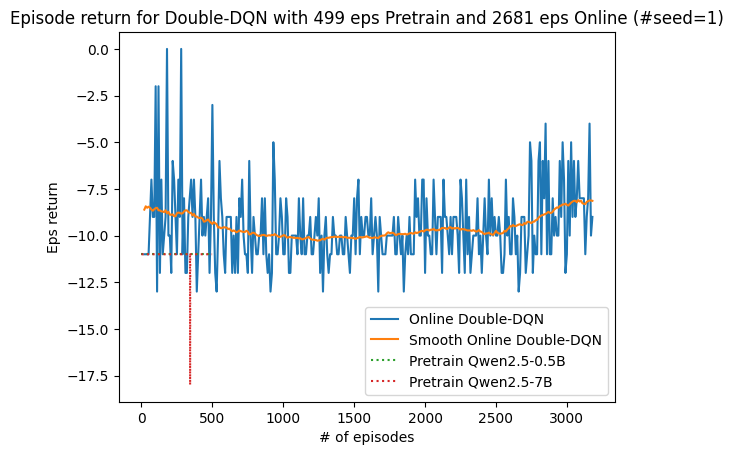

In [ ]:
# x = range(n_pretrain_eps + n_online_eps)
# window_size = 51  # Must be an odd number
# onl_y_smooth = moving_average(online_returns, window_size)

# plt.plot(online_eps, online_returns, label='Online Double-DQN')
# plt.plot(online_eps, onl_y_smooth, label='Smooth Online Double-DQN')

# plt.plot(Qwen_32B_rewards, label='Pretrain Qwen2.5-0.5B', linestyle=':')
# # plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
# plt.plot(Qwen_7B_rewards, label='Pretrain Qwen2.5-7B', linestyle=':')

# # Customize the plot
# plt.title(f'Episode return for Double-DQN with {n_pretrain_eps} eps Pretrain and {n_online_eps} eps Online (#seed={1})')
# plt.xlabel('# of episodes')
# plt.ylabel('Eps return')
# # plt.ylim(-1, 4)
# plt.legend()
# # plt.grid(True)

# # Show the plot
# plt.show()

# Plot

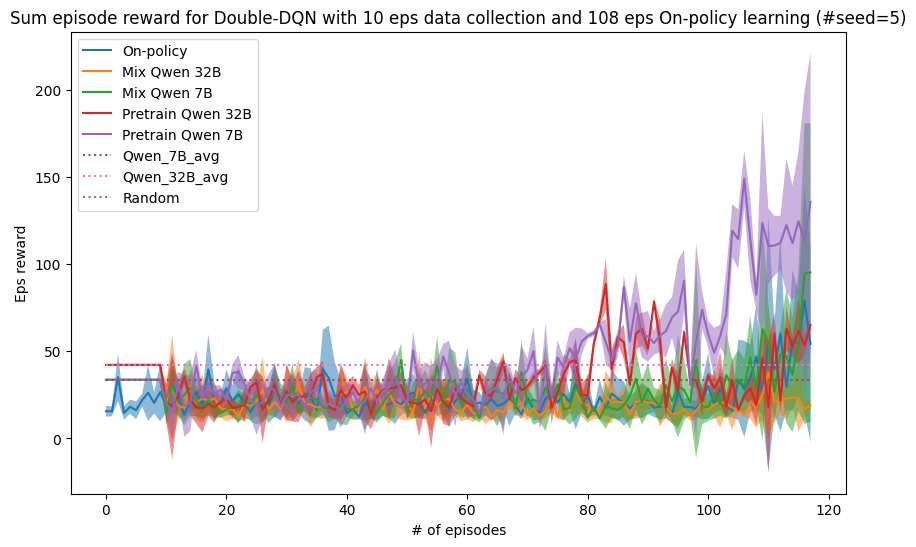

In [ ]:
x = range(n_pretrain_eps + n_online_eps)

mean_finetune_32b = np.mean(finetune_32b_returns, axis = 0)
std_finetune_32b = np.std(finetune_32b_returns, axis = 0)
mean_finetune_7b = np.mean(finetune_7b_returns, axis = 0)
std_finetune_7b = np.std(finetune_7b_returns, axis = 0)
mean_onl = np.mean(online_returns, axis = 0)
std_onl = np.std(online_returns, axis = 0)
mean_pretrain_32b_1000 = np.mean(pretrain_32b_1000_returns, axis = 0)
std_pretrain_32b_1000 = np.std(pretrain_32b_1000_returns, axis = 0)
mean_pretrain_7b_1000 = np.mean(pretrain_7b_1000_returns, axis = 0)
std_pretrain_7b_1000 = np.std(pretrain_7b_1000_returns, axis = 0)
mean_pretrain_32b_3000 = np.mean(pretrain_32b_3000_returns, axis = 0)
std_pretrain_32b_3000 = np.std(pretrain_32b_3000_returns, axis = 0)
mean_pretrain_7b_3000 = np.mean(pretrain_7b_3000_returns, axis = 0)
std_pretrain_7b_3000 = np.std(pretrain_7b_3000_returns, axis = 0)

mean_finetune_7b[:n_pretrain_eps] = Qwen_7B_avg[:n_pretrain_eps]
mean_finetune_32b[:n_pretrain_eps] = Qwen_32B_avg[:n_pretrain_eps]
mean_pretrain_32b_1000[:n_pretrain_eps] = Qwen_32B_avg[:n_pretrain_eps]
mean_pretrain_7b_1000[:n_pretrain_eps] = Qwen_7B_avg[:n_pretrain_eps]
mean_pretrain_32b_3000[:n_pretrain_eps] = Qwen_32B_avg[:n_pretrain_eps]
mean_pretrain_7b_3000[:n_pretrain_eps] = Qwen_7B_avg[:n_pretrain_eps]


# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(mean_onl, label='On-policy')
plt.fill_between(x, mean_onl-std_onl, mean_onl+std_onl, alpha=0.5)
plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
plt.fill_between(x, mean_finetune_32b-std_finetune_32b, mean_finetune_32b+std_finetune_32b, alpha=0.5)
plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
plt.fill_between(x, mean_finetune_7b-std_finetune_7b, mean_finetune_7b+std_finetune_7b, alpha=0.5)
plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000, mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000, mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000, mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000, mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

plt.plot(Qwen_7B_avg, label='Qwen_7B_avg', linestyle=':')
plt.plot(Qwen_32B_avg, label='Qwen_32B_avg', linestyle=':')
plt.plot(mean_random, label='Random', linestyle=':')

# Customize the plot
plt.title(f'Sum episode reward for Double-DQN with {n_pretrain_eps} eps data collection and {n_online_eps} eps On-policy learning (#seed={n_exp})')
plt.xlabel('# of episodes')
plt.ylabel('Eps reward')
# plt.ylim(-1, 4)
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()

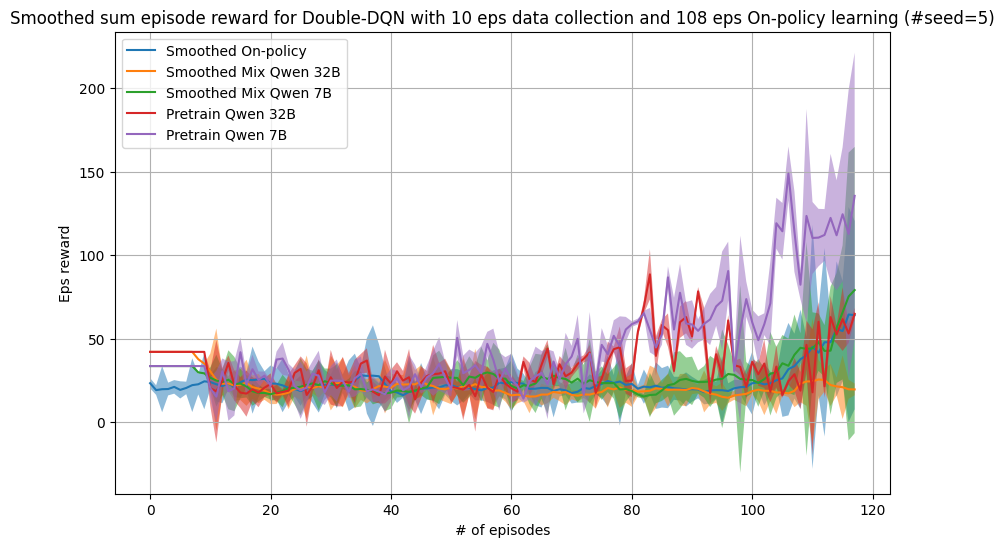

In [ ]:
def moving_average(data, window_size):
    """Compute moving average using convolution."""
    window = np.ones(window_size) / window_size
    # return np.convolve(data, window, mode='valid')
    half_window = window_size // 2
    new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
    return np.convolve(new_data, window, mode='valid')

# Define the window size for smoothing
window_size = 5  # Adjust this value as needed

# Smooth the data
smoothed_mean_onl = moving_average(mean_onl, window_size)
smoothed_mean_finetune_32b = moving_average(mean_finetune_32b, window_size)
smoothed_mean_finetune_7b = moving_average(mean_finetune_7b, window_size)
smoothed_mean_pretrain_32b_1000 = moving_average(mean_pretrain_32b_1000, window_size)
smoothed_mean_pretrain_7b_1000 = moving_average(mean_pretrain_7b_1000, window_size)
smoothed_mean_pretrain_32b_3000 = moving_average(mean_pretrain_32b_3000, window_size)
smoothed_mean_pretrain_7b_3000 = moving_average(mean_pretrain_7b_3000, window_size)

# Adjust the x-axis range for the smoothed data
x_smooth = range(len(smoothed_mean_onl))

# Plot the smoothed results
plt.figure(figsize=(10, 6))

plt.plot(x_smooth, smoothed_mean_onl, label='Smoothed On-policy')
plt.fill_between(x, smoothed_mean_onl-std_onl, smoothed_mean_onl+std_onl, alpha=0.5)
plt.plot(x_smooth, smoothed_mean_finetune_32b, label='Smoothed Mix Qwen 32B')
plt.fill_between(x, smoothed_mean_finetune_32b-std_finetune_32b, smoothed_mean_finetune_32b+std_finetune_32b, alpha=0.5)
plt.plot(x_smooth, smoothed_mean_finetune_7b, label='Smoothed Mix Qwen 7B')
plt.fill_between(x, smoothed_mean_finetune_7b-std_finetune_7b, smoothed_mean_finetune_7b+std_finetune_7b, alpha=0.5)
plt.plot(smoothed_mean_pretrain_32b_1000, label='Smoothed Pretrain Qwen 32B 1000 steps')
plt.fill_between(x, smoothed_mean_pretrain_32b_1000-std_pretrain_32b_1000, smoothed_mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
plt.plot(smoothed_mean_pretrain_7b_1000, label='Smoothed Pretrain Qwen 7B 1000 steps')
plt.fill_between(x, smoothed_mean_pretrain_7b_1000-std_pretrain_7b_1000, smoothed_mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
plt.plot(smoothed_mean_pretrain_32b_3000, label='Smoothed Pretrain Qwen 32B 3000 steps')
plt.fill_between(x, smoothed_mean_pretrain_32b_3000-std_pretrain_32b_3000, smoothed_mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
plt.plot(smoothed_mean_pretrain_7b_3000, label='Smoothed Pretrain Qwen 7B 3000 steps')
plt.fill_between(x, smoothed_mean_pretrain_7b_3000-std_pretrain_7b_3000, smoothed_mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

# Customize the plot
plt.title(f'Smoothed sum episode reward for Double-DQN with {n_pretrain_eps} eps data collection and {n_online_eps} eps On-policy learning (#seed={n_exp})')
plt.xlabel('# of episodes')
plt.ylabel('Eps reward')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# # x = range(n_steps)
# x = range(n_pretrain_eps + n_online_eps)

# mean_finetune_32b = np.mean(finetune_32b_returns, axis = 1)
# std_finetune_32b = np.std(finetune_32b_returns, axis = 1)
# mean_finetune_7b = np.mean(finetune_7b_returns, axis = 1)
# std_finetune_7b = np.std(finetune_7b_returns, axis = 1)
# # mean_rand_LORO = np.mean(rand_LORO_rewards, axis = 1)
# # std_rand_LORO = np.std(rand_LORO_rewards, axis = 1)
# mean_onl = np.mean(online_returns, axis = 1)
# std_onl = np.std(online_returns, axis = 1)
# # mean_onl_eps = np.mean(onl_rewards_eps, axis = 1)
# # std_onl_eps = np.std(onl_rewards_eps, axis = 1)
# # mean_onl_eps_decay = np.mean(onl_rewards_eps_decay, axis = 1)
# # std_onl_eps_decay = np.std(onl_rewards_eps_decay, axis = 1)

# finetune_7b_returns[:n_pretrain_eps] = Qwen_7B_avg[:n_pretrain_eps]
# finetune_32b_returns[:n_pretrain_eps] = Qwen_32B_avg[:n_pretrain_eps]
# # mean_rand_LORO[:n_pretrain_eps] = rand_avg[:n_pretrain_eps]

# # # Smooth the data
# # window_size = 1  # Must be an odd number
# # # Qwen_LORO_y_smooth = moving_average(mean_finetune_7b, window_size)
# # # rand_LORO_y_smooth = moving_average(mean_rand_LORO, window_size)
# # # llama_LORO_y_smooth = moving_average(mean_finetune_32b, window_size)
# # onl_y_smooth = moving_average(mean_onl, window_size)
# # onl_y_eps_smooth = moving_average(mean_onl_eps, window_size)
# # onl_y_eps_decay_smooth = moving_average(mean_onl_eps_decay, window_size)

# # # std_onl = std_onl[window_size//2:-window_size//2 + 1]
# # # std_rand_LORO = std_rand_LORO[window_size//2:-window_size//2 + 1]
# # # std_finetune_7b = std_finetune_7b[window_size//2:-window_size//2 + 1]
# # # std_finetune_32b = std_finetune_32b[window_size//2:-window_size//2 + 1]
# # # x_smooth = x[window_size//2:-window_size//2 + 1]
# # x_smooth = x

# # Create the plot
# plt.figure(figsize=(10, 6))

# plt.plot(onl_y_smooth, label='Online DQN')
# plt.fill_between(x_smooth, onl_y_smooth-std_onl, onl_y_smooth+std_onl, alpha=0.5)
# plt.plot(onl_y_eps_smooth, label='Online DQN const eps=0.3')
# plt.fill_between(x_smooth, onl_y_eps_smooth-std_onl_eps, onl_y_eps_smooth+std_onl_eps, alpha=0.5)
# plt.plot(onl_y_eps_decay_smooth, label='Online DQN decay eps')
# plt.fill_between(x_smooth, onl_y_eps_decay_smooth-std_onl, onl_y_eps_decay_smooth+std_onl, alpha=0.5)
# # plt.plot(Qwen_LORO_y_smooth, label='Finetune Qwen')
# # plt.fill_between(x_smooth, Qwen_LORO_y_smooth-std_finetune_7b, Qwen_LORO_y_smooth+std_finetune_7b, alpha=0.5)
# # plt.plot(rand_LORO_y_smooth, label='Finetune Rand')
# # plt.fill_between(x_smooth, rand_LORO_y_smooth-std_rand_LORO, rand_LORO_y_smooth+std_rand_LORO, alpha=0.5)
# # plt.plot(llama_LORO_y_smooth, label='Finetune Llama')
# # plt.fill_between(x_smooth, llama_LORO_y_smooth-std_finetune_32b, llama_LORO_y_smooth+std_finetune_32b, alpha=0.5)

# plt.plot(Qwen_avg, label='Pretrain Qwen2.5-0.5B', linestyle=':')
# plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
# plt.plot(llama_avg, label='Pretrain Llama', linestyle=':')

# # Customize the plot
# plt.title(f'Smoothed (w={window_size}) episode reward for DQN with {n_pretrain_steps} steps Pretrain and {n_steps} steps Online (#seed={n_exp})')
# plt.xlabel('# of steps')
# plt.ylabel('Eps reward')
# plt.ylim(-1, 4)
# plt.legend()
# # plt.grid(True)

# # Show the plot
# plt.show()